In [105]:
import torch
import numpy as np
import torch.nn as nn 
import math
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from enum import Enum
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
import pandas as pd
from skimage.util import random_noise
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(2024)

## Datasets

### MNIST

In [2]:
transform_MNIST = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

In [3]:
emnist_train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=False, transform=transform_MNIST)
emnist_test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=False, transform=transform_MNIST)

In [4]:
fashionmnist_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_MNIST)
fashionmnist_test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_MNIST)

### CIFAR

In [5]:
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
cifar10_test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)
cifar100_train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_cifar)
cifar100_test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_cifar)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Dataloaders

In [119]:
emnist_train_loader = DataLoader(emnist_train_dataset, batch_size=1, shuffle=True)
emnist_test_loader = DataLoader(emnist_test_dataset, batch_size=1, shuffle=True)
fashionmnist_train_loader = DataLoader(fashionmnist_train_dataset, batch_size=1, shuffle=True)
fashionmnist_test_loader = DataLoader(fashionmnist_test_dataset, batch_size=1, shuffle=True)
cifar10_train_loader = DataLoader(cifar10_train_dataset, batch_size=1, shuffle=True)
cifar10_test_loader = DataLoader(cifar10_test_dataset, batch_size=1, shuffle=True)
cifar100_train_loader = DataLoader(cifar100_train_dataset, batch_size=1, shuffle=True)
cifar100_test_loader = DataLoader(cifar100_test_dataset, batch_size=1, shuffle=True)

## Data Augmentation

imgcorruptlike sub-library require image data at least 32x32 pixels

In [141]:
def gaussian(img, mean, var):
    return torch.tensor(random_noise(img, mode='gaussian', mean=mean, var=var, rng=2024), dtype=torch.float32)

def speckle(img, mean, var):
    return torch.tensor(random_noise(img, mode='speckle', mean=mean, var=var, rng=2024), dtype=torch.float32) 

def occlusion(image, level):
    image = denormalize_grayscale_image(image)
    occlusion = iaa.CoarseDropout(level, size_percent=1, random_state=2024)
    noisy_input = occlusion(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def averageblur(image, level):
    image = denormalize_grayscale_image(image)
    averageblur = iaa.AverageBlur(k=(2,level), random_state=2024)
    noisy_input = averageblur(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

### The following noises cannot be applied to MNIST images


def snow(image, level):
    image = denormalize_grayscale_image(image)
    snow = iaa.imgcorruptlike.Snow(severity=level, random_state=2024)
    noisy_input = snow(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def glassblur(image, level):
    image = denormalize_grayscale_image(image)
    glassblur = iaa.imgcorruptlike.GlassBlur(severity=level, random_state=2024)
    noisy_input = glassblur(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def defocusblur(image, level):
    image = denormalize_grayscale_image(image)
    defocusblur = iaa.imgcorruptlike.DefocusBlur(severity=level, random_state=2024)
    noisy_input = defocusblur(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

def spatter(image, level):
    image = denormalize_grayscale_image(image)
    spatter = iaa.imgcorruptlike.DefocusBlur(severity=level, random_state=2024)
    noisy_input = spatter(images=image)
    noisy_input = normalize_grayscale_image(noisy_input)
    return noisy_input

In [239]:
variance_levels = [0.005, 0.01, 0.05, 0.1, 0.25]
severity = [1,2,3,4,5]
occlusion_levels = [0.02, 0.04, 0.06, 0.08, 0.1]
averageblur_levels = [2, 4, 6, 8, 10]

In [186]:
emnist_train_dataset_gaussian = [[(gaussian(img, 0, lev), label)for img, label in emnist_train_dataset] for lev in variance_levels]
emnist_train_dataset_speckle = [[(speckle(img, 0, lev), label)for img, label in emnist_train_dataset] for lev in variance_levels]
emnist_train_dataset_averageblur = [[(averageblur(img, lev), label)for img, label in emnist_train_dataset] for lev in averageblur_levels]

emnist_test_dataset_gaussian = [[(gaussian(img, 0, lev), label)for img, label in emnist_test_dataset] for lev in variance_levels]
emnist_test_dataset_speckle = [[(speckle(img, 0, lev), label)for img, label in emnist_test_dataset] for lev in variance_levels]
emnist_test_dataset_averageblur = [[(averageblur(img, lev), label)for img, label in emnist_test_dataset] for lev in averageblur_levels]

In [242]:
emnist_train_dataset_occlusion = [[(occlusion(img, lev), label)for img, label in emnist_train_dataset] for lev in occlusion_levels]
emnist_test_dataset_occlusion = [[(occlusion(img, lev), label)for img, label in emnist_test_dataset] for lev in occlusion_levels]
emnist_train_dataloader_occlusion = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_train_dataset_occlusion]
emnist_test_dataloader_occlusion = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_occlusion]

In [189]:
emnist_train_dataloader_gaussian = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_train_dataset_gaussian]
emnist_train_dataloader_speckle = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_train_dataset_speckle]
emnist_train_dataloader_averageblur = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_train_dataset_averageblur]

emnist_test_dataloader_gaussian = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_gaussian]
emnist_test_dataloader_speckle = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_speckle]
emnist_test_dataloader_averageblur = [DataLoader(dt, batch_size=1, shuffle=True) for dt in emnist_test_dataset_averageblur]

## Models

In [8]:
def denormalize_grayscale_image(img):
    img = (img * 255).to(torch.uint8)
    img = img.view(28, 28).numpy()
    return img

def denormalize_rgb_image(img):
    img = img.permute(0, 2, 3, 1)
    di = ((img * 0.5 + 0.5) * 255).to(torch.uint8)
    return di.squeeze().numpy()

In [86]:
def normalize_grayscale_image(img):
    return torch.from_numpy(img).view(-1).unsqueeze(0).to(torch.float32) / 255.0

In [9]:
def oneHotEncode(labels, num_classes):
    one_hot_encoded = torch.zeros(len(labels), num_classes)
    one_hot_encoded.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot_encoded.squeeze()

def print_weight(model):
    for l in model.layers.values():
        print(l.feedforward.weight)

In [42]:
class Learning(Enum):
    Hebbian = 1
    Exp_Hebbian = 2
    Sanger = 3
    FullyOrthogonal = 4
    Contrastive = 5

class DatasetName(Enum):
    EMNIST = 1
    FashionMNIST = 2
    CIFAR10 = 3
    CIFAR100 = 4

class Noise(Enum):
    Gaussian = 1
    Speckle = 2
    Occlusion = 3
    AverageBlur = 4
    Snow = 5
    GlassBlur = 6
    DefocusBlur = 7
    Spatter = 8

In [11]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layers = nn.ModuleDict()
        self.iteration = 3
    
    def add_layer(self, name, layer):
        self.layers[name] = layer

    def visualize_weights(self):
        for layer_name, module in self.layers.items():
            module.visualize_weights()

    def forward(self, x, clamped, learning):
        for layer in self.layers.values():
            x = layer(x, clamped, learning)
        return x
    
    def Hebbian_test(self, x):
        for layer in self.layers.values():
            x = layer.forward_test(x)
        return x
    
    def set_iteration(self, i):
        self.iteration = i
    
    def forward_clamped(self, x, clamped):
        input = x.detach().clone()
        layers = list(self.layers.values())
        nb_layers = len(layers)
        hlist = [None]*nb_layers
        for iter in range(self.iteration):
            hlist[-1] = clamped
            x = input
            for idx in range(nb_layers-1):
                w_topdown = layers[idx+1].feedforward.weight.detach().clone()
                h_topdown = hlist[idx+1]
                x = layers[idx].contrastive_forward(x, w_topdown, h_topdown)
                hlist[idx] = x
        return hlist

    def forward_free(self, x):
        input = x.detach().clone()
        layers = list(self.layers.values())
        nb_layers = len(layers)
        hlist = [None]*nb_layers
        for _ in range(self.iteration):
            x = input
            for idx in range(nb_layers-1):
                w = layers[idx+1].feedforward.weight.detach().clone()
                h_l = hlist[idx+1]
                x = layers[idx].contrastive_forward(x, w, h_l)
                hlist[idx] = x
            x_L = layers[-1].forward_test(hlist[-2])
            hlist[-1] = x_L
        return x_L
    
    def hebclass_forward(self, x):
        input = x.detach().clone()
        layers = list(self.layers.values())
        nb_layers = len(layers)
        hlist = [None]*nb_layers
        for _ in range(self.iteration):
            x = input
            for idx in range(nb_layers-1):
                w = layers[idx+1].feedforward.weight.detach().clone()
                h_l = hlist[idx+1]
                x = layers[idx].contrastive_forward(x, w, h_l)
                hlist[idx] = x
            x_L = layers[-1].forward_test(hlist[-2])
            hlist[-1] = x_L
        return hlist
    
    def update_weights_Contrastive(self, input, zero_clamped_hlist, label_clamped_hlist):
        # print(zero_clamped_hlist)
        # print(label_clamped_hlist)
        layers = list(self.layers.values())
        nb_layers = len(layers)
        for idx in range(nb_layers):
            if idx == 0:
                outer_label = torch.outer(label_clamped_hlist[idx].squeeze(0), input.squeeze(0))
                outer_zero = torch.outer(zero_clamped_hlist[idx].squeeze(0), input.squeeze(0))
                delta_weight = layers[idx].lr*(outer_label - outer_zero)

                # delta_bias = label_clamped_hlist[idx].squeeze(0) - zero_clamped_hlist[idx].squeeze(0)

                # print(outer_label - outer_zero)
                # if torch.isnan(delta_weight).all():
                #     print("NaN delta W on layer 0")
                #     print("Clamped Input Signal :")
                #     print(input.squeeze(0))
                #     print("Zero Clamped hs:")
                #     print(zero_clamped_hlist)
                #     print("Label Clamped hs:")
                #     print(label_clamped_hlist)
                #     print("Weights:")
                #     print(layers[idx].feedforward.weight)

            elif idx == (nb_layers-1):
                outer_label = torch.outer(label_clamped_hlist[idx].squeeze(0), label_clamped_hlist[idx-1].squeeze(0))
                delta_weight = layers[idx].lr*(outer_label)

                # delta_bias = label_clamped_hlist[idx].squeeze(0)
                # print(outer_label - outer_zero)
               
            else:
                outer_label = torch.outer(label_clamped_hlist[idx].squeeze(0), label_clamped_hlist[idx-1].squeeze(0))
                outer_zero = torch.outer(zero_clamped_hlist[idx].squeeze(0), zero_clamped_hlist[idx-1].squeeze(0))
                delta_weight = layers[idx].lr*(outer_label - outer_zero)

                # delta_bias = label_clamped_hlist[idx].squeeze(0) - zero_clamped_hlist[idx].squeeze(0)
                # print(outer_label - outer_zero)

            initial_weights = layers[idx].feedforward.weight.detach().clone()
            layers[idx].feedforward.weight=nn.Parameter(torch.add(initial_weights, delta_weight), requires_grad=False)
            # initial_biases = layers[idx].feedforward.bias.detach().clone()
            # layers[idx].feedforward.bias=nn.Parameter(torch.add(initial_biases, delta_bias), requires_grad=False)
            return delta_weight
    
    def update_weights(self, input, all_hlist, learning, output):
        allh = [input] + all_hlist
        allh[-1] = allh[-1].unsqueeze(0)
        layers = list(self.layers.values())
        layer_names = list(self.layers.keys())
        nb_layers = len(layers)
        if learning == Learning.Hebbian:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_Hebb(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()
        elif learning == Learning.Exp_Hebbian:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_Hebb_exp(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()
        elif learning == Learning.Sanger:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_Sanger(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()
        elif learning == Learning.FullyOrthogonal:
            for idx in range(nb_layers):
                if layer_names[idx] == "Classifier":
                    layers[idx].update_weights(allh[idx], allh[idx+1], output)
                else:
                    layers[idx].update_weights_FullyOrthogonal(allh[idx], allh[idx+1])
                    layers[idx].weight_decay()


    def contrastive(self, x, labels, learning=Learning.Sanger):
        input = x.detach().clone()
        all_hlist_label = self.forward_clamped(x, labels)
        if learning == Learning.Contrastive:
            all_hlist_zero = self.forward_clamped(x, None)
            dw = self.update_weights_Contrastive(input, all_hlist_zero, all_hlist_label)
        else:
            # all_hlist_zero = self.forward_clamped(x, None)
            self.update_weights(input, all_hlist_label, learning, labels)
    
    def contrastive_hebclass(self, x, labels, learning):
        input = x.detach().clone()
        all_hlist = self.hebclass_forward(x)
        self.update_weights(input, all_hlist, learning, labels)
        

In [33]:
class Hebbian_Layer(nn.Module):
    def __init__(self, inputdim, outputdim, lr, lamb, w_decrease, gamma, eps, is_output_layer=False):
        super(Hebbian_Layer, self).__init__()
        self.input_dim = inputdim
        self.output_dim = outputdim
        self.lr = lr
        self.lamb = lamb
        self.decrease = w_decrease
        self.gamma = gamma
        self.epsilon = eps
        self.is_output_layer = is_output_layer

        self.feedforward = nn.Linear(self.input_dim, self.output_dim, bias=False)

        for param in self.feedforward.parameters():
            param=torch.nn.init.uniform_(param, a=0.0, b=1.0)
            param.requires_grad_(False)
        

        # self.itensors=self.createITensors()
        self.exponential_average=torch.zeros(self.output_dim)

    # def createITensors(self):
    #     itensors=torch.zeros(self.output_dim, self.output_dim, self.output_dim, dtype=torch.float)
    #     for i in range(0, self.output_dim):
    #         identity = torch.eye(i+1)
    #         padded_identity = torch.nn.functional.pad(identity, (0, self.output_dim - i-1, 0, 
    #                                                              self.output_dim - i-1))
    #         itensors[i]=padded_identity
    #     return itensors

    def inhibition(self, x):
        x=nn.ReLU()(x)
        max_ele=torch.max(x).item()
        x=torch.pow(x, self.lamb)
        x/=abs(max_ele)**self.lamb
        return x

    # Classic Hebbian
    def update_weights_Hebb(self, input, output):
        x=input.detach().clone().squeeze()
        y=output.detach().clone().squeeze()
        outer_prod=torch.outer(y, x)
        delta_weight = self.lr*(outer_prod)
        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)
    
    # Exponential Hebbian 
    def update_weights_Hebb_exp(self, input, output):
        x=input.detach().clone().squeeze()
        y=output.detach().clone().squeeze()
        outer_prod=torch.outer(y, x)
        initial_weights = self.feedforward.weight.detach().clone()
        delta_weight = self.lr*(outer_prod - initial_weights)
        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)

    # # Sanger's rule
    # def update_weights_Sanger(self, input, output):
    #     x=input.detach().clone().squeeze()
    #     y=output.detach().clone().squeeze()
    #     outer_prod=torch.outer(y, x)
    #     initial_weight=torch.transpose(self.feedforward.weight.detach().clone(), 0,1)
    #     A=torch.einsum('jk, lkm, m -> lj', initial_weight, self.itensors, y)
    #     A=A*(y.unsqueeze(1))
    #     delta_weight=self.lr*(outer_prod-A)
    #     self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
    #     self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)


    '''
    Sanger's rule
    -------------

    input : [batch_size, features]
    output : [batch_size, dim]

    projections : [batch_size, features]
    output[:, :i+1] : [batch_size] 
    input - projections : [batch_size, features]

    element-wise multiplication of y_i over (input - projections) 
    '''
    def update_weights_Sanger(self, input, output):

        y=output.detach().clone().squeeze()
    
        weights = self.feedforward.weight.detach()
        output_dim = weights.shape[0]

        delta_weights = torch.zeros_like(weights)

        for i in range(output_dim):
            projections = torch.matmul(output[:, :i+1], weights[:i+1])
            delta_w = self.lr * torch.mean((output[:, i].unsqueeze(1) * (input - projections)), dim=0)
            delta_weights[i] = delta_w

        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weights), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)
        

    # Fully orthogonal Sanger variant
    def update_weights_FullyOrthogonal(self, input, output):
        x=input.detach().clone().squeeze()
        y=output.detach().clone().squeeze()
        initial_weight = self.feedforward.weight.detach().clone()
        outer_prod = torch.outer(y, x)
        ytw = torch.matmul(y.unsqueeze(0), initial_weight)
        norm_term = torch.outer(y.squeeze(0), ytw.squeeze(0))
        delta_weight = self.lr*(outer_prod - norm_term)
        self.feedforward.weight=nn.Parameter(torch.add(self.feedforward.weight, delta_weight), requires_grad=False)
        self.exponential_average=torch.add(self.gamma*self.exponential_average,(1-self.gamma)*y)
        # self.updateBias(output)
        

    def weight_decay(self):
        average=torch.mean(self.exponential_average).item()
        A=self.exponential_average/average
        growth_factor_positive=self.epsilon*nn.Tanh()(-self.epsilon*(A-1))+1
        growth_factor_negative=torch.reciprocal(growth_factor_positive)
        positive_weights=torch.where(self.feedforward.weight>0, self.feedforward.weight, 0.0)
        negative_weights=torch.where(self.feedforward.weight<0, self.feedforward.weight, 0.0)
        positive_weights=positive_weights*growth_factor_positive.unsqueeze(1)
        negative_weights=negative_weights*growth_factor_negative.unsqueeze(1)
        self.feedforward.weight=nn.Parameter(torch.add(positive_weights, negative_weights), requires_grad=False)

    def visualize_weights(self):
        nb = int(math.ceil(math.sqrt(self.output_dim)))
        if not self.is_output_layer:
            fig, axes = plt.subplots(nb, nb, figsize=(32,32))
            nb_ele = self.output_dim
        else :
            nb_ele = self.output_dim
            fig, axes = plt.subplots(nb_ele, figsize=(32, 32))
            
        weight = self.feedforward.weight
        for ele in range(nb_ele):
            random_feature_selector = weight[ele]
            heatmap = random_feature_selector.view(int(math.sqrt(weight.size(1))),
                                                    int(math.sqrt(weight.size(1))))
            ax = axes[ele // nb, ele % nb]
            im = ax.imshow(heatmap, cmap='hot', interpolation='nearest')
            fig.colorbar(im, ax=ax)
            ax.set_title(f'Weight {ele}')

        plt.tight_layout()
        plt.show()
            

    def forward(self, x, clamped=None, learning=1):
        input = x.detach().clone()
        x = self.feedforward(x)
        x = self.inhibition(x)
        if learning == Learning.Hebbian:
            self.update_weights_Hebb(input, x)
        elif learning == Learning.Exp_Hebbian:
            self.update_weights_Hebb_exp(input, x)
        elif learning == Learning.Sanger:
            self.update_weights_Sanger(input, x)
        elif learning == Learning.FullyOrthogonal:
            self.update_weights_FullyOrthogonal(input, x)
        self.weight_decay()
        return x
            
    def forward_test(self, x):
        x = self.feedforward(x)
        x = self.inhibition(x)
        return x
    
    def contrastive_forward(self, x, w, h_l):
        if h_l == None:
            h = self.feedforward(x)
        else :
            w = self.decrease*w
            h = self.feedforward(x) + torch.matmul(h_l, w)
        return self.inhibition(h)

In [40]:
class Classifier_Layer(nn.Module):
    def __init__(self, inputdim, outputdim, lr):
        super(Classifier_Layer, self).__init__()
        self.input_dim = inputdim
        self.output_dim = outputdim
        self.lr = lr

        self.feedforward = nn.Linear(self.input_dim, self.output_dim)

    
    def update_weights(self, input, output, clamped):
        u=output.detach().clone().squeeze()
        x=input.detach().clone().squeeze()
        y=torch.softmax(u, dim=0)
        A=None
        if clamped != None:
            outer_prod=torch.outer(clamped-y,x)
            u_times_y=torch.mul(u,y)
            A=outer_prod-self.feedforward.weight*(u_times_y.unsqueeze(1))
        else:
            A=torch.outer(y,x)
        A=self.feedforward.weight+self.lr*A
        weight_maxes=torch.max(A, dim=1).values
        self.feedforward.weight=nn.Parameter(A/weight_maxes.unsqueeze(1), requires_grad=False)
        self.feedforward.weight[:, 0] = 0
    
    def forward(self, x, clamped, learning=None):
        input = x.detach().clone()
        x=self.feedforward(x)
        self.update_weights(input, x, clamped)
        x=nn.Softmax()(x)
        return x
    
    def forward_test(self, x):
        x = self.feedforward(x)
        x=nn.Softmax()(x)
        return x

    def contrastive_forward(self, x, wT, xhat, clamped):
        input = x.detach().clone()
        if wT == None and xhat == None:
            h = self.feedforward(x)
        else : 
            h = self.feedforward(x) + torch.matmul(xhat,wT)
        self.update_weights(input, h, clamped)
        h = nn.Softmax()(h)
        return h

    def visualize_weights(self):
        weight = self.feedforward.weight
        nb_ele = self.feedforward.weight.size(0)
        nb = math.ceil(math.sqrt(nb_ele))
        fig, axes = plt.subplots(nb, nb, figsize=(32,32))
        for ele in range(nb_ele):
            random_feature_selector = weight[ele]
            heatmap = random_feature_selector.view(int(math.sqrt(self.feedforward.weight.size(1))),
                                                    int(math.sqrt(self.feedforward.weight.size(1))))
            ax = axes[ele // nb, ele % nb]
            im = ax.imshow(heatmap, cmap='hot', interpolation='nearest')
            fig.colorbar(im, ax=ax)
            ax.set_title(f'Weight {ele}')
        plt.tight_layout()
        plt.show()

## MLP-Baseline

In [191]:
def MLPBaseline_Experiment(hsize, lamb, lr, learning, e, dataloader, nclasses):

    mymodel = NeuralNet()
    heb_layer = Hebbian_Layer(784, hsize, lr, lamb, 0.8, 0.95, e)
    class_layer = Classifier_Layer(hsize, nclasses, lr)

    mymodel.add_layer("Hebbian1", heb_layer)
    mymodel.add_layer("Class", class_layer)

    mymodel.train()

    for _ in range(3):
        for data in tqdm(dataloader):
            inputs, labels=data
            mymodel.forward(inputs, oneHotEncode(labels, nclasses), learning)
    
    return mymodel

In [15]:
def MLPBaseline_test_accuracy(mymodel, data_loader):
    yes = 0
    tot = 0
    da = {}
    for data in tqdm(data_loader):
        inputs, labels = data
        output = torch.argmax(mymodel.Hebbian_test(inputs))
        if labels.item() not in da:
            da[labels.item()] = (0, 0)
        r, t = da[labels.item()]
        if output.item() == labels.item():
            yes += 1
            da[labels.item()] = (r+1, t+1)
        else :
            da[labels.item()] = (r, t+1)
        tot += 1
    return (yes/tot), da

## EMNIST - Experiments

### No Noise

In [16]:
lambs = [0.4, 0.7, 1, 2, 5, 8, 11, 14, 15, 16]
eps = [0.001, 0.01, 0.1]

In [17]:
for l in lambs:
    for e in eps:
        print("Hyper params : lambda = " + str(l) + ", epsilon = " + str(e))
        MLPBaseline_EMNIST = MLPBaseline_Experiment(hsize=64, lamb=l, lr=0.005, learning=Learning.FullyOrthogonal, e=e, dataset=DatasetName.EMNIST)
        print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_train_loader))
        print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_test_loader))

Hyper params : lambda = 0.4, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.30347517730496454, {46: (1495, 2400), 22: (1330, 2400), 15: (454, 2400), 39: (1948, 2400), 19: (245, 2400), 25: (321, 2400), 27: (245, 2400), 32: (1602, 2400), 0: (108, 2400), 11: (234, 2400), 43: (1209, 2400), 7: (756, 2400), 41: (210, 2400), 3: (428, 2400), 26: (911, 2400), 38: (1113, 2400), 16: (1297, 2400), 44: (1122, 2400), 14: (377, 2400), 24: (313, 2400), 1: (122, 2400), 33: (1358, 2400), 45: (742, 2400), 31: (745, 2400), 29: (936, 2400), 18: (1874, 2400), 6: (599, 2400), 35: (587, 2400), 8: (297, 2400), 30: (1349, 2400), 21: (31, 2400), 2: (195, 2400), 34: (262, 2400), 28: (1, 2400), 42: (427, 2400), 12: (553, 2400), 4: (1059, 2400), 13: (466, 2400), 23: (1368, 2400), 20: (1243, 2400), 36: (366, 2400), 5: (744, 2400), 37: (1506, 2400), 9: (0, 2400), 10: (566, 2400), 40: (513, 2400), 17: (605, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2996276595744681, {7: (120, 400), 39: (320, 400), 42: (80, 400), 38: (199, 400), 1: (14, 400), 30: (229, 400), 29: (153, 400), 26: (152, 400), 9: (0, 400), 17: (107, 400), 35: (83, 400), 45: (111, 400), 22: (214, 400), 11: (46, 400), 4: (157, 400), 28: (0, 400), 20: (217, 400), 32: (295, 400), 16: (215, 400), 10: (96, 400), 44: (191, 400), 15: (85, 400), 13: (83, 400), 0: (19, 400), 3: (72, 400), 12: (97, 400), 2: (38, 400), 33: (215, 400), 36: (66, 400), 40: (67, 400), 23: (225, 400), 14: (62, 400), 43: (185, 400), 46: (247, 400), 19: (44, 400), 6: (95, 400), 25: (54, 400), 18: (292, 400), 37: (246, 400), 5: (135, 400), 8: (38, 400), 24: (59, 400), 21: (3, 400), 31: (112, 400), 34: (36, 400), 41: (30, 400), 27: (29, 400)})
Hyper params : lambda = 0.4, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.44141843971631206, {11: (619, 2400), 44: (484, 2400), 21: (63, 2400), 16: (1328, 2400), 33: (1324, 2400), 43: (1131, 2400), 8: (467, 2400), 32: (1703, 2400), 20: (1013, 2400), 34: (275, 2400), 9: (1380, 2400), 19: (594, 2400), 7: (1634, 2400), 41: (442, 2400), 29: (1236, 2400), 0: (1094, 2400), 38: (1399, 2400), 31: (1395, 2400), 14: (1068, 2400), 46: (881, 2400), 1: (1013, 2400), 39: (1175, 2400), 40: (890, 2400), 37: (1213, 2400), 13: (1100, 2400), 17: (843, 2400), 45: (1483, 2400), 42: (1285, 2400), 26: (1330, 2400), 15: (282, 2400), 24: (988, 2400), 5: (840, 2400), 28: (884, 2400), 22: (1760, 2400), 27: (494, 2400), 10: (651, 2400), 23: (1394, 2400), 2: (887, 2400), 36: (1352, 2400), 6: (1649, 2400), 12: (1256, 2400), 3: (1742, 2400), 35: (1259, 2400), 18: (1147, 2400), 30: (816, 2400), 4: (1087, 2400), 25: (1442, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4372872340425532, {17: (135, 400), 37: (175, 400), 45: (233, 400), 44: (79, 400), 28: (146, 400), 32: (314, 400), 29: (185, 400), 33: (212, 400), 5: (132, 400), 7: (272, 400), 19: (92, 400), 16: (222, 400), 43: (187, 400), 2: (164, 400), 12: (211, 400), 25: (227, 400), 3: (320, 400), 40: (135, 400), 42: (227, 400), 1: (167, 400), 18: (171, 400), 13: (179, 400), 24: (180, 400), 31: (227, 400), 14: (188, 400), 30: (130, 400), 38: (233, 400), 15: (42, 400), 22: (280, 400), 23: (220, 400), 36: (214, 400), 39: (204, 400), 4: (168, 400), 0: (196, 400), 10: (114, 400), 46: (150, 400), 41: (75, 400), 21: (9, 400), 6: (273, 400), 8: (66, 400), 11: (118, 400), 34: (41, 400), 9: (219, 400), 20: (177, 400), 27: (60, 400), 35: (206, 400), 26: (246, 400)})
Hyper params : lambda = 0.4, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5281382978723405, {18: (911, 2400), 1: (1137, 2400), 34: (1102, 2400), 31: (1578, 2400), 23: (1112, 2400), 45: (1682, 2400), 9: (1081, 2400), 2: (1150, 2400), 37: (1561, 2400), 42: (1524, 2400), 7: (1653, 2400), 11: (980, 2400), 39: (1643, 2400), 33: (1541, 2400), 22: (2016, 2400), 29: (1579, 2400), 8: (1322, 2400), 12: (1261, 2400), 21: (252, 2400), 17: (1363, 2400), 13: (1239, 2400), 28: (1279, 2400), 26: (1131, 2400), 3: (1847, 2400), 40: (721, 2400), 43: (1683, 2400), 24: (1109, 2400), 20: (1053, 2400), 46: (920, 2400), 6: (1600, 2400), 5: (1312, 2400), 19: (852, 2400), 16: (1699, 2400), 4: (1374, 2400), 25: (1276, 2400), 35: (1230, 2400), 30: (1261, 2400), 14: (1320, 2400), 15: (867, 2400), 44: (789, 2400), 32: (1743, 2400), 0: (1140, 2400), 10: (1198, 2400), 41: (551, 2400), 38: (1728, 2400), 36: (1137, 2400), 27: (1067, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.521595744680851, {0: (194, 400), 5: (221, 400), 15: (139, 400), 32: (308, 400), 35: (211, 400), 2: (190, 400), 37: (257, 400), 45: (274, 400), 36: (160, 400), 11: (176, 400), 39: (264, 400), 12: (205, 400), 42: (256, 400), 40: (111, 400), 6: (273, 400), 14: (230, 400), 10: (200, 400), 31: (247, 400), 38: (301, 400), 34: (165, 400), 44: (123, 400), 16: (275, 400), 23: (184, 400), 4: (214, 400), 13: (211, 400), 25: (213, 400), 33: (254, 400), 26: (203, 400), 20: (180, 400), 19: (144, 400), 1: (188, 400), 3: (315, 400), 29: (259, 400), 17: (212, 400), 21: (46, 400), 7: (268, 400), 43: (283, 400), 18: (133, 400), 24: (206, 400), 41: (94, 400), 46: (157, 400), 30: (211, 400), 27: (155, 400), 28: (203, 400), 8: (210, 400), 22: (319, 400), 9: (164, 400)})
Hyper params : lambda = 0.7, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2889450354609929, {33: (730, 2400), 8: (2020, 2400), 25: (786, 2400), 24: (22, 2400), 29: (438, 2400), 1: (445, 2400), 27: (106, 2400), 3: (383, 2400), 21: (168, 2400), 0: (0, 2400), 22: (1338, 2400), 7: (641, 2400), 13: (1505, 2400), 32: (1609, 2400), 37: (1598, 2400), 12: (1, 2400), 28: (236, 2400), 14: (257, 2400), 19: (982, 2400), 6: (762, 2400), 30: (1024, 2400), 2: (465, 2400), 38: (523, 2400), 34: (312, 2400), 4: (403, 2400), 35: (234, 2400), 31: (1190, 2400), 17: (1275, 2400), 9: (20, 2400), 11: (339, 2400), 15: (286, 2400), 36: (722, 2400), 46: (1466, 2400), 26: (222, 2400), 41: (377, 2400), 40: (83, 2400), 23: (1064, 2400), 20: (577, 2400), 39: (1629, 2400), 42: (963, 2400), 16: (1420, 2400), 43: (405, 2400), 44: (295, 2400), 10: (759, 2400), 18: (1203, 2400), 45: (773, 2400), 5: (537, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.28595744680851065, {8: (331, 400), 10: (120, 400), 12: (0, 400), 23: (179, 400), 37: (266, 400), 35: (38, 400), 22: (232, 400), 13: (251, 400), 6: (121, 400), 45: (109, 400), 0: (0, 400), 3: (62, 400), 30: (164, 400), 4: (56, 400), 24: (3, 400), 14: (47, 400), 27: (22, 400), 39: (271, 400), 26: (30, 400), 28: (38, 400), 9: (1, 400), 36: (124, 400), 29: (65, 400), 33: (123, 400), 20: (98, 400), 1: (75, 400), 5: (85, 400), 43: (74, 400), 7: (91, 400), 19: (161, 400), 38: (101, 400), 40: (8, 400), 15: (50, 400), 34: (48, 400), 11: (64, 400), 16: (244, 400), 31: (184, 400), 41: (64, 400), 18: (171, 400), 25: (124, 400), 46: (255, 400), 21: (23, 400), 17: (197, 400), 2: (84, 400), 42: (174, 400), 44: (51, 400), 32: (297, 400)})
Hyper params : lambda = 0.7, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5006294326241135, {19: (707, 2400), 13: (1162, 2400), 23: (634, 2400), 31: (1634, 2400), 18: (1082, 2400), 1: (1351, 2400), 9: (1102, 2400), 35: (1007, 2400), 5: (732, 2400), 22: (1867, 2400), 15: (439, 2400), 20: (862, 2400), 44: (920, 2400), 30: (1294, 2400), 11: (1496, 2400), 2: (1080, 2400), 26: (1233, 2400), 8: (985, 2400), 27: (1374, 2400), 7: (1789, 2400), 24: (1279, 2400), 17: (1654, 2400), 21: (28, 2400), 37: (1389, 2400), 4: (1060, 2400), 39: (1561, 2400), 42: (1600, 2400), 36: (715, 2400), 45: (1768, 2400), 38: (1452, 2400), 41: (513, 2400), 29: (1569, 2400), 34: (826, 2400), 12: (1161, 2400), 6: (1600, 2400), 3: (1219, 2400), 28: (1506, 2400), 43: (1635, 2400), 10: (877, 2400), 46: (904, 2400), 33: (1300, 2400), 0: (1260, 2400), 32: (1726, 2400), 16: (1282, 2400), 40: (994, 2400), 14: (1312, 2400), 25: (1531, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4943085106382979, {1: (224, 400), 45: (283, 400), 12: (190, 400), 25: (254, 400), 5: (116, 400), 3: (223, 400), 23: (100, 400), 22: (309, 400), 33: (215, 400), 6: (262, 400), 38: (253, 400), 11: (251, 400), 46: (147, 400), 29: (252, 400), 34: (129, 400), 20: (145, 400), 41: (78, 400), 19: (105, 400), 14: (230, 400), 32: (307, 400), 31: (267, 400), 8: (151, 400), 0: (221, 400), 24: (226, 400), 2: (197, 400), 44: (151, 400), 7: (301, 400), 40: (153, 400), 36: (113, 400), 16: (205, 400), 37: (212, 400), 39: (253, 400), 26: (220, 400), 30: (214, 400), 4: (170, 400), 10: (139, 400), 27: (197, 400), 28: (242, 400), 43: (265, 400), 15: (84, 400), 9: (173, 400), 17: (275, 400), 13: (188, 400), 21: (4, 400), 42: (270, 400), 35: (171, 400), 18: (158, 400)})
Hyper params : lambda = 0.7, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5335106382978724, {10: (1004, 2400), 29: (1564, 2400), 35: (1152, 2400), 27: (839, 2400), 40: (1267, 2400), 13: (1553, 2400), 32: (1878, 2400), 25: (1436, 2400), 9: (399, 2400), 4: (1370, 2400), 33: (1468, 2400), 5: (1324, 2400), 45: (1941, 2400), 41: (982, 2400), 26: (1368, 2400), 28: (1353, 2400), 0: (1081, 2400), 43: (1722, 2400), 23: (1598, 2400), 14: (1392, 2400), 20: (1147, 2400), 31: (1523, 2400), 3: (1734, 2400), 37: (1340, 2400), 42: (1201, 2400), 18: (1421, 2400), 11: (1537, 2400), 22: (1924, 2400), 17: (1219, 2400), 6: (1761, 2400), 2: (1229, 2400), 36: (1030, 2400), 38: (1555, 2400), 34: (1141, 2400), 24: (1360, 2400), 7: (1688, 2400), 30: (1284, 2400), 8: (1312, 2400), 12: (1114, 2400), 16: (1494, 2400), 1: (820, 2400), 46: (751, 2400), 15: (384, 2400), 39: (1851, 2400), 21: (170, 2400), 44: (889, 2400), 19: (610, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5287234042553192, {46: (126, 400), 8: (206, 400), 3: (313, 400), 12: (201, 400), 18: (205, 400), 28: (227, 400), 17: (197, 400), 40: (200, 400), 22: (310, 400), 6: (295, 400), 45: (315, 400), 41: (175, 400), 19: (103, 400), 29: (255, 400), 1: (139, 400), 25: (254, 400), 39: (308, 400), 20: (187, 400), 11: (270, 400), 30: (211, 400), 37: (199, 400), 43: (281, 400), 16: (237, 400), 13: (246, 400), 33: (248, 400), 34: (175, 400), 5: (213, 400), 14: (231, 400), 38: (274, 400), 9: (68, 400), 21: (35, 400), 7: (279, 400), 10: (167, 400), 2: (214, 400), 0: (195, 400), 31: (230, 400), 23: (265, 400), 44: (136, 400), 15: (68, 400), 35: (188, 400), 42: (212, 400), 27: (110, 400), 24: (244, 400), 36: (150, 400), 32: (325, 400), 26: (243, 400), 4: (210, 400)})
Hyper params : lambda = 1, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.26786347517730497, {11: (353, 2400), 33: (359, 2400), 37: (432, 2400), 31: (711, 2400), 18: (626, 2400), 43: (1237, 2400), 28: (1164, 2400), 10: (261, 2400), 24: (1066, 2400), 22: (1257, 2400), 20: (261, 2400), 29: (647, 2400), 36: (576, 2400), 30: (656, 2400), 39: (708, 2400), 8: (1758, 2400), 9: (0, 2400), 17: (394, 2400), 38: (590, 2400), 6: (92, 2400), 1: (1288, 2400), 21: (192, 2400), 34: (1020, 2400), 7: (1563, 2400), 5: (405, 2400), 35: (598, 2400), 12: (527, 2400), 46: (699, 2400), 32: (1287, 2400), 40: (748, 2400), 27: (438, 2400), 4: (607, 2400), 3: (15, 2400), 0: (6, 2400), 2: (593, 2400), 42: (969, 2400), 44: (517, 2400), 13: (1099, 2400), 26: (241, 2400), 15: (206, 2400), 41: (30, 2400), 23: (1062, 2400), 19: (70, 2400), 25: (1054, 2400), 16: (416, 2400), 45: (1158, 2400), 14: (259, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2636702127659574, {12: (88, 400), 21: (37, 400), 35: (97, 400), 28: (189, 400), 10: (42, 400), 31: (94, 400), 3: (0, 400), 23: (170, 400), 13: (193, 400), 34: (159, 400), 17: (72, 400), 16: (81, 400), 39: (114, 400), 24: (179, 400), 45: (174, 400), 15: (49, 400), 33: (72, 400), 9: (0, 400), 8: (292, 400), 46: (103, 400), 0: (0, 400), 25: (177, 400), 42: (170, 400), 19: (8, 400), 1: (206, 400), 22: (208, 400), 27: (71, 400), 37: (65, 400), 2: (100, 400), 29: (104, 400), 36: (94, 400), 26: (42, 400), 30: (101, 400), 14: (37, 400), 41: (2, 400), 43: (185, 400), 5: (65, 400), 6: (21, 400), 18: (89, 400), 4: (93, 400), 32: (251, 400), 44: (89, 400), 40: (107, 400), 11: (67, 400), 20: (40, 400), 7: (260, 400), 38: (100, 400)})
Hyper params : lambda = 1, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.48203014184397164, {23: (1316, 2400), 7: (1395, 2400), 41: (725, 2400), 39: (1423, 2400), 31: (1605, 2400), 32: (1265, 2400), 36: (1160, 2400), 34: (553, 2400), 44: (458, 2400), 9: (1413, 2400), 16: (1259, 2400), 3: (1435, 2400), 8: (929, 2400), 19: (995, 2400), 22: (2004, 2400), 17: (1322, 2400), 26: (1543, 2400), 18: (1296, 2400), 43: (1404, 2400), 45: (1252, 2400), 20: (587, 2400), 40: (818, 2400), 33: (1646, 2400), 2: (829, 2400), 46: (1156, 2400), 11: (1388, 2400), 21: (58, 2400), 5: (768, 2400), 37: (1667, 2400), 35: (1377, 2400), 24: (796, 2400), 29: (1696, 2400), 27: (541, 2400), 4: (1403, 2400), 6: (1285, 2400), 14: (1008, 2400), 25: (1739, 2400), 30: (571, 2400), 15: (554, 2400), 10: (765, 2400), 12: (1102, 2400), 1: (1222, 2400), 38: (1213, 2400), 0: (1445, 2400), 42: (1493, 2400), 13: (1286, 2400), 28: (1208, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4753191489361702, {42: (257, 400), 33: (261, 400), 31: (255, 400), 1: (201, 400), 36: (177, 400), 37: (268, 400), 3: (268, 400), 14: (188, 400), 22: (328, 400), 15: (95, 400), 25: (278, 400), 5: (118, 400), 9: (228, 400), 18: (197, 400), 10: (134, 400), 45: (199, 400), 32: (226, 400), 44: (72, 400), 26: (270, 400), 0: (247, 400), 12: (199, 400), 19: (153, 400), 34: (83, 400), 40: (117, 400), 24: (149, 400), 27: (70, 400), 4: (222, 400), 29: (276, 400), 20: (96, 400), 8: (139, 400), 21: (8, 400), 23: (206, 400), 16: (215, 400), 7: (226, 400), 30: (88, 400), 38: (194, 400), 17: (217, 400), 35: (238, 400), 41: (109, 400), 39: (249, 400), 11: (213, 400), 43: (237, 400), 2: (151, 400), 6: (214, 400), 28: (192, 400), 13: (211, 400), 46: (197, 400)})
Hyper params : lambda = 1, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5076950354609929, {4: (1664, 2400), 26: (1162, 2400), 20: (931, 2400), 14: (1440, 2400), 12: (700, 2400), 18: (1384, 2400), 5: (868, 2400), 34: (826, 2400), 15: (174, 2400), 13: (1523, 2400), 40: (1047, 2400), 23: (1230, 2400), 42: (1221, 2400), 10: (1661, 2400), 25: (1414, 2400), 28: (751, 2400), 3: (1951, 2400), 46: (1032, 2400), 31: (1528, 2400), 19: (920, 2400), 38: (1651, 2400), 35: (1371, 2400), 21: (271, 2400), 41: (679, 2400), 17: (1176, 2400), 8: (1324, 2400), 0: (342, 2400), 1: (627, 2400), 7: (1734, 2400), 16: (1753, 2400), 27: (1002, 2400), 6: (1511, 2400), 29: (1154, 2400), 44: (603, 2400), 22: (2035, 2400), 37: (1405, 2400), 2: (1343, 2400), 30: (944, 2400), 43: (1674, 2400), 45: (1861, 2400), 39: (1639, 2400), 32: (1704, 2400), 24: (441, 2400), 11: (1422, 2400), 33: (1590, 2400), 9: (1381, 2400), 36: (1204, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.500904255319149, {28: (129, 400), 4: (270, 400), 17: (191, 400), 40: (155, 400), 19: (135, 400), 35: (232, 400), 45: (298, 400), 26: (212, 400), 22: (337, 400), 41: (117, 400), 9: (212, 400), 18: (212, 400), 44: (92, 400), 38: (276, 400), 12: (123, 400), 46: (170, 400), 39: (271, 400), 25: (235, 400), 8: (216, 400), 1: (102, 400), 32: (294, 400), 36: (191, 400), 33: (261, 400), 23: (203, 400), 11: (246, 400), 31: (230, 400), 27: (150, 400), 16: (281, 400), 14: (258, 400), 7: (288, 400), 20: (150, 400), 34: (133, 400), 30: (156, 400), 37: (222, 400), 10: (284, 400), 21: (48, 400), 2: (230, 400), 29: (177, 400), 3: (341, 400), 15: (23, 400), 13: (255, 400), 0: (66, 400), 5: (134, 400), 6: (253, 400), 43: (270, 400), 42: (207, 400), 24: (81, 400)})
Hyper params : lambda = 2, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.1621631205673759, {39: (40, 2400), 21: (435, 2400), 13: (214, 2400), 22: (1496, 2400), 25: (0, 2400), 20: (603, 2400), 9: (19, 2400), 30: (734, 2400), 17: (6, 2400), 6: (210, 2400), 14: (337, 2400), 42: (60, 2400), 45: (406, 2400), 38: (417, 2400), 26: (1151, 2400), 33: (791, 2400), 46: (3, 2400), 44: (293, 2400), 40: (181, 2400), 2: (351, 2400), 18: (797, 2400), 36: (641, 2400), 35: (13, 2400), 4: (403, 2400), 10: (540, 2400), 8: (1731, 2400), 28: (0, 2400), 43: (252, 2400), 32: (496, 2400), 34: (1280, 2400), 5: (60, 2400), 15: (139, 2400), 27: (7, 2400), 11: (360, 2400), 16: (38, 2400), 1: (196, 2400), 0: (0, 2400), 3: (12, 2400), 37: (294, 2400), 31: (571, 2400), 12: (0, 2400), 7: (496, 2400), 23: (360, 2400), 24: (207, 2400), 41: (255, 2400), 29: (982, 2400), 19: (415, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.15920212765957448, {41: (37, 400), 35: (3, 400), 10: (101, 400), 32: (103, 400), 21: (64, 400), 8: (292, 400), 18: (112, 400), 0: (0, 400), 22: (253, 400), 40: (31, 400), 36: (109, 400), 31: (85, 400), 38: (69, 400), 37: (57, 400), 33: (135, 400), 23: (52, 400), 11: (57, 400), 13: (32, 400), 6: (38, 400), 42: (14, 400), 15: (26, 400), 25: (0, 400), 29: (146, 400), 3: (3, 400), 27: (0, 400), 14: (59, 400), 4: (58, 400), 19: (74, 400), 17: (0, 400), 2: (54, 400), 28: (0, 400), 44: (58, 400), 24: (28, 400), 5: (8, 400), 20: (107, 400), 7: (77, 400), 9: (2, 400), 34: (217, 400), 39: (2, 400), 43: (49, 400), 45: (58, 400), 26: (182, 400), 12: (0, 400), 30: (103, 400), 46: (0, 400), 16: (12, 400), 1: (26, 400)})
Hyper params : lambda = 2, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.4507978723404255, {35: (977, 2400), 0: (1380, 2400), 22: (1638, 2400), 43: (857, 2400), 37: (1082, 2400), 31: (1124, 2400), 6: (1846, 2400), 46: (528, 2400), 32: (1725, 2400), 39: (327, 2400), 17: (1628, 2400), 34: (736, 2400), 45: (1575, 2400), 4: (1157, 2400), 8: (1018, 2400), 3: (1448, 2400), 19: (1038, 2400), 11: (1084, 2400), 26: (1203, 2400), 2: (1107, 2400), 40: (1403, 2400), 15: (429, 2400), 1: (987, 2400), 36: (1159, 2400), 16: (939, 2400), 30: (1100, 2400), 42: (1017, 2400), 9: (1103, 2400), 33: (1728, 2400), 13: (790, 2400), 12: (891, 2400), 21: (37, 2400), 14: (1079, 2400), 23: (1454, 2400), 18: (1474, 2400), 44: (386, 2400), 10: (1239, 2400), 7: (1442, 2400), 41: (900, 2400), 25: (833, 2400), 27: (937, 2400), 24: (1141, 2400), 29: (803, 2400), 28: (1273, 2400), 5: (859, 2400), 38: (1246, 2400), 20: (723, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.44680851063829785, {8: (154, 400), 31: (168, 400), 5: (140, 400), 30: (175, 400), 33: (291, 400), 11: (194, 400), 44: (59, 400), 21: (6, 400), 28: (213, 400), 17: (271, 400), 19: (169, 400), 4: (180, 400), 12: (156, 400), 20: (122, 400), 42: (160, 400), 32: (307, 400), 7: (254, 400), 10: (212, 400), 0: (247, 400), 3: (268, 400), 37: (162, 400), 25: (138, 400), 26: (201, 400), 43: (142, 400), 24: (213, 400), 16: (159, 400), 46: (86, 400), 36: (183, 400), 40: (222, 400), 14: (194, 400), 22: (270, 400), 45: (263, 400), 18: (219, 400), 9: (172, 400), 13: (137, 400), 1: (166, 400), 35: (170, 400), 23: (238, 400), 27: (126, 400), 39: (52, 400), 41: (140, 400), 38: (220, 400), 15: (77, 400), 29: (123, 400), 34: (112, 400), 2: (183, 400), 6: (286, 400)})
Hyper params : lambda = 2, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.4824645390070922, {43: (1658, 2400), 22: (2130, 2400), 29: (923, 2400), 16: (1291, 2400), 6: (1698, 2400), 35: (1108, 2400), 32: (1646, 2400), 9: (339, 2400), 13: (1329, 2400), 19: (1193, 2400), 20: (804, 2400), 30: (1078, 2400), 24: (807, 2400), 26: (1493, 2400), 27: (1127, 2400), 46: (1149, 2400), 7: (1410, 2400), 40: (1300, 2400), 1: (1098, 2400), 18: (181, 2400), 42: (1541, 2400), 41: (576, 2400), 15: (93, 2400), 2: (905, 2400), 10: (865, 2400), 39: (1166, 2400), 14: (1562, 2400), 17: (1712, 2400), 33: (1573, 2400), 45: (1438, 2400), 34: (804, 2400), 8: (1477, 2400), 3: (1554, 2400), 23: (1117, 2400), 25: (1291, 2400), 4: (1539, 2400), 28: (1508, 2400), 31: (859, 2400), 12: (1053, 2400), 38: (1493, 2400), 36: (1501, 2400), 44: (779, 2400), 0: (274, 2400), 5: (1244, 2400), 21: (45, 2400), 11: (1313, 2400), 37: (1378, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.48223404255319147, {21: (9, 400), 14: (262, 400), 7: (236, 400), 5: (212, 400), 25: (210, 400), 10: (148, 400), 9: (50, 400), 11: (229, 400), 46: (199, 400), 4: (246, 400), 15: (12, 400), 45: (235, 400), 44: (133, 400), 36: (259, 400), 20: (138, 400), 30: (179, 400), 8: (242, 400), 40: (217, 400), 16: (225, 400), 2: (147, 400), 33: (251, 400), 13: (225, 400), 26: (257, 400), 19: (191, 400), 3: (288, 400), 28: (248, 400), 34: (125, 400), 39: (214, 400), 12: (186, 400), 0: (47, 400), 6: (283, 400), 38: (255, 400), 43: (279, 400), 17: (281, 400), 41: (94, 400), 42: (247, 400), 32: (285, 400), 29: (150, 400), 37: (223, 400), 23: (184, 400), 35: (173, 400), 1: (171, 400), 31: (136, 400), 24: (150, 400), 18: (20, 400), 27: (166, 400), 22: (349, 400)})
Hyper params : lambda = 5, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.09346631205673758, {12: (0, 2400), 3: (918, 2400), 43: (713, 2400), 20: (0, 2400), 7: (222, 2400), 5: (3, 2400), 8: (0, 2400), 9: (760, 2400), 2: (2, 2400), 6: (16, 2400), 0: (0, 2400), 21: (6, 2400), 46: (13, 2400), 17: (5, 2400), 18: (25, 2400), 29: (140, 2400), 19: (275, 2400), 30: (2, 2400), 26: (2, 2400), 16: (121, 2400), 11: (0, 2400), 1: (469, 2400), 38: (820, 2400), 10: (1, 2400), 24: (1036, 2400), 36: (17, 2400), 4: (237, 2400), 22: (882, 2400), 13: (13, 2400), 44: (149, 2400), 39: (228, 2400), 27: (0, 2400), 15: (94, 2400), 31: (137, 2400), 35: (1, 2400), 40: (1428, 2400), 42: (0, 2400), 28: (1, 2400), 14: (11, 2400), 45: (166, 2400), 37: (65, 2400), 41: (1, 2400), 25: (515, 2400), 34: (15, 2400), 33: (0, 2400), 23: (596, 2400), 32: (438, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.0901595744680851, {28: (0, 400), 45: (21, 400), 0: (0, 400), 27: (0, 400), 22: (139, 400), 26: (0, 400), 8: (0, 400), 41: (0, 400), 44: (22, 400), 38: (159, 400), 19: (43, 400), 21: (1, 400), 34: (0, 400), 10: (1, 400), 31: (14, 400), 3: (157, 400), 15: (13, 400), 20: (0, 400), 29: (22, 400), 2: (0, 400), 16: (21, 400), 23: (84, 400), 36: (0, 400), 32: (90, 400), 13: (1, 400), 12: (0, 400), 35: (0, 400), 1: (68, 400), 33: (0, 400), 9: (117, 400), 4: (43, 400), 7: (30, 400), 30: (1, 400), 25: (99, 400), 24: (154, 400), 14: (2, 400), 17: (0, 400), 40: (230, 400), 6: (3, 400), 18: (4, 400), 43: (113, 400), 11: (0, 400), 42: (0, 400), 39: (31, 400), 46: (2, 400), 5: (0, 400), 37: (10, 400)})
Hyper params : lambda = 5, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.4250177304964539, {12: (1115, 2400), 39: (922, 2400), 44: (580, 2400), 18: (1312, 2400), 32: (1459, 2400), 25: (908, 2400), 19: (851, 2400), 33: (938, 2400), 2: (639, 2400), 35: (1026, 2400), 7: (1214, 2400), 27: (1002, 2400), 37: (1476, 2400), 20: (979, 2400), 15: (1229, 2400), 36: (1147, 2400), 5: (891, 2400), 40: (398, 2400), 45: (1317, 2400), 1: (480, 2400), 14: (1478, 2400), 29: (1153, 2400), 0: (133, 2400), 46: (884, 2400), 8: (1218, 2400), 21: (16, 2400), 24: (1045, 2400), 16: (1292, 2400), 30: (1538, 2400), 28: (861, 2400), 6: (872, 2400), 9: (513, 2400), 34: (1393, 2400), 22: (1806, 2400), 23: (1274, 2400), 31: (1223, 2400), 38: (1384, 2400), 3: (1098, 2400), 10: (1274, 2400), 26: (990, 2400), 43: (1152, 2400), 11: (772, 2400), 13: (532, 2400), 41: (914, 2400), 4: (1329, 2400), 42: (1182, 2400), 17: (733, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4198936170212766, {22: (283, 400), 40: (67, 400), 31: (190, 400), 4: (216, 400), 37: (259, 400), 41: (149, 400), 35: (164, 400), 13: (97, 400), 38: (236, 400), 24: (186, 400), 17: (122, 400), 12: (189, 400), 7: (197, 400), 21: (2, 400), 20: (168, 400), 44: (95, 400), 9: (80, 400), 15: (213, 400), 39: (173, 400), 14: (251, 400), 23: (221, 400), 29: (172, 400), 45: (213, 400), 27: (142, 400), 42: (204, 400), 2: (99, 400), 34: (232, 400), 33: (141, 400), 43: (187, 400), 36: (175, 400), 6: (138, 400), 32: (260, 400), 16: (214, 400), 0: (26, 400), 3: (181, 400), 5: (144, 400), 18: (201, 400), 8: (200, 400), 10: (200, 400), 30: (262, 400), 1: (77, 400), 26: (165, 400), 11: (131, 400), 28: (147, 400), 25: (140, 400), 46: (150, 400), 19: (135, 400)})
Hyper params : lambda = 5, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.38147163120567373, {25: (916, 2400), 43: (989, 2400), 22: (1615, 2400), 15: (441, 2400), 5: (427, 2400), 40: (959, 2400), 30: (1496, 2400), 1: (2, 2400), 2: (525, 2400), 14: (1569, 2400), 6: (615, 2400), 11: (918, 2400), 16: (1156, 2400), 24: (1031, 2400), 31: (917, 2400), 36: (999, 2400), 9: (393, 2400), 27: (1517, 2400), 13: (447, 2400), 20: (539, 2400), 38: (711, 2400), 34: (171, 2400), 21: (1621, 2400), 45: (1580, 2400), 0: (1309, 2400), 46: (774, 2400), 28: (1160, 2400), 3: (456, 2400), 8: (1048, 2400), 12: (884, 2400), 39: (759, 2400), 18: (46, 2400), 26: (1084, 2400), 33: (883, 2400), 42: (1301, 2400), 44: (695, 2400), 41: (390, 2400), 23: (1311, 2400), 4: (583, 2400), 37: (696, 2400), 35: (1329, 2400), 7: (1330, 2400), 17: (1126, 2400), 10: (1119, 2400), 29: (1119, 2400), 32: (1609, 2400), 19: (465, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.38122340425531914, {40: (151, 400), 35: (232, 400), 4: (84, 400), 32: (275, 400), 0: (222, 400), 27: (236, 400), 6: (108, 400), 3: (91, 400), 46: (137, 400), 42: (235, 400), 7: (236, 400), 25: (143, 400), 33: (131, 400), 36: (153, 400), 34: (26, 400), 41: (54, 400), 30: (252, 400), 38: (114, 400), 15: (85, 400), 24: (195, 400), 5: (62, 400), 28: (187, 400), 20: (97, 400), 10: (193, 400), 18: (13, 400), 16: (197, 400), 12: (152, 400), 26: (186, 400), 43: (167, 400), 8: (170, 400), 19: (64, 400), 1: (0, 400), 17: (191, 400), 23: (213, 400), 14: (271, 400), 22: (252, 400), 13: (73, 400), 11: (166, 400), 39: (136, 400), 2: (84, 400), 21: (258, 400), 37: (104, 400), 31: (150, 400), 45: (255, 400), 44: (112, 400), 29: (190, 400), 9: (64, 400)})
Hyper params : lambda = 8, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.03325354609929078, {26: (1, 2400), 20: (1, 2400), 14: (0, 2400), 16: (10, 2400), 2: (0, 2400), 24: (0, 2400), 44: (2, 2400), 21: (0, 2400), 1: (147, 2400), 19: (104, 2400), 41: (1, 2400), 9: (0, 2400), 15: (0, 2400), 17: (1, 2400), 30: (7, 2400), 25: (0, 2400), 39: (62, 2400), 0: (14, 2400), 11: (0, 2400), 10: (0, 2400), 27: (0, 2400), 46: (85, 2400), 23: (92, 2400), 34: (1, 2400), 5: (0, 2400), 37: (0, 2400), 7: (6, 2400), 3: (0, 2400), 45: (6, 2400), 12: (0, 2400), 40: (1653, 2400), 18: (1166, 2400), 28: (2, 2400), 35: (14, 2400), 33: (0, 2400), 42: (2, 2400), 6: (0, 2400), 38: (26, 2400), 43: (2, 2400), 4: (0, 2400), 13: (19, 2400), 36: (0, 2400), 29: (1, 2400), 22: (188, 2400), 8: (65, 2400), 31: (71, 2400), 32: (2, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.03281914893617021, {29: (0, 400), 23: (14, 400), 1: (33, 400), 28: (0, 400), 39: (12, 400), 32: (0, 400), 33: (0, 400), 27: (0, 400), 5: (0, 400), 34: (0, 400), 16: (4, 400), 4: (0, 400), 44: (0, 400), 36: (0, 400), 10: (0, 400), 45: (0, 400), 25: (0, 400), 11: (0, 400), 31: (16, 400), 24: (0, 400), 3: (0, 400), 7: (2, 400), 43: (0, 400), 19: (20, 400), 17: (0, 400), 8: (9, 400), 46: (12, 400), 38: (1, 400), 15: (0, 400), 40: (282, 400), 41: (0, 400), 0: (2, 400), 26: (0, 400), 22: (28, 400), 20: (0, 400), 35: (3, 400), 18: (171, 400), 2: (0, 400), 14: (0, 400), 12: (0, 400), 13: (6, 400), 37: (0, 400), 21: (0, 400), 9: (0, 400), 6: (0, 400), 42: (0, 400), 30: (2, 400)})
Hyper params : lambda = 8, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.40314716312056736, {46: (1260, 2400), 36: (1383, 2400), 15: (697, 2400), 13: (663, 2400), 45: (1272, 2400), 6: (1831, 2400), 0: (0, 2400), 34: (1021, 2400), 12: (1591, 2400), 22: (1949, 2400), 44: (615, 2400), 42: (159, 2400), 7: (988, 2400), 29: (966, 2400), 33: (1075, 2400), 5: (1233, 2400), 28: (743, 2400), 2: (1075, 2400), 3: (1033, 2400), 43: (1301, 2400), 16: (555, 2400), 19: (1006, 2400), 39: (103, 2400), 24: (1735, 2400), 31: (579, 2400), 18: (973, 2400), 8: (1278, 2400), 38: (863, 2400), 35: (1136, 2400), 14: (1110, 2400), 32: (1460, 2400), 23: (1316, 2400), 30: (1113, 2400), 10: (1055, 2400), 40: (531, 2400), 4: (669, 2400), 20: (766, 2400), 41: (631, 2400), 9: (721, 2400), 27: (886, 2400), 17: (1100, 2400), 25: (728, 2400), 11: (1108, 2400), 26: (1156, 2400), 37: (1476, 2400), 1: (554, 2400), 21: (12, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.39787234042553193, {35: (184, 400), 24: (287, 400), 9: (120, 400), 18: (138, 400), 31: (77, 400), 45: (203, 400), 38: (148, 400), 19: (165, 400), 16: (95, 400), 23: (226, 400), 25: (128, 400), 42: (15, 400), 5: (209, 400), 10: (166, 400), 1: (87, 400), 28: (127, 400), 29: (150, 400), 43: (208, 400), 39: (25, 400), 6: (296, 400), 33: (161, 400), 12: (282, 400), 4: (110, 400), 40: (79, 400), 30: (174, 400), 37: (240, 400), 2: (180, 400), 17: (179, 400), 11: (196, 400), 7: (178, 400), 27: (127, 400), 34: (168, 400), 21: (2, 400), 20: (115, 400), 44: (105, 400), 14: (182, 400), 41: (98, 400), 22: (317, 400), 15: (136, 400), 3: (208, 400), 8: (201, 400), 0: (0, 400), 32: (256, 400), 26: (194, 400), 46: (215, 400), 13: (113, 400), 36: (210, 400)})
Hyper params : lambda = 8, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.35085106382978726, {45: (1147, 2400), 20: (62, 2400), 16: (1075, 2400), 43: (1110, 2400), 39: (1344, 2400), 18: (1253, 2400), 42: (17, 2400), 46: (152, 2400), 40: (10, 2400), 31: (836, 2400), 34: (531, 2400), 13: (518, 2400), 23: (1383, 2400), 27: (1182, 2400), 17: (290, 2400), 30: (1081, 2400), 12: (428, 2400), 32: (1446, 2400), 38: (1267, 2400), 36: (558, 2400), 19: (387, 2400), 14: (1363, 2400), 21: (131, 2400), 1: (1033, 2400), 6: (677, 2400), 25: (359, 2400), 41: (237, 2400), 7: (839, 2400), 9: (414, 2400), 0: (888, 2400), 44: (799, 2400), 2: (849, 2400), 4: (668, 2400), 24: (738, 2400), 26: (668, 2400), 22: (1356, 2400), 29: (298, 2400), 37: (1392, 2400), 5: (1032, 2400), 8: (1355, 2400), 11: (1218, 2400), 35: (1418, 2400), 10: (946, 2400), 3: (1412, 2400), 33: (1288, 2400), 15: (1154, 2400), 28: (967, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3501595744680851, {38: (211, 400), 42: (0, 400), 13: (96, 400), 18: (198, 400), 34: (82, 400), 36: (94, 400), 29: (40, 400), 33: (209, 400), 40: (1, 400), 35: (237, 400), 43: (166, 400), 1: (176, 400), 32: (261, 400), 25: (67, 400), 12: (79, 400), 21: (27, 400), 19: (57, 400), 39: (229, 400), 6: (109, 400), 20: (15, 400), 11: (210, 400), 8: (220, 400), 27: (181, 400), 16: (186, 400), 5: (167, 400), 2: (144, 400), 7: (140, 400), 0: (153, 400), 30: (170, 400), 44: (128, 400), 28: (157, 400), 26: (104, 400), 24: (150, 400), 9: (60, 400), 31: (125, 400), 37: (218, 400), 22: (219, 400), 15: (188, 400), 45: (176, 400), 14: (256, 400), 46: (17, 400), 17: (54, 400), 23: (225, 400), 10: (154, 400), 4: (114, 400), 41: (49, 400), 3: (264, 400)})
Hyper params : lambda = 11, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.04141843971631206, {35: (0, 2400), 22: (973, 2400), 21: (0, 2400), 3: (0, 2400), 40: (0, 2400), 32: (34, 2400), 29: (3, 2400), 17: (4, 2400), 14: (0, 2400), 36: (0, 2400), 39: (1, 2400), 6: (0, 2400), 42: (3, 2400), 11: (0, 2400), 45: (42, 2400), 18: (1291, 2400), 1: (4, 2400), 20: (0, 2400), 5: (2, 2400), 31: (3, 2400), 12: (0, 2400), 19: (30, 2400), 28: (0, 2400), 26: (0, 2400), 2: (0, 2400), 27: (48, 2400), 38: (117, 2400), 13: (3, 2400), 10: (2, 2400), 16: (0, 2400), 7: (12, 2400), 46: (0, 2400), 15: (2085, 2400), 44: (0, 2400), 33: (0, 2400), 8: (1, 2400), 23: (1, 2400), 43: (0, 2400), 25: (0, 2400), 4: (0, 2400), 37: (0, 2400), 34: (5, 2400), 30: (7, 2400), 24: (0, 2400), 41: (1, 2400), 0: (0, 2400), 9: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.039521276595744684, {8: (0, 400), 30: (0, 400), 31: (0, 400), 24: (0, 400), 25: (0, 400), 16: (2, 400), 5: (0, 400), 6: (0, 400), 2: (0, 400), 17: (1, 400), 44: (0, 400), 39: (0, 400), 28: (0, 400), 26: (0, 400), 4: (0, 400), 45: (2, 400), 21: (0, 400), 38: (19, 400), 12: (0, 400), 23: (0, 400), 9: (0, 400), 0: (0, 400), 27: (8, 400), 36: (0, 400), 29: (2, 400), 13: (1, 400), 34: (0, 400), 3: (0, 400), 18: (185, 400), 7: (3, 400), 22: (159, 400), 35: (0, 400), 14: (0, 400), 11: (0, 400), 43: (0, 400), 33: (0, 400), 41: (0, 400), 10: (2, 400), 1: (0, 400), 46: (0, 400), 20: (0, 400), 32: (2, 400), 37: (0, 400), 15: (352, 400), 42: (0, 400), 19: (5, 400), 40: (0, 400)})
Hyper params : lambda = 11, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3811968085106383, {16: (940, 2400), 11: (1127, 2400), 6: (1481, 2400), 27: (1433, 2400), 28: (892, 2400), 14: (1137, 2400), 46: (505, 2400), 45: (1225, 2400), 13: (658, 2400), 39: (1082, 2400), 25: (778, 2400), 44: (945, 2400), 41: (126, 2400), 17: (1370, 2400), 18: (220, 2400), 29: (1237, 2400), 9: (778, 2400), 23: (921, 2400), 33: (802, 2400), 10: (1056, 2400), 19: (892, 2400), 3: (1026, 2400), 22: (1886, 2400), 20: (476, 2400), 31: (797, 2400), 2: (1182, 2400), 32: (1724, 2400), 8: (1174, 2400), 35: (1010, 2400), 26: (859, 2400), 37: (249, 2400), 1: (0, 2400), 21: (961, 2400), 30: (1316, 2400), 43: (1177, 2400), 40: (722, 2400), 15: (209, 2400), 38: (241, 2400), 42: (1530, 2400), 24: (460, 2400), 7: (1363, 2400), 4: (501, 2400), 0: (901, 2400), 34: (1068, 2400), 5: (974, 2400), 36: (1234, 2400), 12: (354, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.38053191489361704, {43: (180, 400), 11: (188, 400), 27: (223, 400), 15: (39, 400), 25: (124, 400), 9: (115, 400), 23: (160, 400), 18: (32, 400), 21: (156, 400), 45: (186, 400), 14: (195, 400), 34: (175, 400), 16: (173, 400), 42: (264, 400), 26: (150, 400), 8: (179, 400), 40: (105, 400), 41: (19, 400), 22: (316, 400), 24: (82, 400), 46: (78, 400), 20: (94, 400), 31: (124, 400), 29: (210, 400), 17: (232, 400), 6: (249, 400), 2: (207, 400), 10: (170, 400), 28: (140, 400), 1: (0, 400), 0: (161, 400), 19: (153, 400), 5: (163, 400), 3: (201, 400), 12: (62, 400), 44: (160, 400), 13: (118, 400), 33: (123, 400), 38: (44, 400), 35: (160, 400), 4: (84, 400), 37: (44, 400), 30: (220, 400), 7: (225, 400), 36: (188, 400), 39: (184, 400), 32: (299, 400)})
Hyper params : lambda = 11, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3071985815602837, {45: (1818, 2400), 13: (232, 2400), 35: (1611, 2400), 39: (411, 2400), 4: (869, 2400), 19: (579, 2400), 0: (1347, 2400), 11: (332, 2400), 9: (191, 2400), 43: (508, 2400), 33: (230, 2400), 10: (1315, 2400), 44: (645, 2400), 16: (492, 2400), 40: (802, 2400), 7: (1114, 2400), 38: (703, 2400), 29: (647, 2400), 31: (995, 2400), 12: (534, 2400), 8: (1125, 2400), 5: (362, 2400), 25: (324, 2400), 42: (862, 2400), 1: (0, 2400), 27: (857, 2400), 6: (414, 2400), 30: (982, 2400), 2: (1030, 2400), 17: (226, 2400), 26: (1748, 2400), 37: (692, 2400), 3: (70, 2400), 46: (641, 2400), 24: (879, 2400), 34: (1047, 2400), 15: (643, 2400), 20: (537, 2400), 28: (390, 2400), 21: (918, 2400), 36: (867, 2400), 23: (973, 2400), 41: (379, 2400), 22: (982, 2400), 18: (62, 2400), 32: (1628, 2400), 14: (639, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.30840425531914895, {2: (164, 400), 17: (39, 400), 33: (28, 400), 29: (105, 400), 19: (86, 400), 22: (157, 400), 0: (245, 400), 37: (107, 400), 14: (119, 400), 24: (172, 400), 20: (89, 400), 43: (84, 400), 15: (129, 400), 18: (7, 400), 7: (183, 400), 4: (145, 400), 21: (160, 400), 12: (99, 400), 41: (66, 400), 36: (142, 400), 44: (114, 400), 38: (111, 400), 16: (78, 400), 10: (224, 400), 5: (68, 400), 23: (169, 400), 8: (177, 400), 46: (115, 400), 35: (277, 400), 34: (172, 400), 6: (54, 400), 30: (148, 400), 1: (0, 400), 45: (304, 400), 25: (65, 400), 26: (297, 400), 40: (129, 400), 32: (280, 400), 9: (27, 400), 3: (15, 400), 27: (127, 400), 42: (148, 400), 13: (42, 400), 11: (63, 400), 39: (59, 400), 28: (67, 400), 31: (142, 400)})
Hyper params : lambda = 14, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.06406914893617022, {13: (98, 2400), 1: (0, 2400), 43: (0, 2400), 9: (0, 2400), 26: (18, 2400), 17: (0, 2400), 25: (0, 2400), 34: (0, 2400), 44: (5, 2400), 46: (429, 2400), 19: (1, 2400), 28: (0, 2400), 38: (52, 2400), 35: (133, 2400), 14: (0, 2400), 29: (31, 2400), 30: (604, 2400), 10: (7, 2400), 24: (0, 2400), 39: (0, 2400), 20: (3, 2400), 22: (1165, 2400), 7: (510, 2400), 16: (251, 2400), 5: (0, 2400), 36: (44, 2400), 6: (2, 2400), 27: (0, 2400), 8: (0, 2400), 0: (0, 2400), 32: (325, 2400), 12: (105, 2400), 42: (0, 2400), 21: (0, 2400), 4: (0, 2400), 15: (0, 2400), 33: (0, 2400), 23: (1, 2400), 2: (1974, 2400), 3: (2, 2400), 18: (1451, 2400), 41: (1, 2400), 11: (10, 2400), 45: (0, 2400), 37: (1, 2400), 40: (2, 2400), 31: (2, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.06393617021276596, {37: (0, 400), 6: (1, 400), 2: (342, 400), 20: (0, 400), 17: (0, 400), 15: (0, 400), 44: (0, 400), 24: (0, 400), 39: (0, 400), 10: (5, 400), 5: (0, 400), 40: (1, 400), 26: (5, 400), 35: (33, 400), 28: (0, 400), 22: (182, 400), 0: (0, 400), 16: (47, 400), 11: (1, 400), 34: (0, 400), 43: (0, 400), 14: (0, 400), 12: (22, 400), 1: (0, 400), 45: (0, 400), 36: (8, 400), 42: (0, 400), 41: (0, 400), 8: (0, 400), 21: (0, 400), 4: (0, 400), 25: (0, 400), 9: (0, 400), 32: (61, 400), 29: (4, 400), 31: (1, 400), 23: (1, 400), 38: (7, 400), 30: (89, 400), 27: (0, 400), 7: (81, 400), 46: (87, 400), 19: (0, 400), 3: (0, 400), 13: (16, 400), 33: (0, 400), 18: (208, 400)})
Hyper params : lambda = 14, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3872695035460993, {0: (848, 2400), 8: (811, 2400), 11: (976, 2400), 41: (431, 2400), 43: (1315, 2400), 6: (1493, 2400), 3: (869, 2400), 32: (1568, 2400), 40: (5, 2400), 15: (1183, 2400), 33: (1027, 2400), 18: (729, 2400), 1: (729, 2400), 10: (726, 2400), 29: (1022, 2400), 20: (980, 2400), 36: (1118, 2400), 4: (588, 2400), 14: (1255, 2400), 25: (739, 2400), 13: (194, 2400), 46: (813, 2400), 9: (973, 2400), 35: (1493, 2400), 24: (1328, 2400), 44: (596, 2400), 5: (715, 2400), 30: (925, 2400), 37: (409, 2400), 34: (748, 2400), 26: (960, 2400), 42: (1234, 2400), 17: (1385, 2400), 7: (1207, 2400), 21: (390, 2400), 38: (1113, 2400), 45: (880, 2400), 19: (1048, 2400), 2: (825, 2400), 28: (235, 2400), 16: (1329, 2400), 22: (1852, 2400), 31: (1048, 2400), 23: (854, 2400), 39: (1686, 2400), 27: (938, 2400), 12: (94, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3868617021276596, {19: (174, 400), 36: (178, 400), 4: (94, 400), 13: (32, 400), 28: (39, 400), 11: (169, 400), 7: (203, 400), 16: (225, 400), 42: (211, 400), 33: (169, 400), 40: (0, 400), 18: (110, 400), 5: (115, 400), 0: (151, 400), 10: (128, 400), 9: (152, 400), 45: (148, 400), 39: (287, 400), 3: (178, 400), 46: (151, 400), 6: (237, 400), 15: (198, 400), 22: (312, 400), 41: (67, 400), 26: (172, 400), 37: (69, 400), 23: (144, 400), 30: (153, 400), 12: (12, 400), 17: (204, 400), 14: (218, 400), 8: (125, 400), 24: (230, 400), 44: (101, 400), 29: (158, 400), 38: (204, 400), 21: (64, 400), 2: (141, 400), 31: (159, 400), 27: (148, 400), 25: (105, 400), 20: (154, 400), 32: (273, 400), 43: (207, 400), 1: (119, 400), 34: (137, 400), 35: (248, 400)})
Hyper params : lambda = 14, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.2729255319148936, {24: (684, 2400), 22: (1129, 2400), 25: (598, 2400), 40: (1, 2400), 29: (1553, 2400), 35: (172, 2400), 5: (619, 2400), 15: (219, 2400), 39: (12, 2400), 17: (1073, 2400), 44: (234, 2400), 45: (905, 2400), 20: (342, 2400), 19: (371, 2400), 31: (887, 2400), 28: (152, 2400), 0: (271, 2400), 30: (667, 2400), 33: (893, 2400), 42: (866, 2400), 46: (571, 2400), 26: (973, 2400), 23: (947, 2400), 2: (584, 2400), 7: (734, 2400), 1: (547, 2400), 27: (406, 2400), 41: (180, 2400), 12: (672, 2400), 14: (1190, 2400), 11: (632, 2400), 6: (1117, 2400), 21: (1, 2400), 36: (322, 2400), 43: (1541, 2400), 4: (334, 2400), 13: (296, 2400), 8: (628, 2400), 16: (1392, 2400), 18: (1558, 2400), 10: (79, 2400), 32: (1860, 2400), 3: (0, 2400), 9: (130, 2400), 34: (752, 2400), 37: (714, 2400), 38: (978, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.27420212765957447, {1: (93, 400), 14: (209, 400), 21: (0, 400), 40: (0, 400), 7: (131, 400), 26: (166, 400), 9: (25, 400), 8: (92, 400), 20: (70, 400), 0: (50, 400), 13: (44, 400), 28: (21, 400), 41: (21, 400), 17: (188, 400), 11: (122, 400), 45: (160, 400), 32: (323, 400), 30: (97, 400), 22: (185, 400), 24: (122, 400), 6: (180, 400), 2: (100, 400), 44: (35, 400), 25: (110, 400), 46: (92, 400), 38: (165, 400), 27: (68, 400), 33: (138, 400), 34: (130, 400), 31: (125, 400), 10: (11, 400), 36: (56, 400), 37: (113, 400), 3: (0, 400), 12: (110, 400), 35: (23, 400), 4: (46, 400), 15: (49, 400), 42: (147, 400), 29: (264, 400), 39: (1, 400), 16: (242, 400), 43: (254, 400), 23: (156, 400), 19: (56, 400), 5: (114, 400), 18: (251, 400)})
Hyper params : lambda = 15, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.04797872340425532, {7: (1064, 2400), 43: (8, 2400), 10: (0, 2400), 42: (1, 2400), 15: (2, 2400), 36: (0, 2400), 29: (23, 2400), 20: (0, 2400), 32: (1, 2400), 33: (0, 2400), 31: (0, 2400), 24: (0, 2400), 30: (421, 2400), 13: (0, 2400), 28: (63, 2400), 21: (1, 2400), 22: (719, 2400), 1: (0, 2400), 45: (0, 2400), 35: (0, 2400), 5: (2, 2400), 27: (2, 2400), 0: (1, 2400), 19: (2, 2400), 18: (3, 2400), 16: (1, 2400), 25: (0, 2400), 17: (0, 2400), 37: (3, 2400), 38: (0, 2400), 11: (0, 2400), 12: (7, 2400), 46: (0, 2400), 40: (0, 2400), 4: (0, 2400), 6: (2326, 2400), 14: (0, 2400), 34: (0, 2400), 39: (0, 2400), 3: (0, 2400), 44: (0, 2400), 41: (3, 2400), 8: (0, 2400), 9: (747, 2400), 23: (11, 2400), 2: (1, 2400), 26: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.046914893617021274, {41: (0, 400), 19: (1, 400), 46: (0, 400), 32: (0, 400), 25: (0, 400), 35: (0, 400), 3: (0, 400), 28: (9, 400), 2: (0, 400), 16: (1, 400), 7: (173, 400), 34: (0, 400), 18: (0, 400), 9: (129, 400), 13: (0, 400), 24: (0, 400), 5: (1, 400), 31: (0, 400), 37: (0, 400), 4: (0, 400), 11: (0, 400), 33: (0, 400), 23: (0, 400), 44: (0, 400), 45: (0, 400), 43: (1, 400), 42: (0, 400), 26: (0, 400), 40: (0, 400), 36: (0, 400), 10: (0, 400), 6: (378, 400), 22: (116, 400), 8: (0, 400), 39: (0, 400), 38: (0, 400), 21: (0, 400), 27: (0, 400), 20: (0, 400), 29: (3, 400), 14: (0, 400), 1: (0, 400), 0: (0, 400), 17: (0, 400), 30: (67, 400), 12: (2, 400), 15: (1, 400)})
Hyper params : lambda = 15, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3971099290780142, {28: (847, 2400), 42: (1064, 2400), 3: (1068, 2400), 33: (877, 2400), 9: (540, 2400), 36: (1325, 2400), 29: (1089, 2400), 37: (669, 2400), 14: (1197, 2400), 23: (850, 2400), 13: (614, 2400), 39: (799, 2400), 25: (847, 2400), 5: (659, 2400), 2: (1144, 2400), 31: (1096, 2400), 0: (1341, 2400), 41: (268, 2400), 17: (1332, 2400), 8: (965, 2400), 15: (567, 2400), 45: (1225, 2400), 44: (1019, 2400), 35: (1153, 2400), 11: (1078, 2400), 46: (828, 2400), 20: (1012, 2400), 30: (1017, 2400), 22: (2007, 2400), 24: (778, 2400), 26: (982, 2400), 38: (954, 2400), 18: (304, 2400), 12: (771, 2400), 6: (1480, 2400), 1: (1065, 2400), 34: (914, 2400), 19: (1032, 2400), 40: (945, 2400), 27: (602, 2400), 16: (1019, 2400), 4: (466, 2400), 7: (977, 2400), 43: (510, 2400), 32: (1746, 2400), 21: (470, 2400), 10: (1282, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3946808510638298, {36: (211, 400), 9: (84, 400), 21: (85, 400), 43: (79, 400), 33: (143, 400), 31: (163, 400), 19: (164, 400), 41: (48, 400), 5: (109, 400), 44: (167, 400), 3: (209, 400), 16: (178, 400), 8: (144, 400), 20: (171, 400), 4: (79, 400), 23: (149, 400), 11: (191, 400), 7: (162, 400), 2: (197, 400), 18: (42, 400), 12: (139, 400), 0: (238, 400), 15: (110, 400), 28: (131, 400), 13: (109, 400), 45: (180, 400), 39: (122, 400), 30: (153, 400), 25: (126, 400), 17: (227, 400), 38: (159, 400), 37: (106, 400), 40: (160, 400), 29: (177, 400), 24: (139, 400), 27: (82, 400), 35: (184, 400), 34: (148, 400), 46: (139, 400), 26: (174, 400), 14: (211, 400), 32: (305, 400), 42: (171, 400), 10: (209, 400), 22: (328, 400), 6: (260, 400), 1: (158, 400)})
Hyper params : lambda = 15, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.28465425531914895, {16: (906, 2400), 29: (1383, 2400), 43: (662, 2400), 19: (266, 2400), 24: (1005, 2400), 33: (574, 2400), 12: (430, 2400), 22: (626, 2400), 31: (494, 2400), 21: (707, 2400), 39: (27, 2400), 18: (95, 2400), 1: (617, 2400), 36: (1735, 2400), 40: (1085, 2400), 9: (430, 2400), 25: (589, 2400), 0: (605, 2400), 7: (262, 2400), 6: (925, 2400), 32: (511, 2400), 37: (1624, 2400), 4: (543, 2400), 28: (1097, 2400), 20: (878, 2400), 15: (442, 2400), 14: (372, 2400), 8: (586, 2400), 41: (561, 2400), 35: (1100, 2400), 42: (456, 2400), 26: (597, 2400), 10: (809, 2400), 11: (626, 2400), 17: (436, 2400), 5: (669, 2400), 34: (1110, 2400), 2: (837, 2400), 3: (168, 2400), 45: (1295, 2400), 46: (622, 2400), 38: (1023, 2400), 27: (486, 2400), 13: (175, 2400), 23: (471, 2400), 44: (367, 2400), 30: (825, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2864893617021277, {24: (178, 400), 32: (99, 400), 19: (40, 400), 45: (199, 400), 2: (134, 400), 30: (119, 400), 6: (159, 400), 0: (106, 400), 22: (102, 400), 12: (89, 400), 38: (164, 400), 20: (177, 400), 9: (65, 400), 18: (31, 400), 27: (75, 400), 28: (174, 400), 15: (94, 400), 44: (45, 400), 16: (169, 400), 42: (76, 400), 11: (114, 400), 21: (120, 400), 36: (278, 400), 29: (231, 400), 37: (272, 400), 34: (173, 400), 26: (112, 400), 40: (192, 400), 14: (76, 400), 25: (100, 400), 46: (112, 400), 43: (96, 400), 39: (2, 400), 5: (106, 400), 7: (35, 400), 3: (30, 400), 13: (29, 400), 1: (98, 400), 17: (70, 400), 8: (93, 400), 4: (89, 400), 35: (189, 400), 41: (78, 400), 10: (141, 400), 23: (75, 400), 31: (79, 400), 33: (101, 400)})
Hyper params : lambda = 16, epsilon = 0.001


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.04101950354609929, {6: (0, 2400), 36: (0, 2400), 10: (1, 2400), 24: (0, 2400), 41: (4, 2400), 5: (0, 2400), 2: (0, 2400), 45: (0, 2400), 26: (22, 2400), 29: (240, 2400), 23: (0, 2400), 37: (5, 2400), 34: (0, 2400), 17: (145, 2400), 27: (0, 2400), 21: (27, 2400), 11: (1, 2400), 42: (0, 2400), 33: (0, 2400), 35: (0, 2400), 31: (4, 2400), 4: (2, 2400), 30: (13, 2400), 1: (1790, 2400), 32: (0, 2400), 16: (2087, 2400), 28: (9, 2400), 25: (1, 2400), 22: (13, 2400), 40: (60, 2400), 46: (0, 2400), 39: (0, 2400), 43: (1, 2400), 18: (0, 2400), 0: (0, 2400), 9: (0, 2400), 44: (0, 2400), 13: (2, 2400), 8: (0, 2400), 7: (1, 2400), 20: (0, 2400), 15: (0, 2400), 19: (29, 2400), 12: (170, 2400), 14: (0, 2400), 3: (0, 2400), 38: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.039680851063829785, {8: (0, 400), 33: (0, 400), 3: (0, 400), 36: (0, 400), 22: (3, 400), 38: (0, 400), 11: (0, 400), 21: (8, 400), 25: (0, 400), 37: (2, 400), 29: (41, 400), 19: (2, 400), 44: (0, 400), 5: (0, 400), 40: (10, 400), 1: (282, 400), 30: (1, 400), 16: (335, 400), 46: (0, 400), 39: (0, 400), 15: (0, 400), 10: (0, 400), 42: (0, 400), 23: (0, 400), 9: (0, 400), 4: (1, 400), 41: (0, 400), 12: (27, 400), 28: (3, 400), 18: (0, 400), 2: (0, 400), 34: (0, 400), 17: (25, 400), 7: (0, 400), 27: (0, 400), 0: (0, 400), 14: (0, 400), 26: (4, 400), 6: (0, 400), 45: (0, 400), 20: (0, 400), 24: (0, 400), 35: (0, 400), 43: (0, 400), 32: (0, 400), 13: (1, 400), 31: (1, 400)})
Hyper params : lambda = 16, epsilon = 0.01


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3786968085106383, {24: (1002, 2400), 16: (574, 2400), 31: (33, 2400), 12: (739, 2400), 43: (1153, 2400), 7: (929, 2400), 26: (1396, 2400), 2: (1204, 2400), 27: (723, 2400), 36: (1210, 2400), 44: (129, 2400), 45: (1364, 2400), 14: (876, 2400), 41: (498, 2400), 39: (721, 2400), 17: (1098, 2400), 8: (1010, 2400), 21: (587, 2400), 28: (1157, 2400), 4: (1031, 2400), 46: (692, 2400), 10: (894, 2400), 42: (501, 2400), 30: (822, 2400), 29: (1123, 2400), 5: (848, 2400), 38: (733, 2400), 37: (1374, 2400), 20: (521, 2400), 22: (1975, 2400), 15: (745, 2400), 33: (1280, 2400), 0: (538, 2400), 3: (796, 2400), 35: (981, 2400), 18: (1108, 2400), 23: (836, 2400), 13: (404, 2400), 6: (1641, 2400), 32: (1871, 2400), 19: (1087, 2400), 1: (54, 2400), 25: (1211, 2400), 40: (42, 2400), 34: (1006, 2400), 9: (888, 2400), 11: (1312, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3820212765957447, {42: (78, 400), 34: (171, 400), 3: (173, 400), 5: (160, 400), 15: (109, 400), 20: (88, 400), 32: (340, 400), 29: (179, 400), 31: (8, 400), 24: (175, 400), 25: (209, 400), 19: (175, 400), 1: (5, 400), 39: (121, 400), 45: (214, 400), 38: (141, 400), 30: (133, 400), 11: (218, 400), 16: (95, 400), 18: (166, 400), 41: (77, 400), 6: (270, 400), 26: (248, 400), 21: (83, 400), 43: (180, 400), 35: (170, 400), 7: (166, 400), 40: (5, 400), 8: (148, 400), 36: (181, 400), 0: (109, 400), 22: (322, 400), 10: (149, 400), 33: (209, 400), 27: (116, 400), 28: (186, 400), 14: (166, 400), 13: (79, 400), 23: (146, 400), 4: (172, 400), 9: (149, 400), 46: (111, 400), 12: (143, 400), 17: (185, 400), 37: (230, 400), 2: (196, 400), 44: (28, 400)})
Hyper params : lambda = 16, epsilon = 0.1


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.28870567375886524, {29: (1598, 2400), 7: (45, 2400), 40: (8, 2400), 26: (1268, 2400), 15: (386, 2400), 36: (477, 2400), 11: (899, 2400), 27: (461, 2400), 2: (524, 2400), 32: (661, 2400), 41: (331, 2400), 9: (1015, 2400), 45: (1213, 2400), 37: (1056, 2400), 3: (799, 2400), 25: (117, 2400), 46: (659, 2400), 31: (285, 2400), 18: (1358, 2400), 44: (184, 2400), 6: (1232, 2400), 5: (384, 2400), 4: (564, 2400), 42: (372, 2400), 34: (440, 2400), 23: (535, 2400), 10: (1144, 2400), 12: (523, 2400), 16: (752, 2400), 1: (844, 2400), 38: (1612, 2400), 30: (520, 2400), 0: (835, 2400), 14: (601, 2400), 39: (22, 2400), 35: (154, 2400), 19: (495, 2400), 8: (791, 2400), 13: (684, 2400), 17: (1566, 2400), 43: (1374, 2400), 20: (123, 2400), 33: (1045, 2400), 28: (14, 2400), 21: (1, 2400), 24: (1182, 2400), 22: (1413, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.2893085106382979, {34: (71, 400), 6: (199, 400), 16: (145, 400), 36: (69, 400), 40: (0, 400), 20: (15, 400), 24: (217, 400), 32: (141, 400), 7: (8, 400), 42: (65, 400), 11: (147, 400), 46: (112, 400), 35: (25, 400), 37: (164, 400), 3: (146, 400), 19: (67, 400), 39: (2, 400), 29: (259, 400), 18: (209, 400), 44: (31, 400), 33: (181, 400), 41: (44, 400), 28: (2, 400), 15: (71, 400), 14: (97, 400), 5: (65, 400), 21: (0, 400), 12: (102, 400), 13: (111, 400), 30: (88, 400), 17: (250, 400), 45: (198, 400), 31: (44, 400), 4: (86, 400), 23: (87, 400), 43: (218, 400), 10: (199, 400), 8: (130, 400), 38: (274, 400), 25: (28, 400), 9: (174, 400), 22: (241, 400), 26: (223, 400), 1: (138, 400), 27: (61, 400), 2: (91, 400), 0: (144, 400)})


In [231]:
MLPBaseline_EMNIST = MLPBaseline_Experiment(hsize=144, lamb=0.75, lr=0.005, learning=Learning.FullyOrthogonal, e=0.1, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

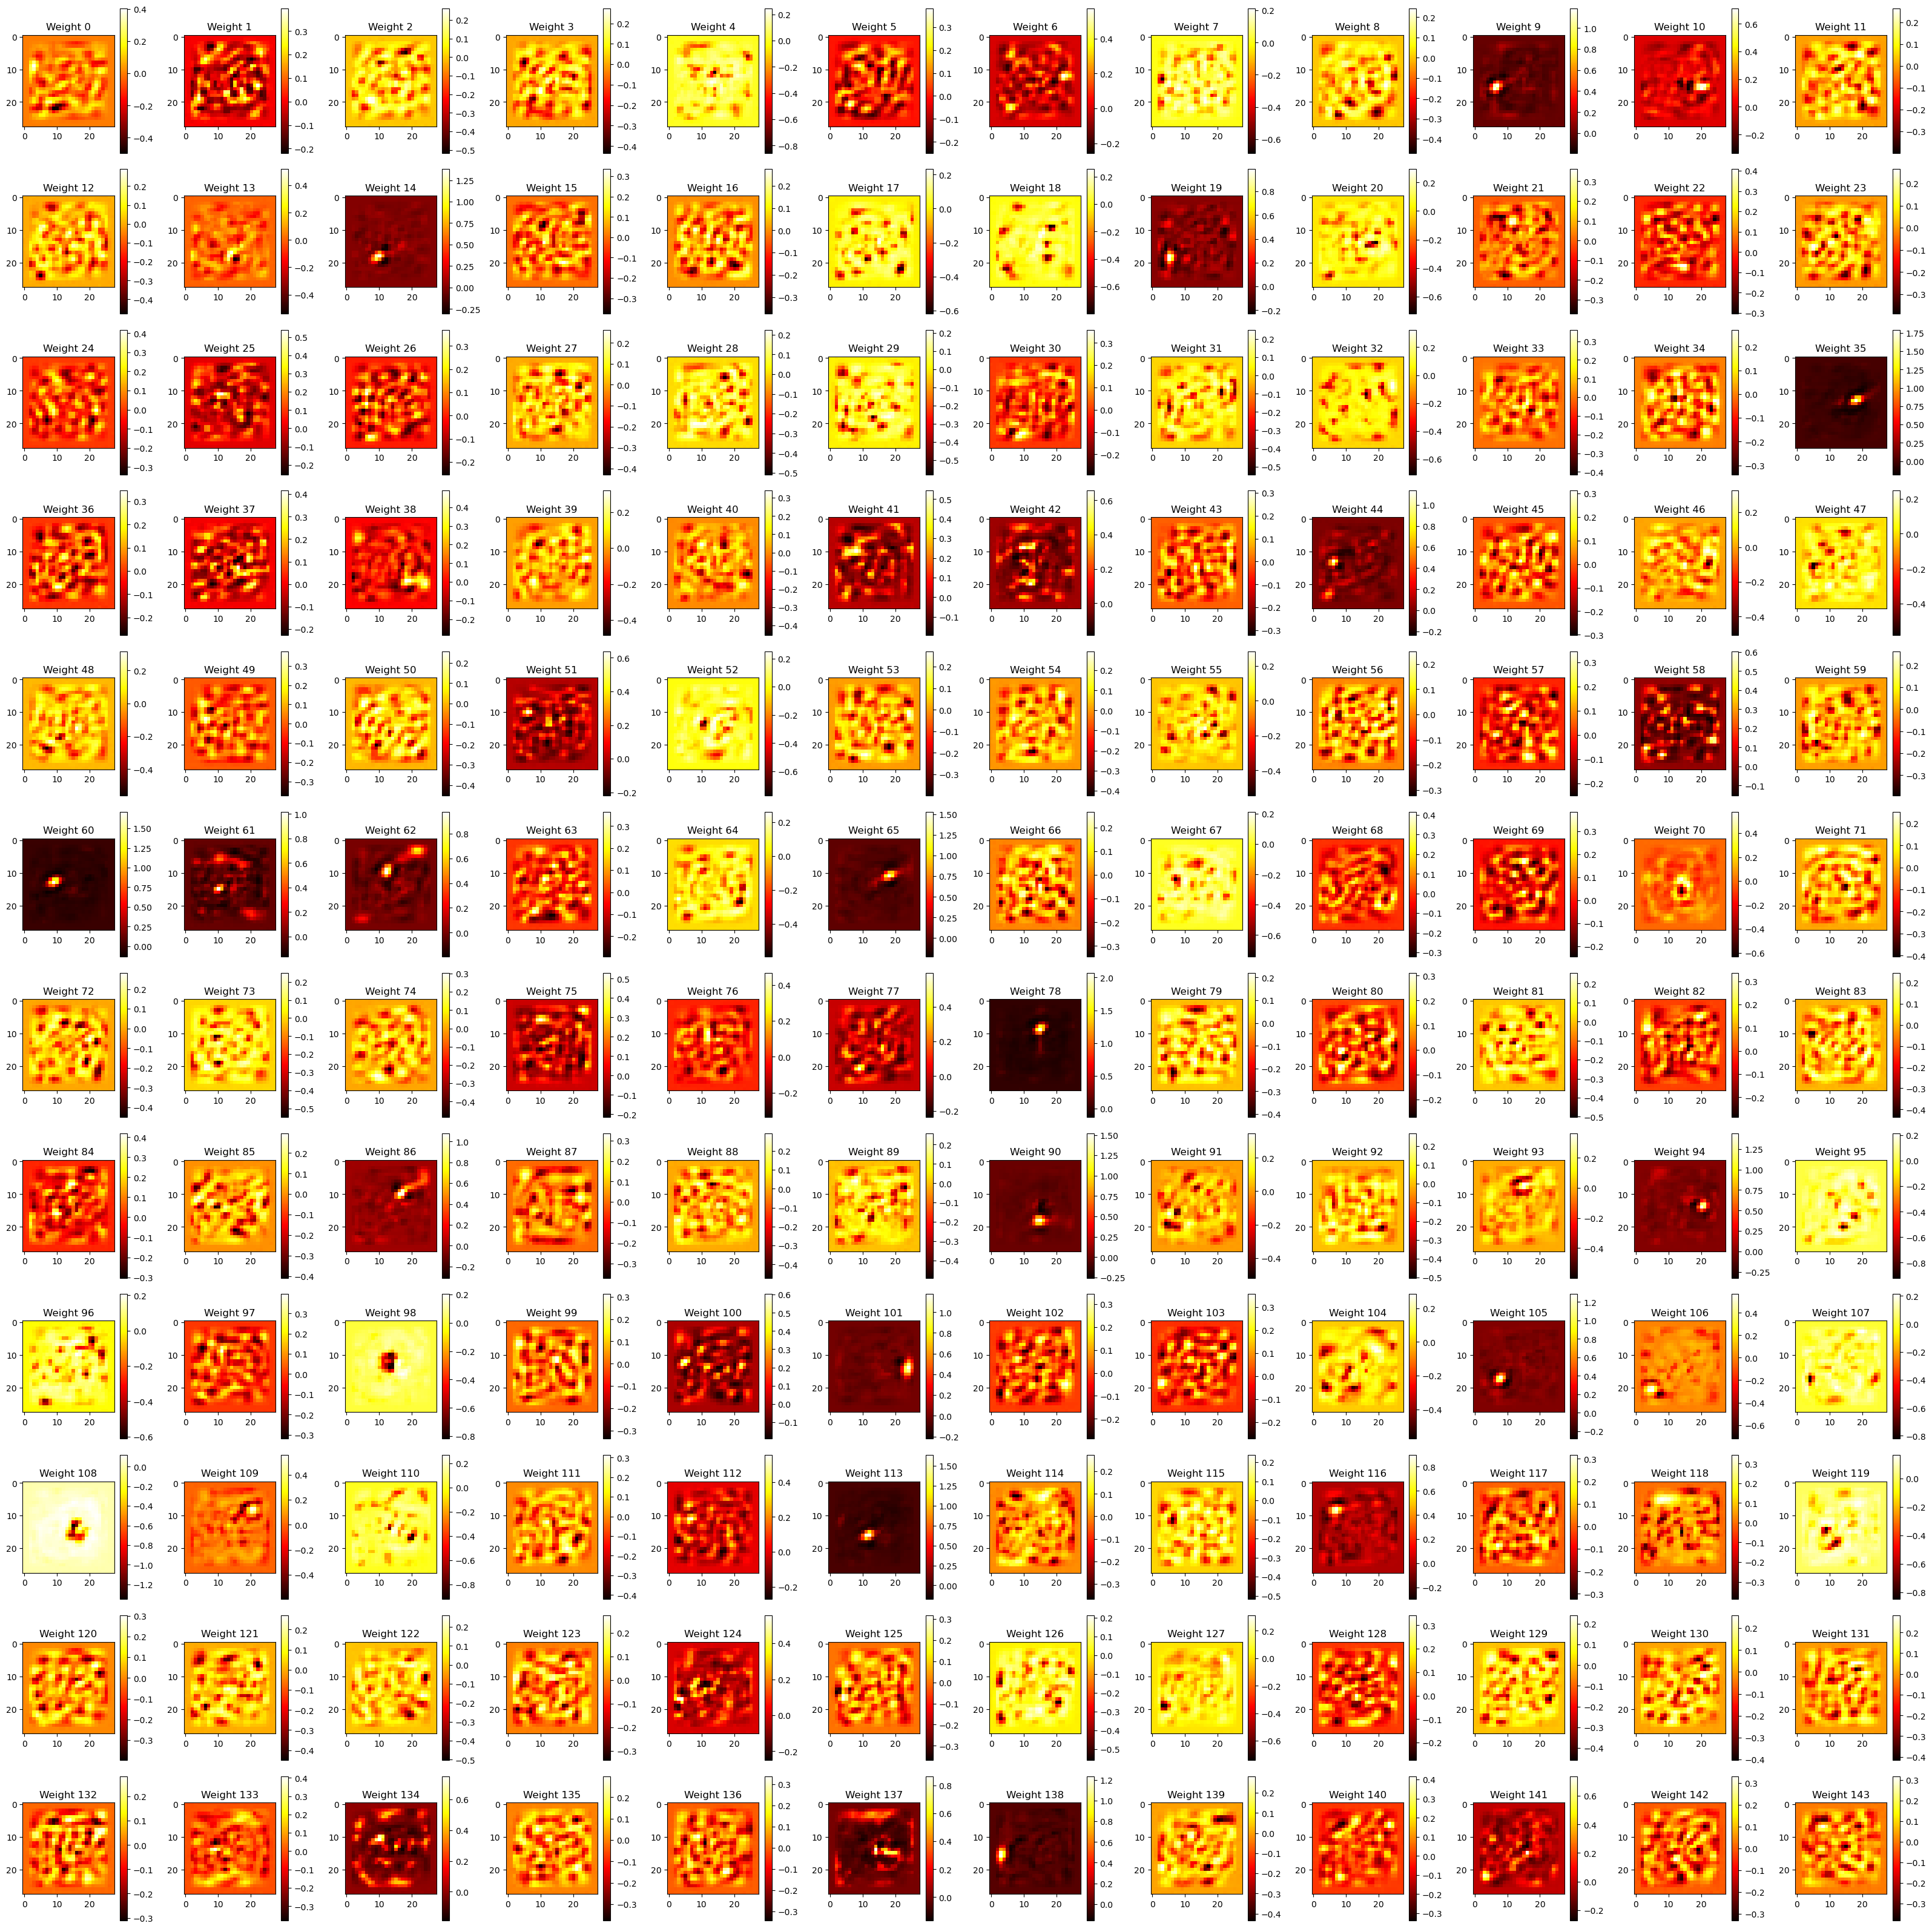

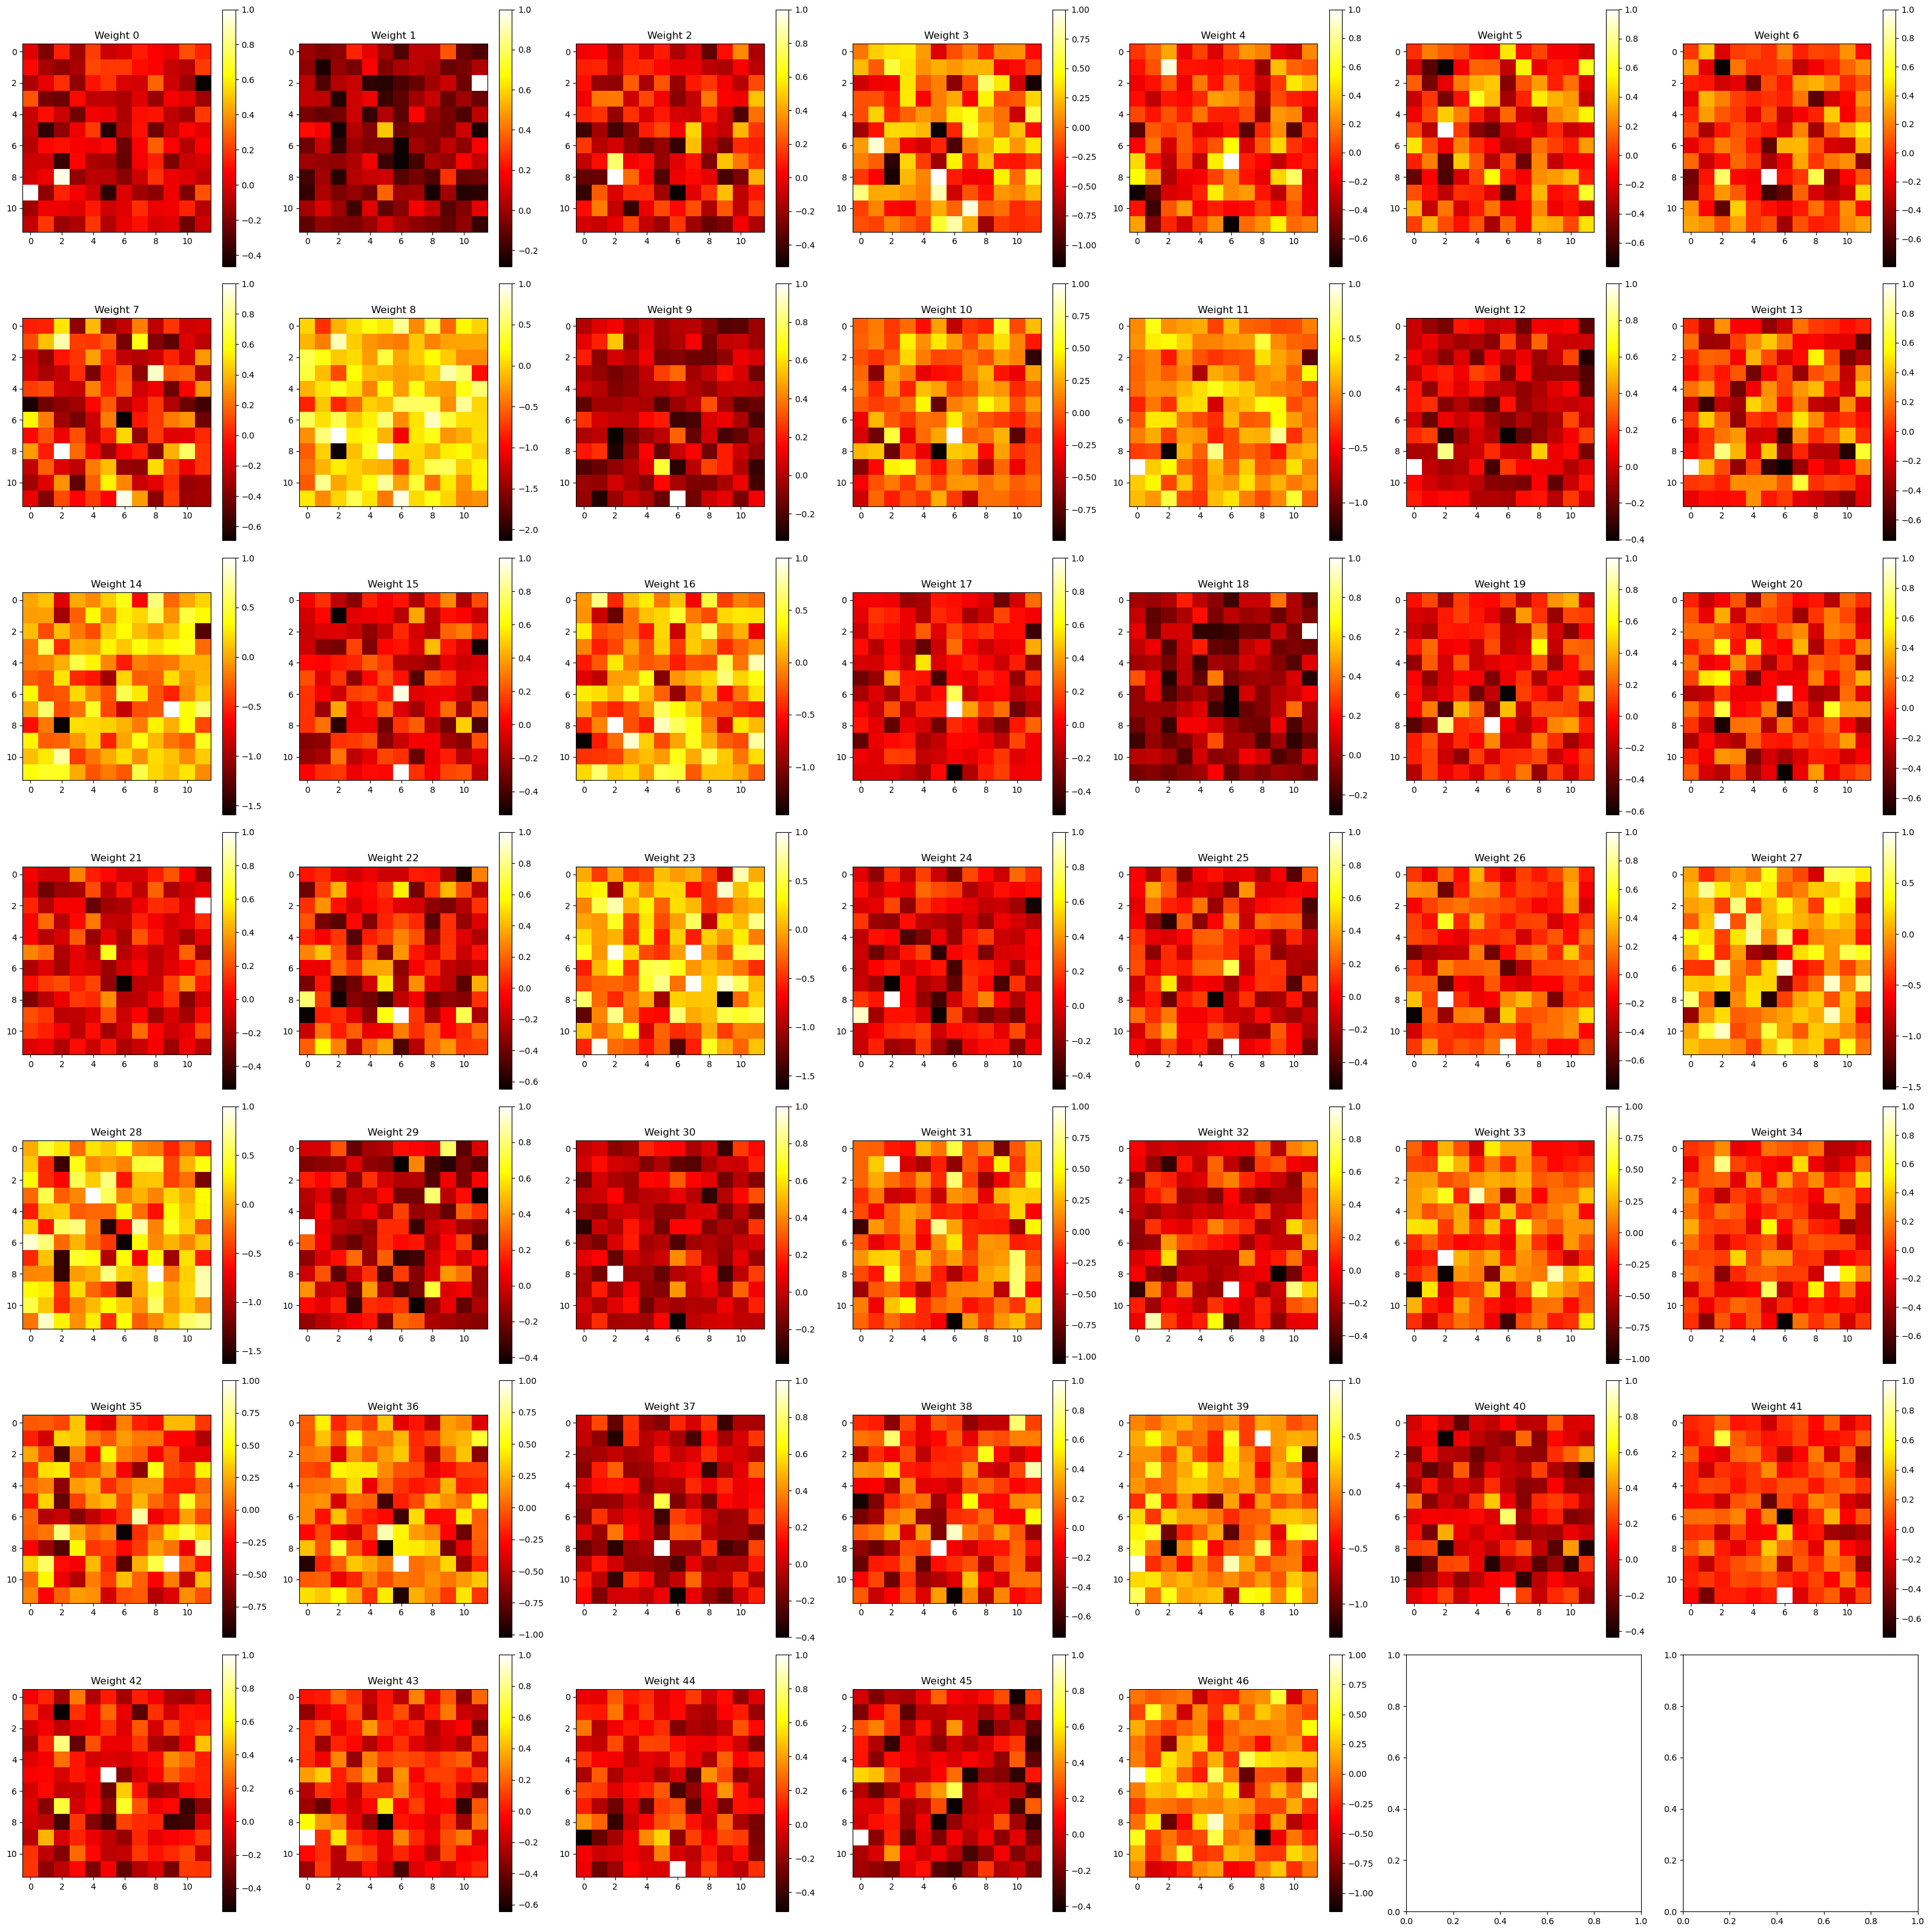

In [232]:
MLPBaseline_EMNIST.visualize_weights()

In [233]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_train_loader))
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_test_loader))

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.529281914893617, {45: (1693, 2400), 36: (1059, 2400), 43: (1621, 2400), 15: (700, 2400), 4: (1300, 2400), 42: (1382, 2400), 26: (1195, 2400), 32: (1859, 2400), 20: (1172, 2400), 1: (986, 2400), 46: (1091, 2400), 13: (1347, 2400), 24: (1212, 2400), 12: (1385, 2400), 5: (1001, 2400), 17: (1045, 2400), 3: (1711, 2400), 40: (1207, 2400), 14: (1299, 2400), 44: (480, 2400), 19: (676, 2400), 29: (1404, 2400), 25: (1588, 2400), 35: (1187, 2400), 28: (1401, 2400), 23: (1511, 2400), 22: (1908, 2400), 34: (993, 2400), 9: (1373, 2400), 30: (961, 2400), 38: (1693, 2400), 39: (1455, 2400), 37: (1594, 2400), 31: (1643, 2400), 16: (1544, 2400), 7: (1833, 2400), 2: (1060, 2400), 8: (1459, 2400), 10: (1644, 2400), 6: (1368, 2400), 27: (1400, 2400), 33: (1539, 2400), 11: (1250, 2400), 18: (684, 2400), 41: (437, 2400), 0: (930, 2400), 21: (423, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5231382978723405, {16: (255, 400), 14: (218, 400), 23: (245, 400), 37: (257, 400), 4: (201, 400), 38: (304, 400), 15: (129, 400), 26: (197, 400), 3: (302, 400), 24: (214, 400), 11: (207, 400), 30: (156, 400), 44: (76, 400), 40: (189, 400), 5: (164, 400), 27: (209, 400), 42: (240, 400), 43: (269, 400), 2: (180, 400), 45: (273, 400), 29: (227, 400), 12: (235, 400), 25: (276, 400), 17: (179, 400), 10: (269, 400), 41: (71, 400), 33: (257, 400), 9: (215, 400), 39: (239, 400), 13: (219, 400), 34: (150, 400), 20: (188, 400), 6: (227, 400), 7: (300, 400), 8: (235, 400), 46: (174, 400), 18: (100, 400), 19: (112, 400), 35: (200, 400), 28: (223, 400), 0: (174, 400), 1: (153, 400), 32: (322, 400), 21: (81, 400), 22: (304, 400), 31: (254, 400), 36: (166, 400)})


In [222]:
MLPBaseline_EMNIST = MLPBaseline_Experiment(hsize=64, lamb=15, lr=0.005, learning=Learning.FullyOrthogonal, e=0.01, dataloader=emnist_train_loader, nclasses=47)

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

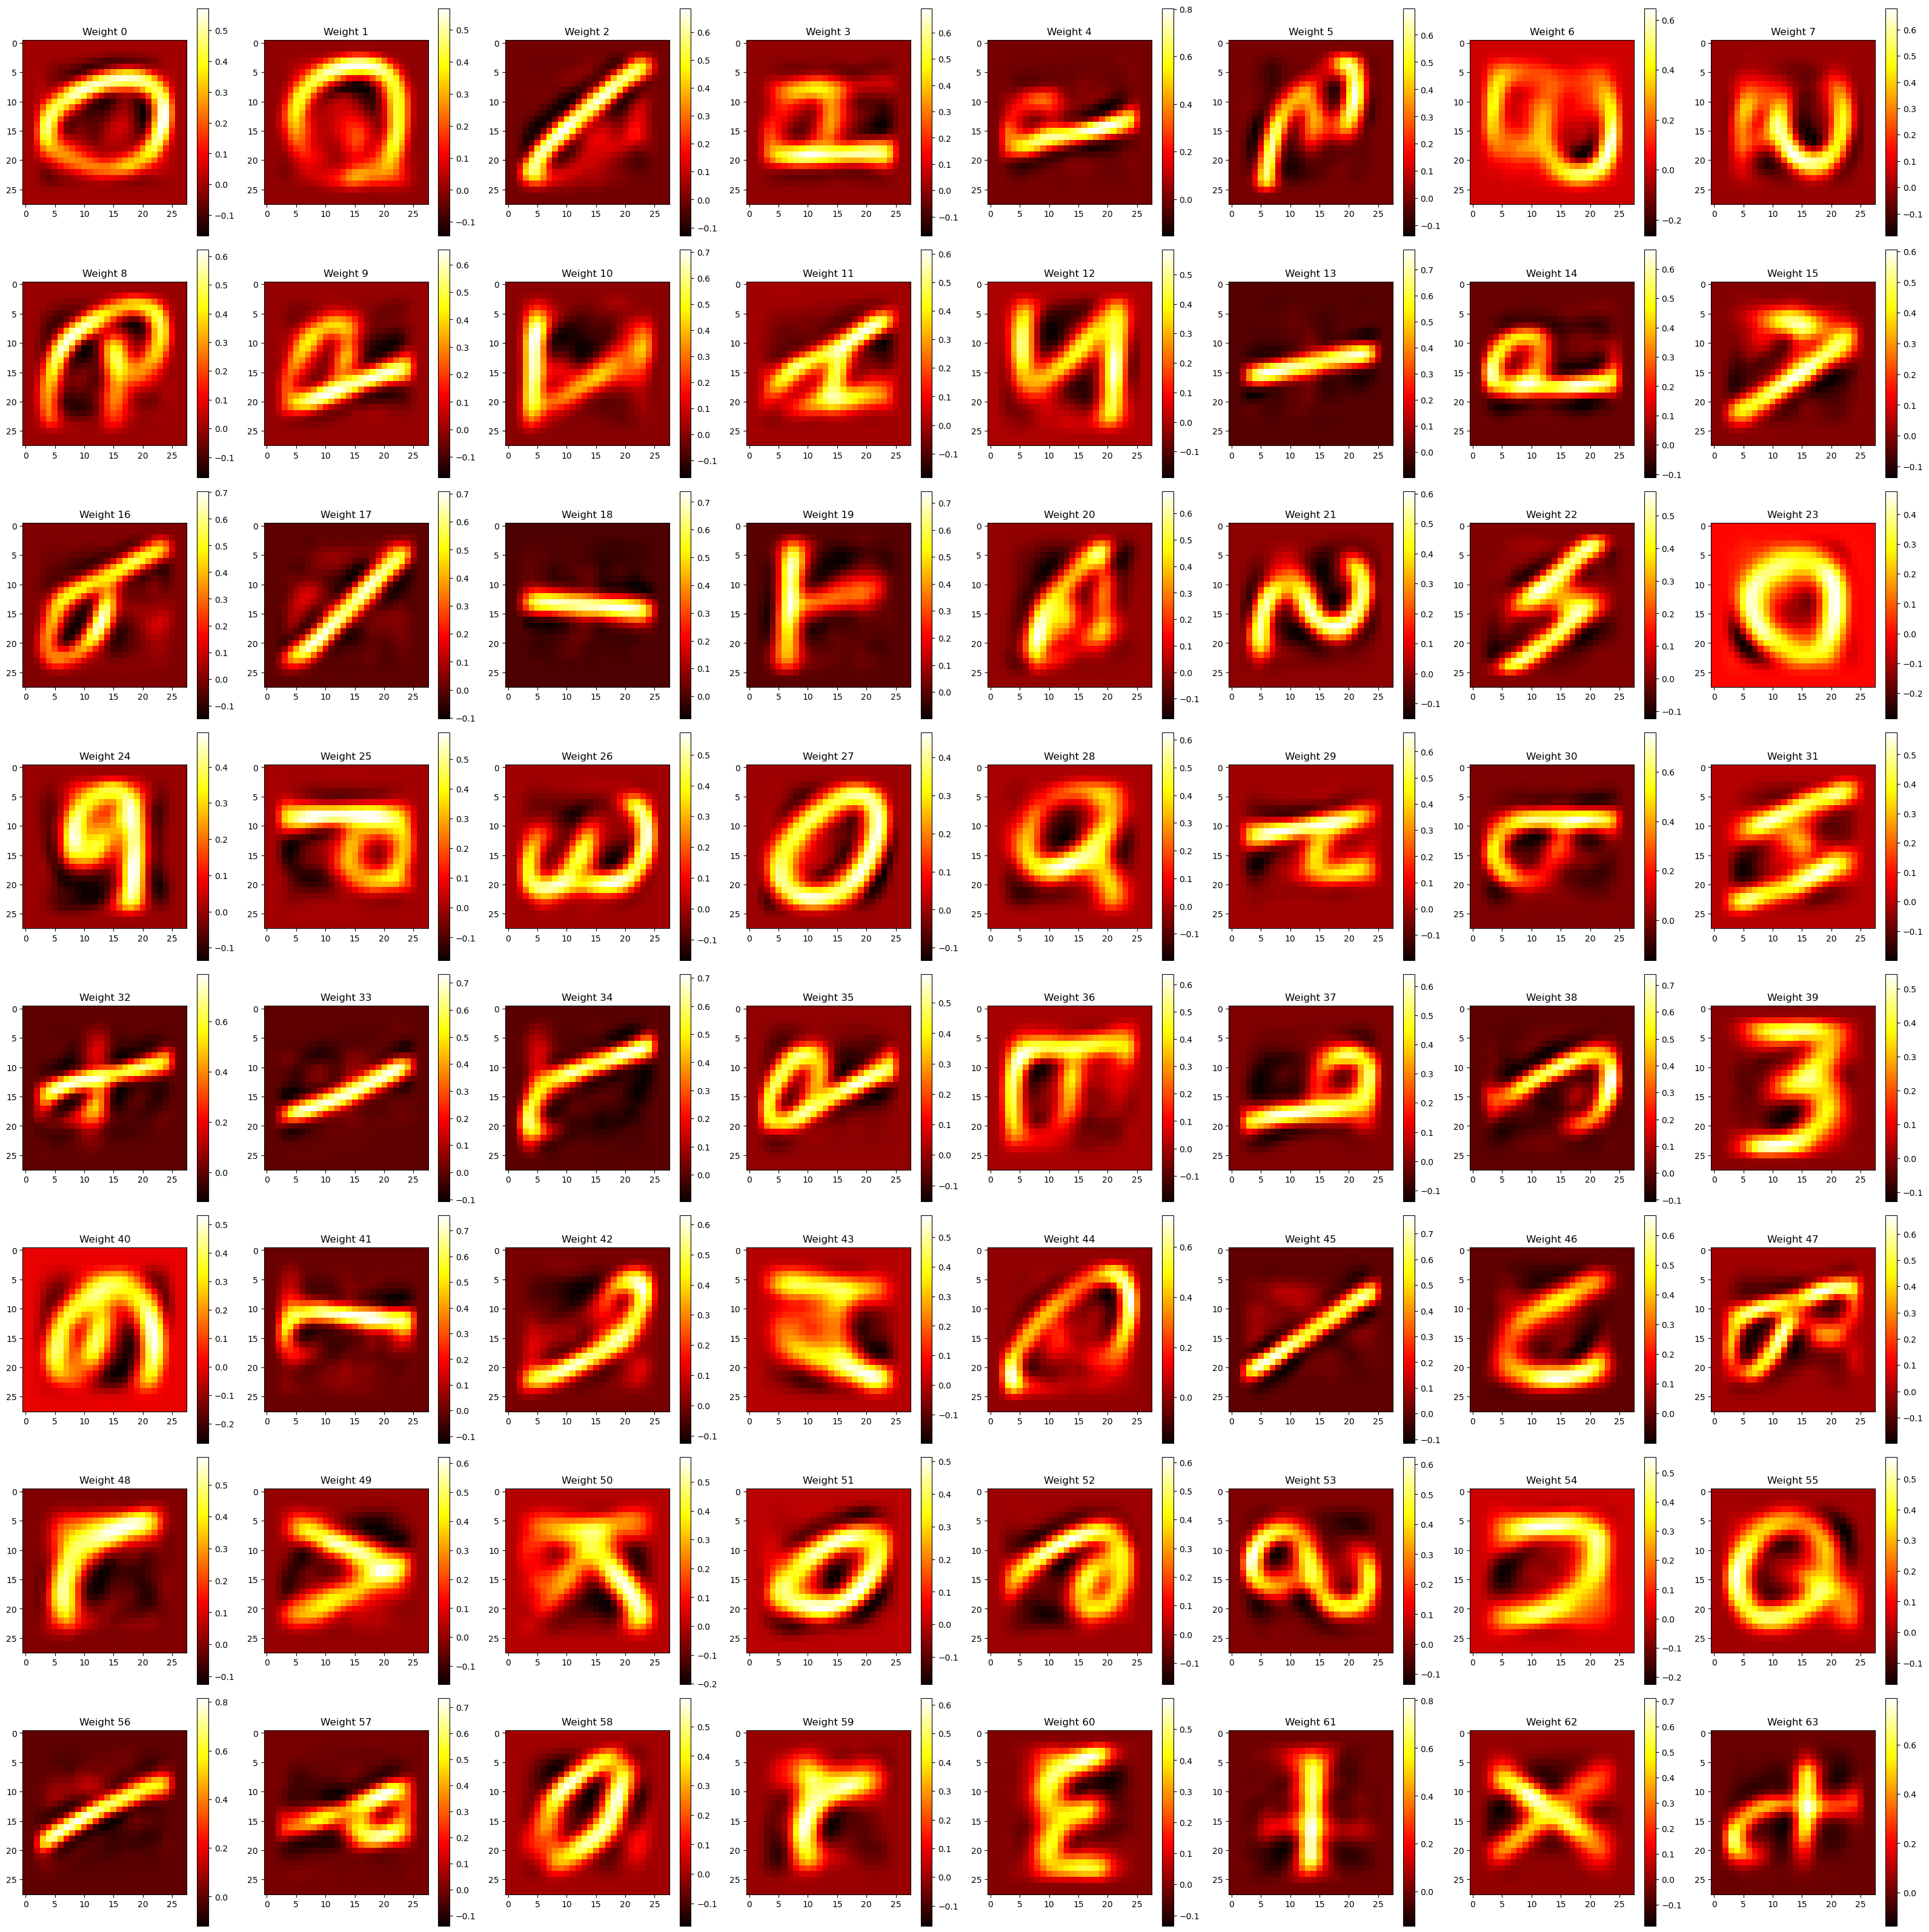

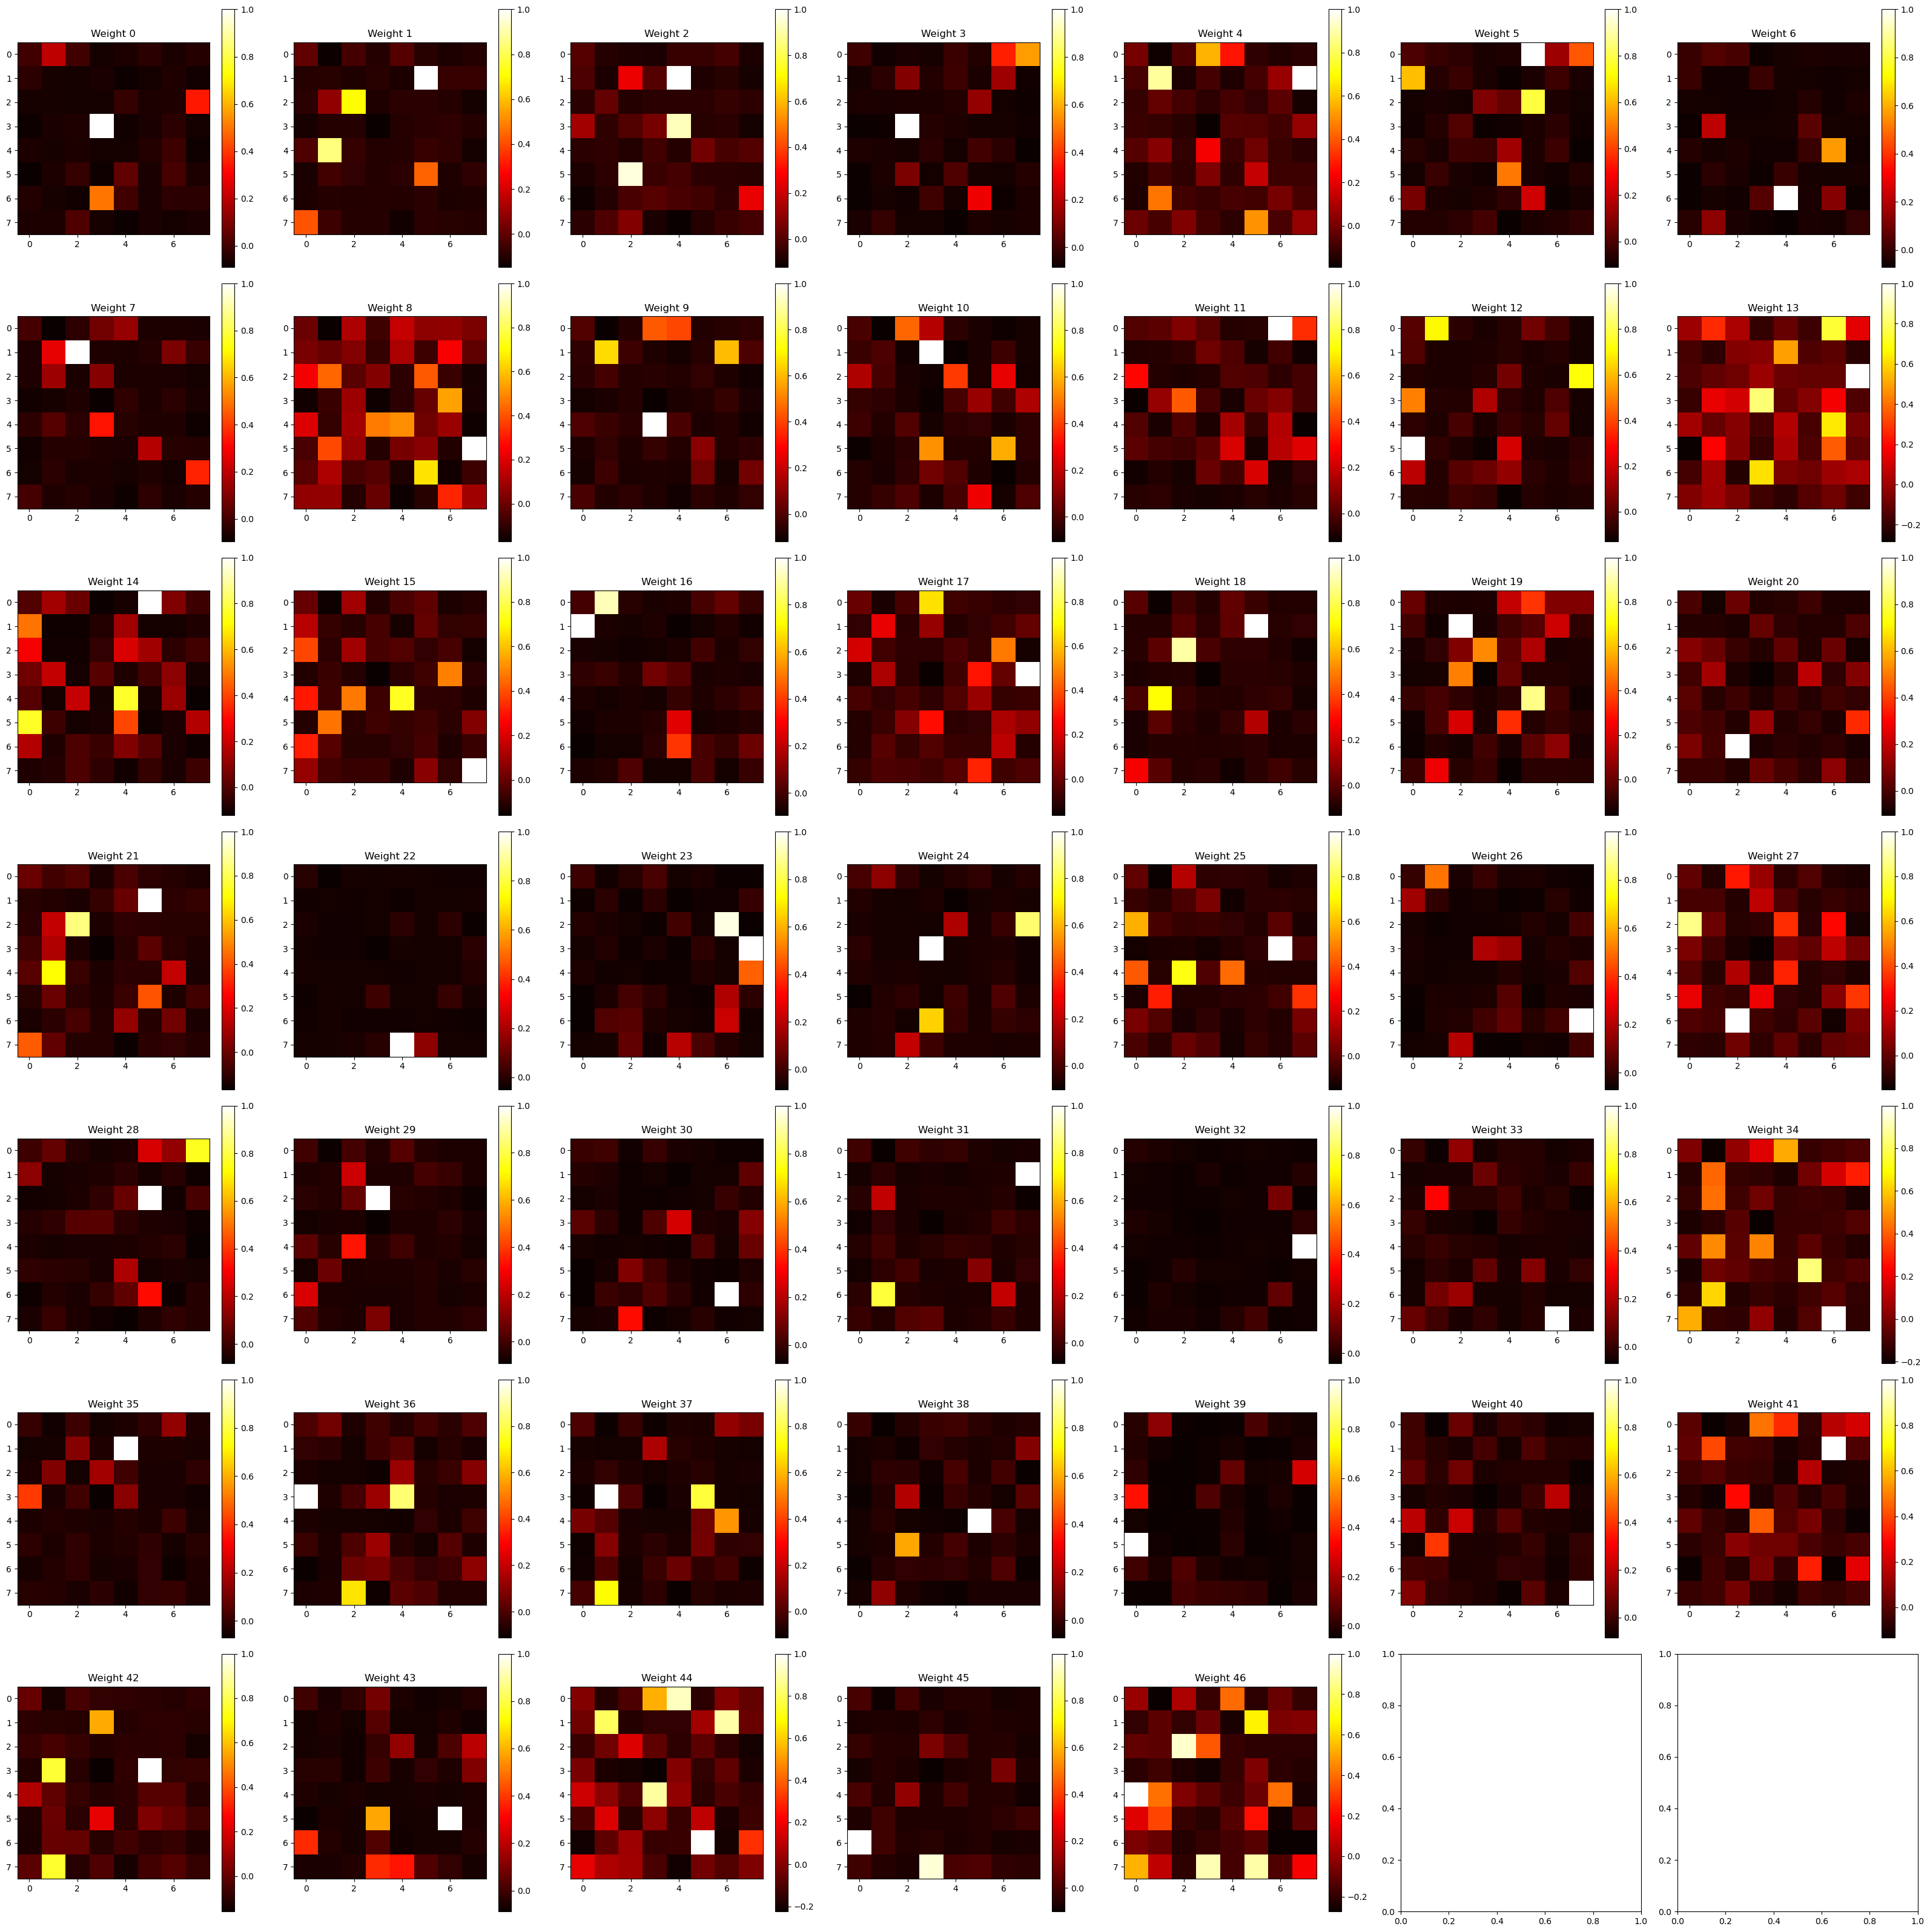

In [223]:
MLPBaseline_EMNIST.visualize_weights()

In [224]:
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_train_loader))
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST, emnist_test_loader))

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.3749468085106383, {45: (1762, 2400), 36: (1363, 2400), 43: (1394, 2400), 15: (242, 2400), 4: (1073, 2400), 42: (1099, 2400), 26: (967, 2400), 32: (1685, 2400), 20: (634, 2400), 1: (1209, 2400), 46: (878, 2400), 13: (587, 2400), 24: (1115, 2400), 12: (637, 2400), 5: (503, 2400), 17: (1010, 2400), 3: (1156, 2400), 40: (630, 2400), 14: (1122, 2400), 44: (944, 2400), 19: (647, 2400), 29: (953, 2400), 25: (1014, 2400), 35: (189, 2400), 28: (1226, 2400), 23: (943, 2400), 22: (1862, 2400), 34: (834, 2400), 9: (506, 2400), 30: (969, 2400), 38: (906, 2400), 39: (509, 2400), 37: (724, 2400), 31: (679, 2400), 16: (1202, 2400), 7: (774, 2400), 2: (1435, 2400), 8: (721, 2400), 10: (947, 2400), 6: (1291, 2400), 27: (723, 2400), 33: (320, 2400), 11: (986, 2400), 18: (735, 2400), 41: (382, 2400), 0: (807, 2400), 21: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.3720212765957447, {38: (158, 400), 15: (35, 400), 44: (148, 400), 0: (149, 400), 32: (293, 400), 12: (113, 400), 42: (188, 400), 3: (213, 400), 19: (104, 400), 35: (20, 400), 16: (208, 400), 22: (304, 400), 31: (107, 400), 43: (223, 400), 46: (151, 400), 24: (197, 400), 13: (117, 400), 33: (45, 400), 21: (1, 400), 29: (137, 400), 30: (156, 400), 23: (161, 400), 7: (140, 400), 18: (118, 400), 14: (195, 400), 45: (282, 400), 41: (59, 400), 40: (88, 400), 20: (100, 400), 26: (171, 400), 4: (193, 400), 11: (164, 400), 9: (79, 400), 39: (84, 400), 10: (163, 400), 1: (184, 400), 37: (128, 400), 34: (135, 400), 6: (214, 400), 5: (80, 400), 36: (214, 400), 27: (109, 400), 28: (197, 400), 25: (157, 400), 17: (179, 400), 2: (229, 400), 8: (104, 400)})


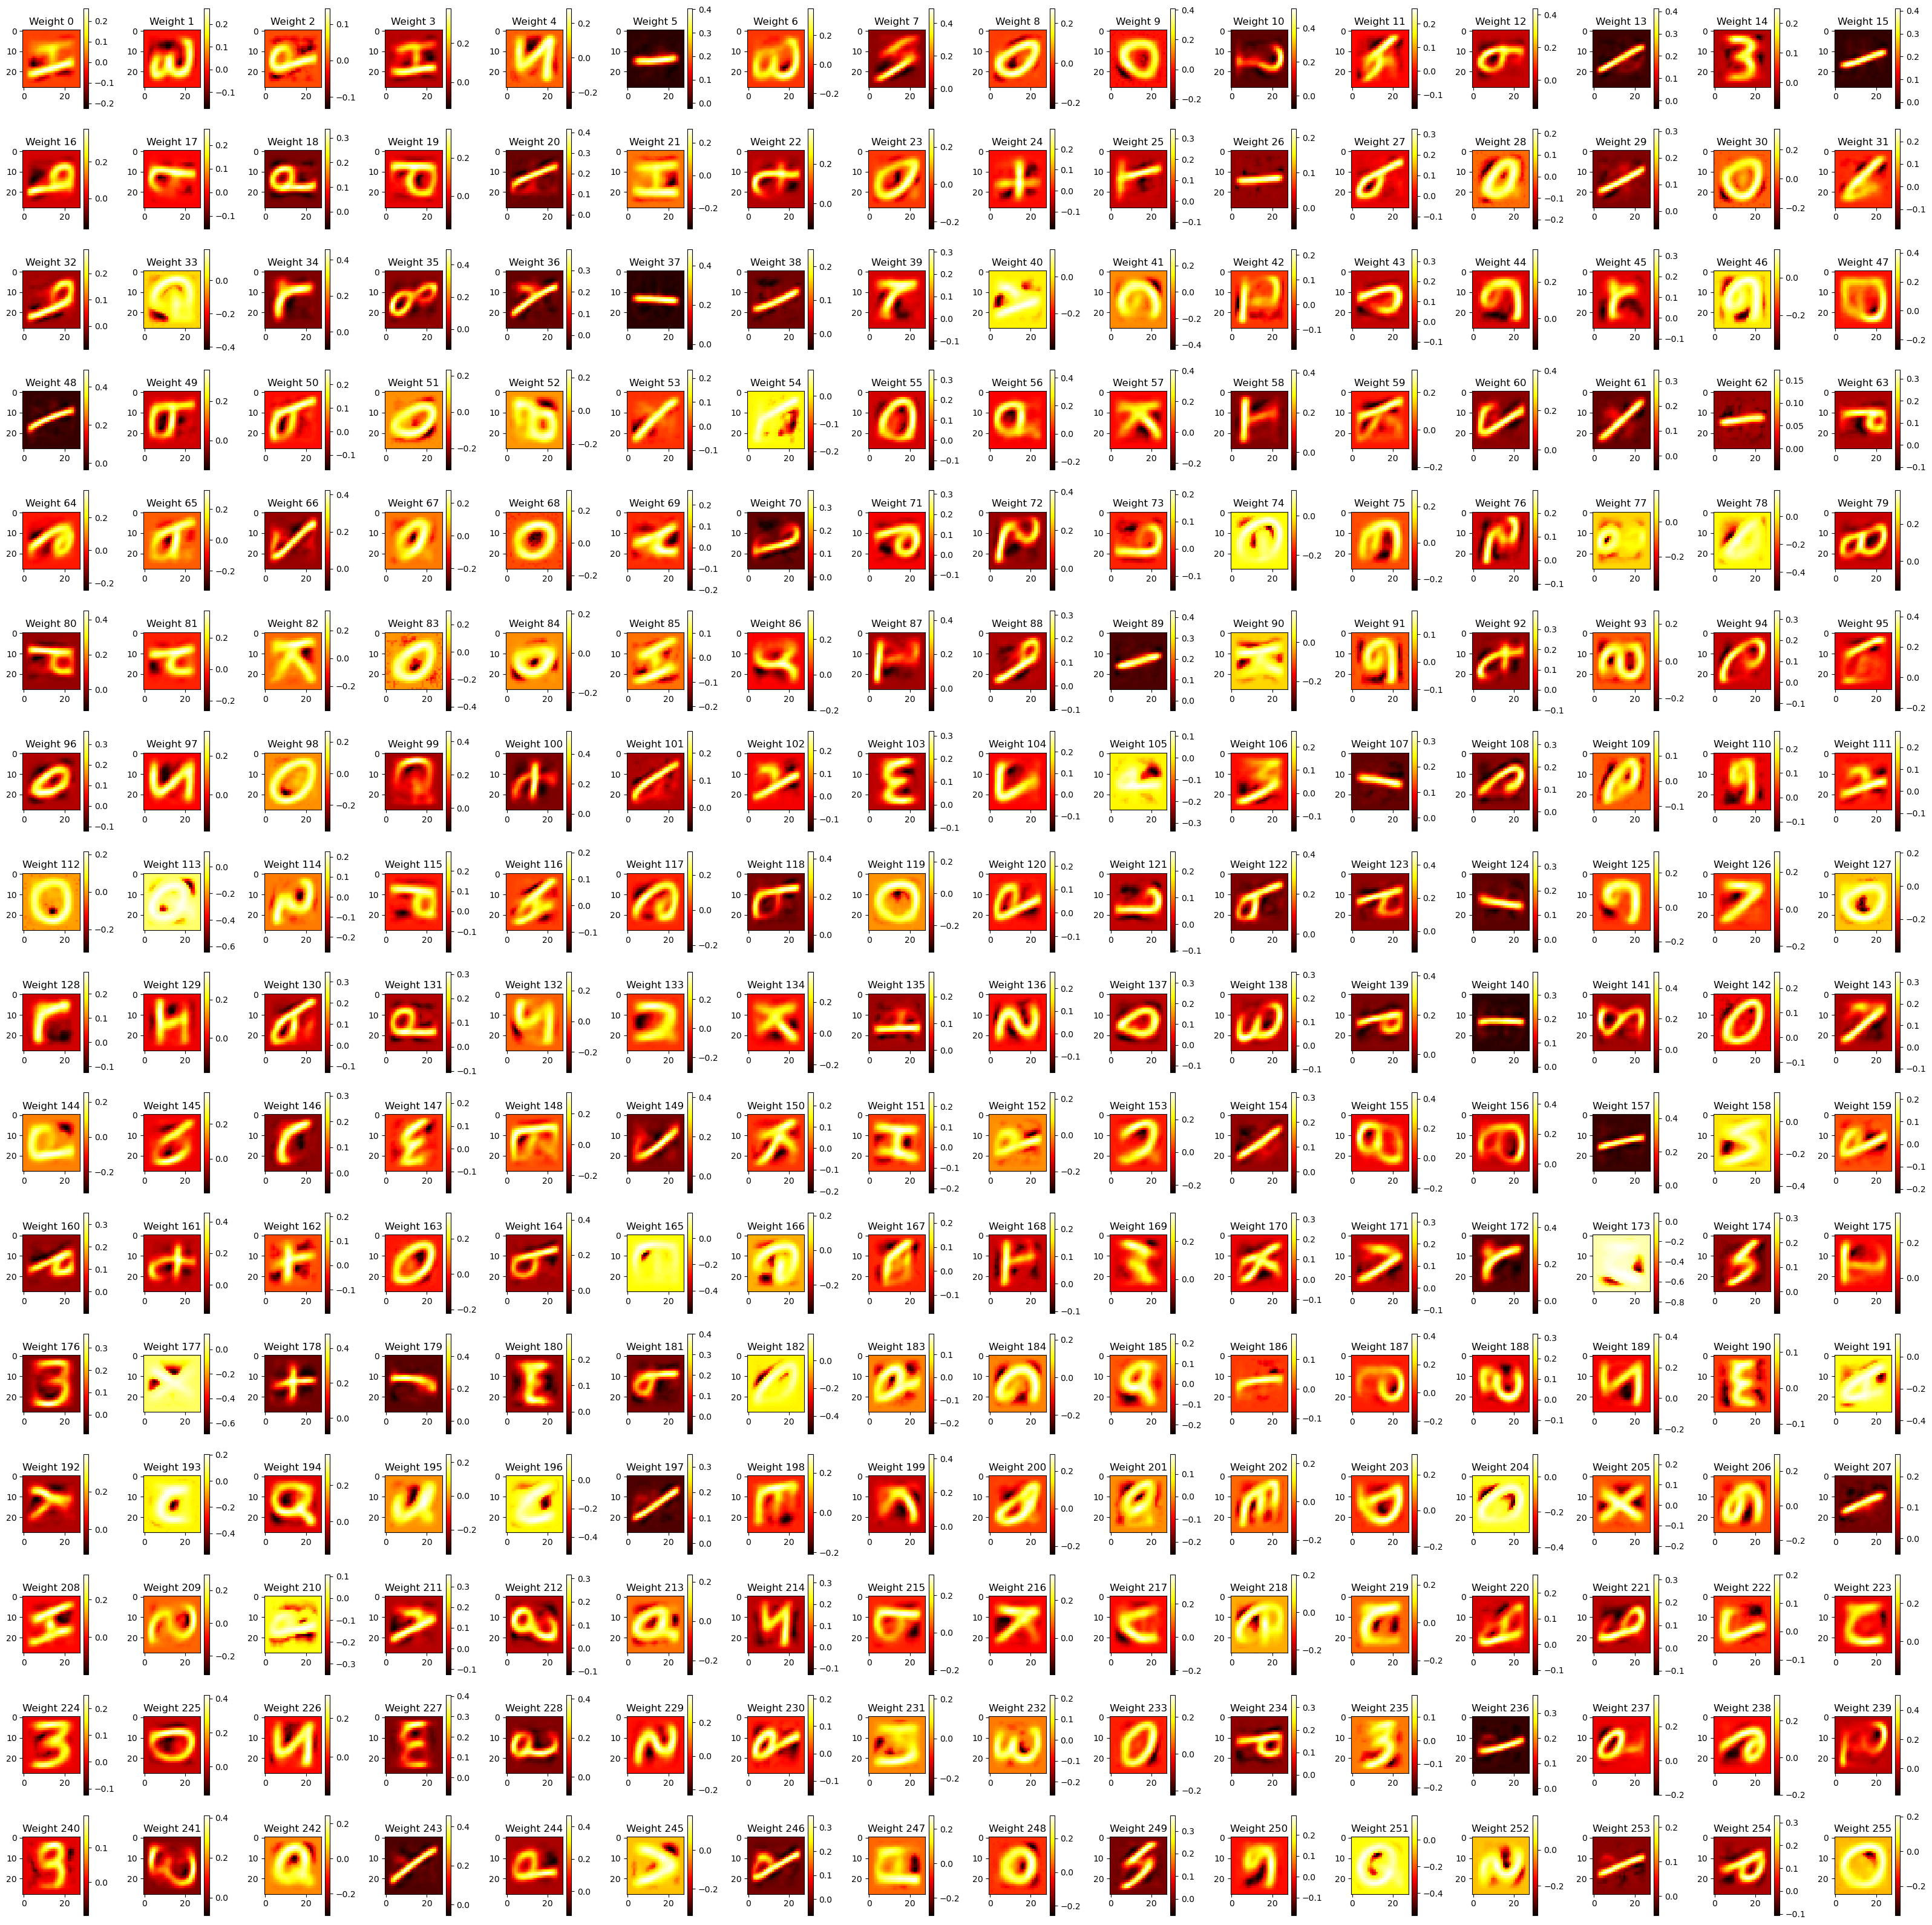

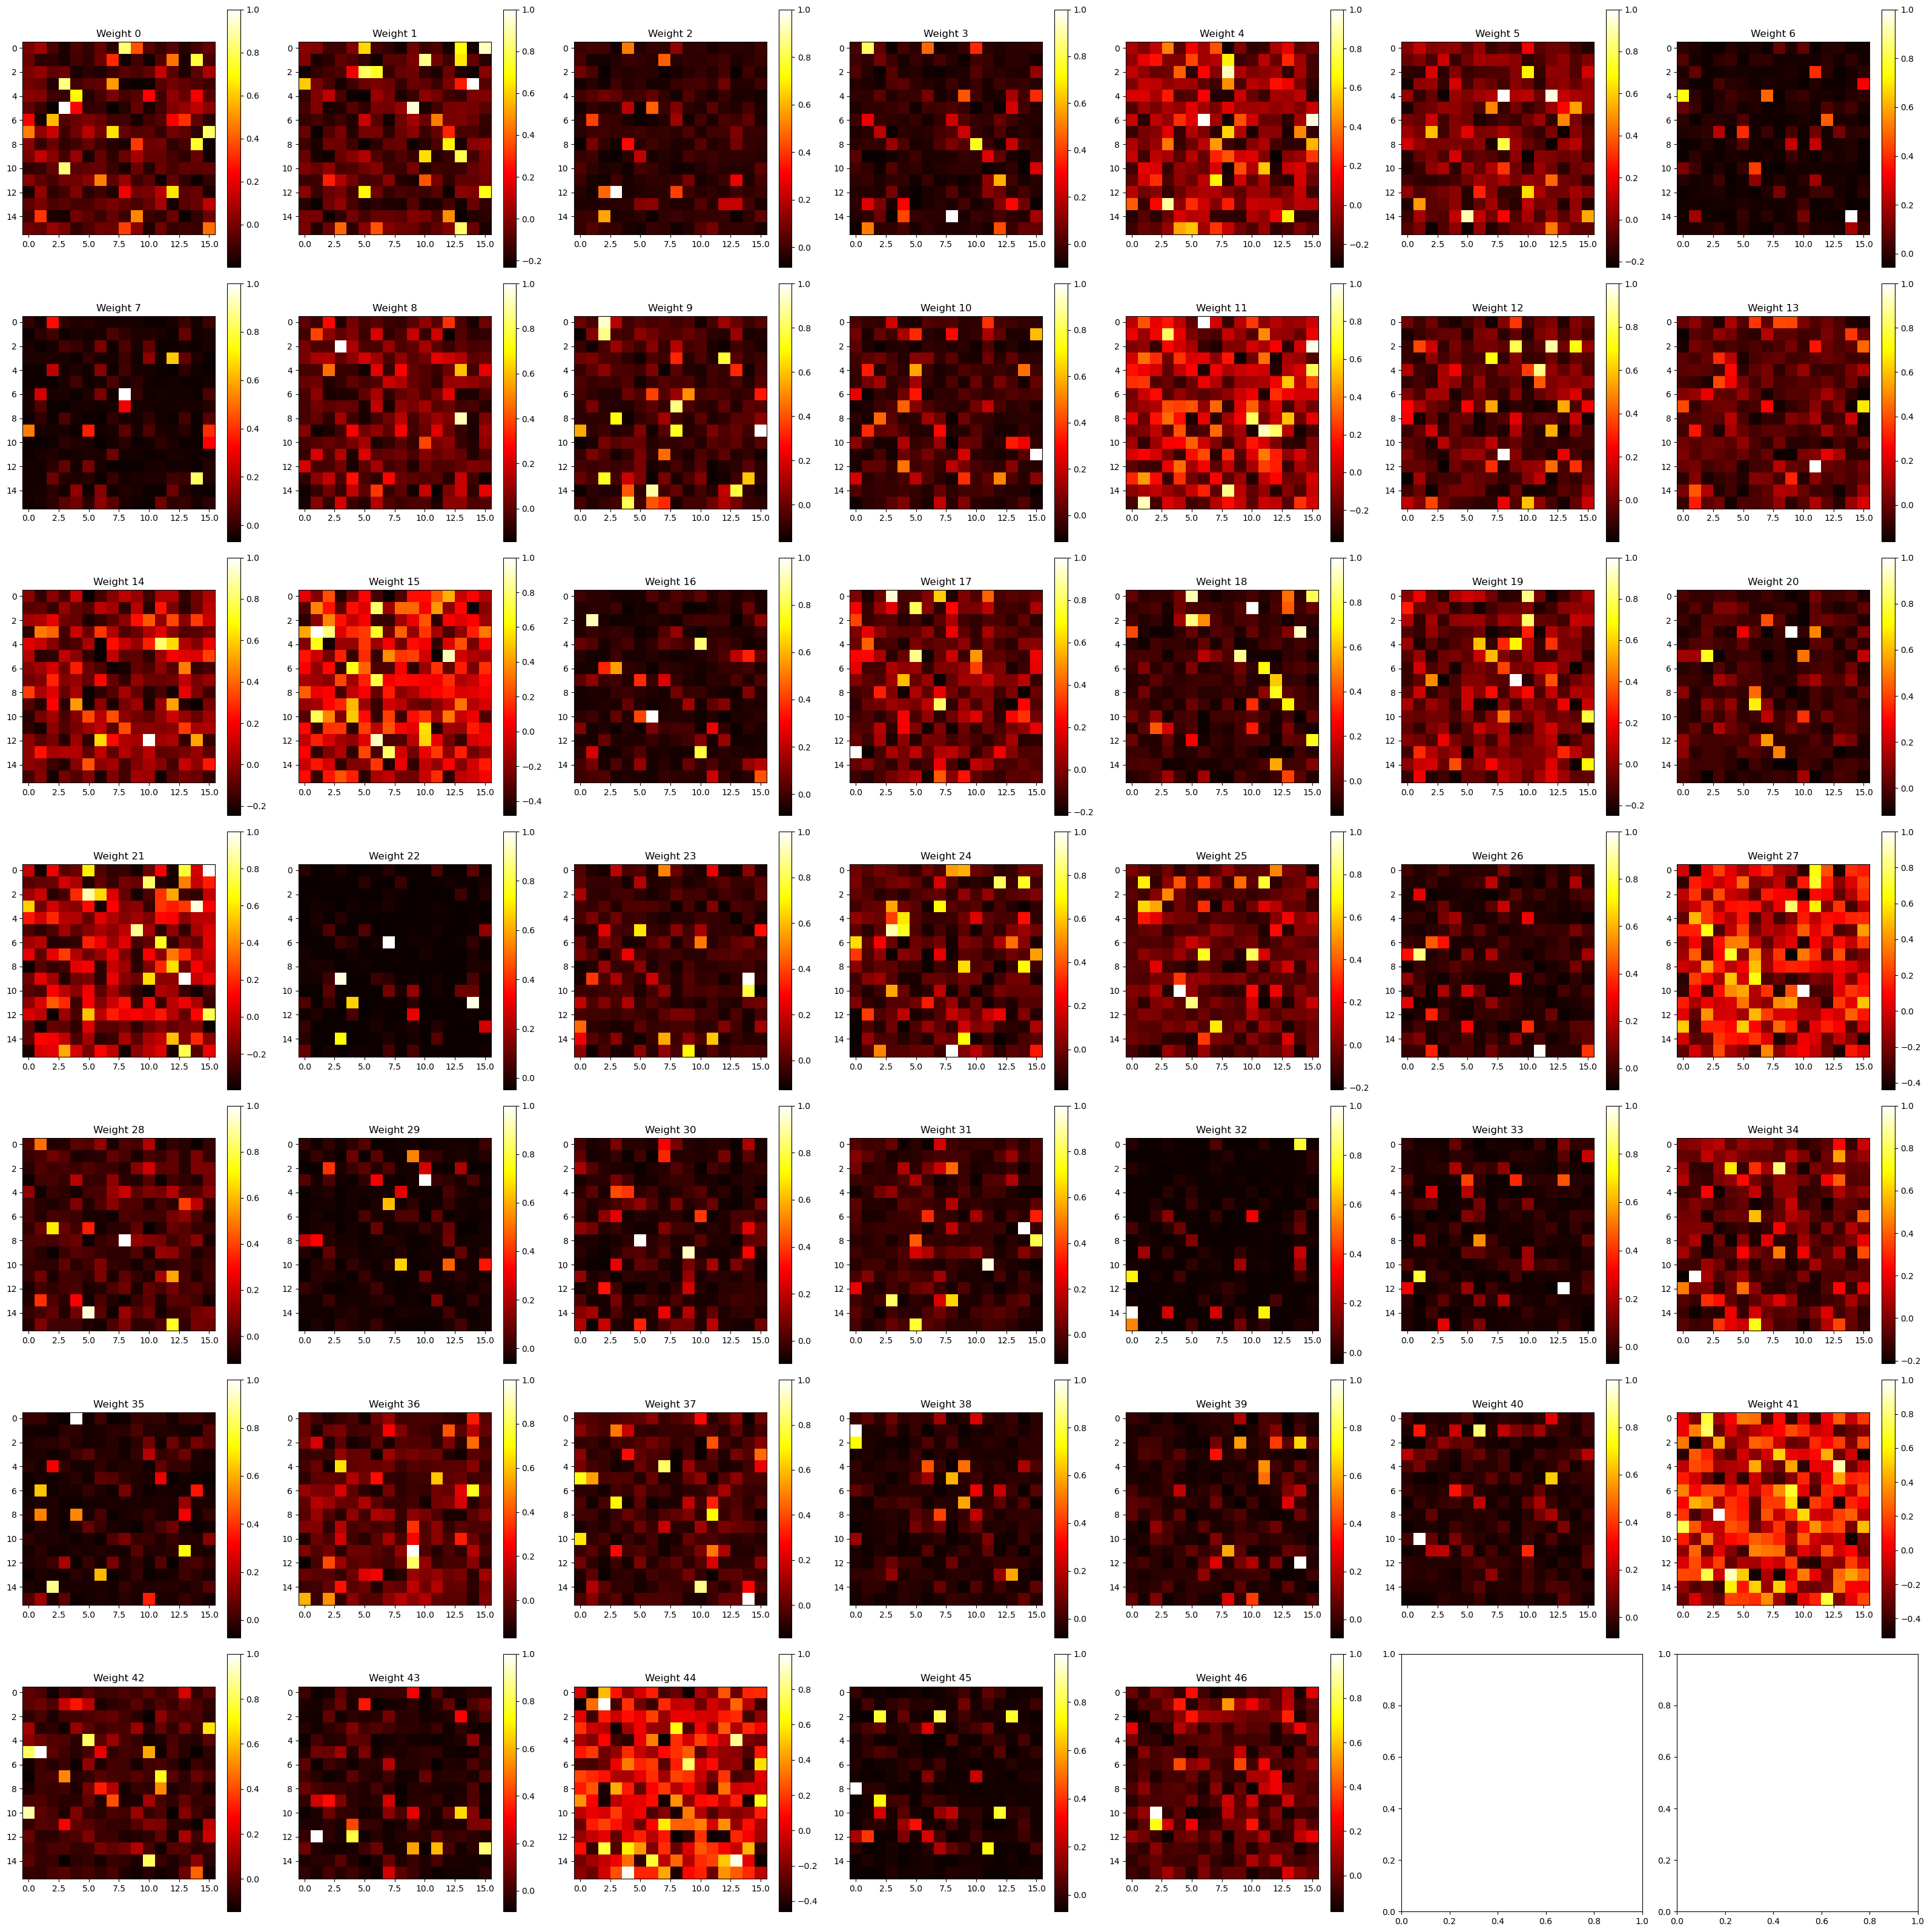

In [44]:
MLPBaseline_EMNIST.visualize_weights()

### Noise Experiment

### Gaussian Noise

#### Noise level 1-5 visualization

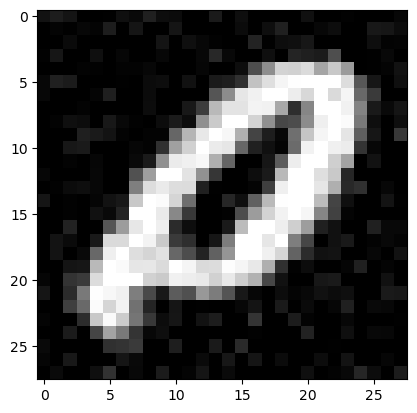

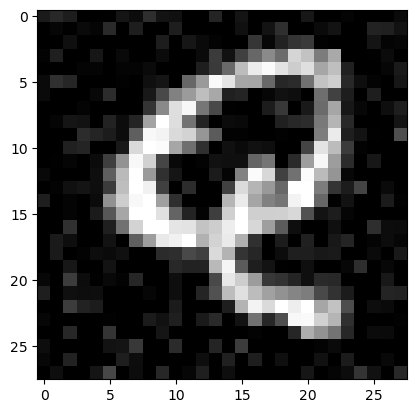

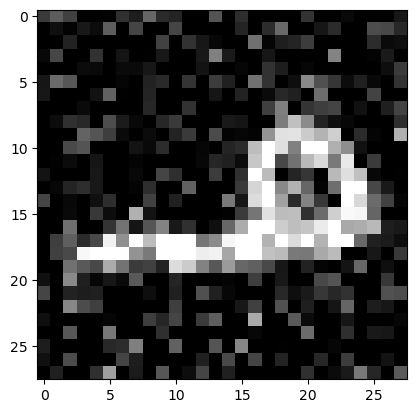

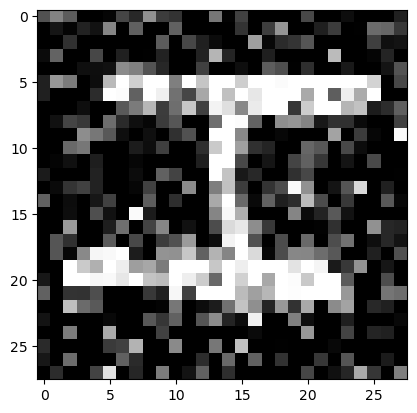

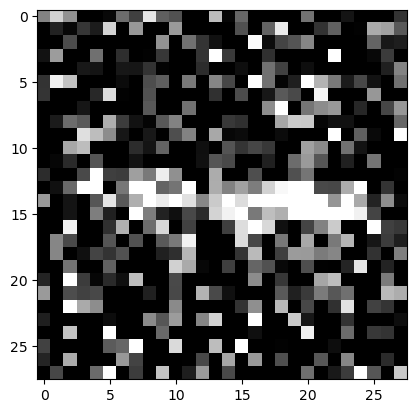

In [205]:
for idx in range(5):
    for data in emnist_test_dataloader_gaussian[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

#### Memory patterns

In [200]:
for idx in range(5):
    MLPBaseline_EMNIST_Gaussian = MLPBaseline_Experiment(256, 15, 0.005, Learning.FullyOrthogonal, 0.01, emnist_train_dataloader_gaussian[idx], 47)
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_train_dataloader_gaussian[idx]))
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_test_dataloader_gaussian[idx]))

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5445744680851063, {43: (1239, 2400), 37: (1500, 2400), 9: (704, 2400), 44: (1047, 2400), 19: (1093, 2400), 34: (1083, 2400), 12: (1484, 2400), 41: (876, 2400), 11: (1374, 2400), 29: (1663, 2400), 0: (855, 2400), 17: (1481, 2400), 16: (1361, 2400), 24: (1497, 2400), 39: (1448, 2400), 25: (1482, 2400), 31: (1490, 2400), 2: (1277, 2400), 4: (1215, 2400), 6: (1810, 2400), 3: (1853, 2400), 8: (1177, 2400), 18: (641, 2400), 46: (990, 2400), 1: (1636, 2400), 23: (1340, 2400), 42: (1273, 2400), 26: (1364, 2400), 27: (644, 2400), 10: (1407, 2400), 45: (1659, 2400), 7: (1768, 2400), 28: (1394, 2400), 20: (1744, 2400), 14: (1055, 2400), 40: (1363, 2400), 35: (1683, 2400), 13: (906, 2400), 22: (2064, 2400), 33: (1305, 2400), 38: (1727, 2400), 5: (1132, 2400), 32: (1857, 2400), 15: (668, 2400), 30: (1248, 2400), 21: (501, 2400), 36: (1050, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5398404255319149, {18: (110, 400), 46: (172, 400), 17: (247, 400), 33: (201, 400), 37: (248, 400), 35: (293, 400), 45: (278, 400), 9: (118, 400), 29: (267, 400), 42: (210, 400), 23: (209, 400), 3: (330, 400), 8: (198, 400), 20: (307, 400), 34: (172, 400), 7: (306, 400), 31: (233, 400), 24: (242, 400), 38: (293, 400), 4: (198, 400), 22: (338, 400), 32: (328, 400), 41: (156, 400), 2: (227, 400), 44: (168, 400), 27: (87, 400), 21: (97, 400), 43: (189, 400), 36: (164, 400), 12: (260, 400), 1: (264, 400), 40: (218, 400), 28: (229, 400), 14: (188, 400), 15: (104, 400), 19: (160, 400), 6: (293, 400), 30: (197, 400), 10: (222, 400), 16: (211, 400), 13: (146, 400), 25: (233, 400), 0: (152, 400), 26: (236, 400), 11: (242, 400), 39: (227, 400), 5: (181, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.546595744680851, {27: (1191, 2400), 6: (1886, 2400), 33: (1578, 2400), 29: (1727, 2400), 46: (923, 2400), 17: (1241, 2400), 23: (1508, 2400), 25: (1505, 2400), 20: (1280, 2400), 2: (1411, 2400), 3: (1759, 2400), 14: (893, 2400), 18: (286, 2400), 13: (1150, 2400), 11: (1320, 2400), 21: (669, 2400), 38: (1663, 2400), 19: (932, 2400), 9: (878, 2400), 42: (1547, 2400), 26: (754, 2400), 43: (1298, 2400), 12: (1750, 2400), 36: (1429, 2400), 31: (1656, 2400), 1: (1690, 2400), 15: (908, 2400), 10: (1380, 2400), 37: (1100, 2400), 28: (1379, 2400), 41: (732, 2400), 24: (1724, 2400), 44: (1346, 2400), 22: (2038, 2400), 45: (1768, 2400), 4: (737, 2400), 16: (1635, 2400), 40: (1155, 2400), 35: (1821, 2400), 5: (1249, 2400), 32: (1893, 2400), 30: (1377, 2400), 0: (570, 2400), 34: (745, 2400), 8: (1046, 2400), 39: (1415, 2400), 7: (1714, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.543936170212766, {6: (309, 400), 44: (220, 400), 0: (99, 400), 42: (247, 400), 15: (134, 400), 35: (302, 400), 30: (234, 400), 10: (218, 400), 19: (149, 400), 20: (232, 400), 37: (185, 400), 4: (135, 400), 26: (138, 400), 17: (214, 400), 36: (230, 400), 12: (295, 400), 34: (116, 400), 33: (255, 400), 14: (162, 400), 27: (180, 400), 28: (226, 400), 1: (271, 400), 7: (289, 400), 46: (162, 400), 3: (319, 400), 25: (243, 400), 11: (221, 400), 31: (272, 400), 18: (45, 400), 24: (289, 400), 16: (274, 400), 38: (290, 400), 9: (145, 400), 8: (159, 400), 13: (181, 400), 40: (175, 400), 21: (122, 400), 32: (325, 400), 29: (279, 400), 2: (238, 400), 39: (226, 400), 45: (288, 400), 5: (214, 400), 23: (246, 400), 41: (128, 400), 43: (210, 400), 22: (335, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.4199911347517731, {37: (1025, 2400), 40: (915, 2400), 44: (760, 2400), 4: (1290, 2400), 16: (922, 2400), 34: (1338, 2400), 15: (649, 2400), 24: (1006, 2400), 1: (50, 2400), 36: (861, 2400), 12: (142, 2400), 21: (104, 2400), 42: (1262, 2400), 17: (1328, 2400), 26: (718, 2400), 20: (991, 2400), 7: (1230, 2400), 22: (879, 2400), 6: (1284, 2400), 46: (875, 2400), 25: (1262, 2400), 38: (1373, 2400), 13: (910, 2400), 3: (1089, 2400), 11: (1560, 2400), 18: (1200, 2400), 9: (771, 2400), 35: (1137, 2400), 45: (761, 2400), 41: (790, 2400), 33: (1253, 2400), 2: (1394, 2400), 5: (797, 2400), 39: (1304, 2400), 28: (1365, 2400), 31: (968, 2400), 32: (187, 2400), 10: (1250, 2400), 23: (914, 2400), 19: (462, 2400), 14: (1811, 2400), 29: (1757, 2400), 8: (1290, 2400), 30: (1216, 2400), 43: (787, 2400), 0: (727, 2400), 27: (1411, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4229255319148936, {32: (36, 400), 6: (209, 400), 20: (169, 400), 3: (205, 400), 35: (190, 400), 40: (148, 400), 12: (25, 400), 17: (230, 400), 0: (150, 400), 14: (314, 400), 22: (144, 400), 1: (12, 400), 16: (172, 400), 42: (222, 400), 38: (242, 400), 9: (133, 400), 15: (121, 400), 45: (125, 400), 46: (145, 400), 7: (209, 400), 34: (217, 400), 13: (151, 400), 33: (206, 400), 8: (207, 400), 2: (235, 400), 24: (186, 400), 23: (155, 400), 41: (115, 400), 28: (233, 400), 26: (128, 400), 25: (208, 400), 10: (200, 400), 29: (290, 400), 43: (105, 400), 39: (240, 400), 31: (167, 400), 5: (128, 400), 36: (134, 400), 19: (68, 400), 21: (19, 400), 11: (255, 400), 44: (122, 400), 4: (219, 400), 18: (181, 400), 30: (197, 400), 27: (220, 400), 37: (164, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.24694148936170213, {22: (11, 2400), 18: (19, 2400), 34: (252, 2400), 42: (443, 2400), 20: (668, 2400), 7: (900, 2400), 45: (82, 2400), 30: (121, 2400), 29: (969, 2400), 23: (652, 2400), 10: (860, 2400), 28: (696, 2400), 33: (809, 2400), 43: (105, 2400), 31: (1338, 2400), 0: (0, 2400), 12: (202, 2400), 41: (305, 2400), 2: (825, 2400), 40: (702, 2400), 21: (773, 2400), 1: (72, 2400), 44: (752, 2400), 14: (981, 2400), 37: (1119, 2400), 13: (370, 2400), 6: (746, 2400), 15: (372, 2400), 27: (609, 2400), 25: (498, 2400), 24: (522, 2400), 38: (318, 2400), 19: (322, 2400), 4: (280, 2400), 26: (960, 2400), 16: (1002, 2400), 35: (268, 2400), 46: (501, 2400), 39: (1292, 2400), 5: (645, 2400), 3: (1120, 2400), 17: (848, 2400), 9: (784, 2400), 11: (1068, 2400), 36: (8, 2400), 8: (755, 2400), 32: (911, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.24393617021276595, {8: (115, 400), 35: (56, 400), 6: (130, 400), 21: (126, 400), 33: (124, 400), 1: (11, 400), 40: (94, 400), 16: (169, 400), 17: (132, 400), 11: (183, 400), 26: (153, 400), 28: (117, 400), 46: (83, 400), 15: (67, 400), 23: (110, 400), 18: (3, 400), 19: (50, 400), 30: (22, 400), 25: (91, 400), 44: (116, 400), 39: (195, 400), 27: (94, 400), 31: (202, 400), 9: (128, 400), 20: (129, 400), 13: (62, 400), 45: (16, 400), 22: (1, 400), 24: (87, 400), 36: (2, 400), 38: (48, 400), 32: (167, 400), 14: (173, 400), 10: (142, 400), 4: (49, 400), 42: (63, 400), 2: (130, 400), 0: (0, 400), 43: (22, 400), 29: (159, 400), 41: (49, 400), 5: (107, 400), 37: (193, 400), 34: (41, 400), 7: (133, 400), 12: (38, 400), 3: (204, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.12886524822695036, {5: (218, 2400), 16: (234, 2400), 46: (80, 2400), 15: (78, 2400), 32: (480, 2400), 28: (244, 2400), 22: (649, 2400), 34: (73, 2400), 0: (321, 2400), 23: (870, 2400), 19: (32, 2400), 44: (147, 2400), 25: (184, 2400), 43: (560, 2400), 45: (837, 2400), 42: (68, 2400), 37: (180, 2400), 36: (116, 2400), 30: (328, 2400), 31: (47, 2400), 13: (296, 2400), 20: (292, 2400), 33: (269, 2400), 41: (249, 2400), 10: (152, 2400), 8: (553, 2400), 1: (0, 2400), 39: (1163, 2400), 4: (82, 2400), 38: (128, 2400), 12: (142, 2400), 26: (455, 2400), 27: (432, 2400), 3: (926, 2400), 40: (37, 2400), 11: (295, 2400), 2: (38, 2400), 17: (319, 2400), 9: (5, 2400), 24: (683, 2400), 6: (149, 2400), 35: (756, 2400), 14: (294, 2400), 7: (300, 2400), 21: (201, 2400), 29: (7, 2400), 18: (567, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.13590425531914893, {32: (92, 400), 29: (1, 400), 13: (72, 400), 19: (8, 400), 43: (95, 400), 20: (58, 400), 18: (92, 400), 37: (34, 400), 24: (116, 400), 7: (46, 400), 31: (12, 400), 5: (37, 400), 10: (19, 400), 45: (142, 400), 8: (91, 400), 23: (144, 400), 44: (24, 400), 28: (37, 400), 33: (48, 400), 34: (17, 400), 46: (12, 400), 39: (194, 400), 42: (19, 400), 9: (0, 400), 41: (37, 400), 21: (36, 400), 40: (8, 400), 25: (29, 400), 4: (11, 400), 14: (58, 400), 38: (21, 400), 3: (176, 400), 16: (30, 400), 27: (70, 400), 17: (55, 400), 22: (108, 400), 30: (60, 400), 15: (18, 400), 11: (63, 400), 0: (55, 400), 2: (5, 400), 26: (88, 400), 1: (0, 400), 6: (23, 400), 35: (144, 400), 12: (33, 400), 36: (17, 400)})


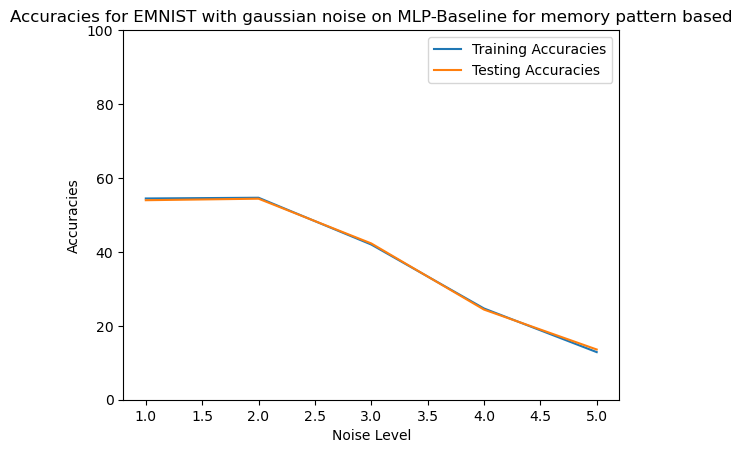

In [235]:
training_acc = [54.45, 54.65, 41.99, 24.69, 12.88]
testing_acc = [53.98, 54.39, 42.29, 24.39, 13.59]
xs = [1,2,3,4,5]

plt.plot(xs, training_acc, label='Training Accuracies')
plt.plot(xs, testing_acc, label='Testing Accuracies')

plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.ylim(0,100)
plt.title('Accuracies for EMNIST with gaussian noise on MLP-Baseline for memory pattern based')
plt.legend()
plt.show()

#### Combinatorial Generalization

In [234]:
for idx in range(5):
    MLPBaseline_EMNIST_Gaussian = MLPBaseline_Experiment(64, 0.75, 0.005, Learning.FullyOrthogonal, 0.1, emnist_train_dataloader_gaussian[idx], 47)
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_train_dataloader_gaussian[idx]))
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_test_dataloader_gaussian[idx]))

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5195478723404255, {29: (1145, 2400), 16: (1647, 2400), 6: (1637, 2400), 17: (745, 2400), 26: (1194, 2400), 32: (1691, 2400), 30: (1319, 2400), 21: (505, 2400), 18: (1025, 2400), 31: (1511, 2400), 5: (1171, 2400), 3: (1793, 2400), 36: (1062, 2400), 2: (1211, 2400), 43: (1618, 2400), 10: (1323, 2400), 8: (1193, 2400), 9: (1470, 2400), 41: (491, 2400), 39: (1579, 2400), 45: (1871, 2400), 15: (453, 2400), 34: (1044, 2400), 22: (1871, 2400), 1: (767, 2400), 7: (1677, 2400), 24: (515, 2400), 40: (1184, 2400), 19: (950, 2400), 13: (1254, 2400), 12: (1026, 2400), 33: (1478, 2400), 11: (1330, 2400), 37: (1492, 2400), 46: (1121, 2400), 38: (1662, 2400), 28: (1189, 2400), 23: (1396, 2400), 4: (895, 2400), 14: (1456, 2400), 0: (1324, 2400), 42: (1436, 2400), 25: (1355, 2400), 44: (651, 2400), 35: (1504, 2400), 27: (1227, 2400), 20: (1147, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5164893617021277, {22: (303, 400), 5: (190, 400), 46: (186, 400), 32: (302, 400), 7: (285, 400), 30: (226, 400), 41: (81, 400), 31: (228, 400), 3: (318, 400), 21: (89, 400), 36: (164, 400), 12: (170, 400), 19: (164, 400), 34: (152, 400), 13: (204, 400), 2: (214, 400), 8: (188, 400), 9: (228, 400), 42: (252, 400), 10: (219, 400), 0: (233, 400), 35: (258, 400), 39: (268, 400), 45: (297, 400), 16: (266, 400), 17: (126, 400), 4: (130, 400), 43: (255, 400), 6: (268, 400), 29: (179, 400), 28: (203, 400), 25: (237, 400), 26: (223, 400), 44: (103, 400), 20: (182, 400), 11: (234, 400), 18: (151, 400), 24: (108, 400), 38: (286, 400), 23: (231, 400), 33: (235, 400), 1: (127, 400), 15: (88, 400), 37: (241, 400), 40: (183, 400), 27: (177, 400), 14: (258, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5189539007092199, {9: (1086, 2400), 7: (1794, 2400), 39: (884, 2400), 44: (538, 2400), 41: (476, 2400), 30: (853, 2400), 15: (500, 2400), 25: (1230, 2400), 31: (1736, 2400), 0: (730, 2400), 40: (1283, 2400), 17: (1292, 2400), 22: (2050, 2400), 24: (1322, 2400), 26: (1551, 2400), 14: (1623, 2400), 28: (1552, 2400), 36: (782, 2400), 2: (1166, 2400), 35: (1445, 2400), 38: (1677, 2400), 18: (1497, 2400), 11: (1365, 2400), 32: (1980, 2400), 34: (895, 2400), 6: (1499, 2400), 1: (642, 2400), 27: (1631, 2400), 20: (851, 2400), 43: (1577, 2400), 16: (1344, 2400), 12: (1674, 2400), 13: (1367, 2400), 8: (1321, 2400), 19: (782, 2400), 46: (877, 2400), 45: (1940, 2400), 23: (897, 2400), 37: (1317, 2400), 10: (1361, 2400), 21: (235, 2400), 42: (1412, 2400), 5: (1048, 2400), 29: (1220, 2400), 33: (1511, 2400), 4: (982, 2400), 3: (1743, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5124468085106383, {40: (203, 400), 16: (215, 400), 32: (336, 400), 9: (168, 400), 2: (204, 400), 0: (125, 400), 34: (140, 400), 3: (313, 400), 28: (252, 400), 1: (115, 400), 14: (267, 400), 38: (288, 400), 27: (251, 400), 44: (81, 400), 15: (97, 400), 13: (232, 400), 12: (266, 400), 19: (119, 400), 33: (239, 400), 8: (217, 400), 36: (110, 400), 6: (250, 400), 35: (250, 400), 25: (209, 400), 37: (203, 400), 39: (141, 400), 31: (276, 400), 42: (247, 400), 45: (317, 400), 30: (138, 400), 26: (266, 400), 20: (142, 400), 11: (239, 400), 17: (209, 400), 29: (192, 400), 23: (140, 400), 21: (40, 400), 4: (151, 400), 10: (222, 400), 24: (239, 400), 18: (226, 400), 43: (261, 400), 46: (148, 400), 41: (79, 400), 5: (175, 400), 22: (329, 400), 7: (307, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.519822695035461, {28: (1599, 2400), 5: (839, 2400), 15: (436, 2400), 36: (1334, 2400), 35: (1217, 2400), 27: (993, 2400), 29: (1272, 2400), 17: (1144, 2400), 32: (2035, 2400), 8: (1185, 2400), 25: (1106, 2400), 26: (1409, 2400), 1: (660, 2400), 40: (1402, 2400), 34: (728, 2400), 19: (684, 2400), 23: (1430, 2400), 7: (1656, 2400), 11: (1258, 2400), 9: (1289, 2400), 43: (1683, 2400), 0: (1120, 2400), 6: (1726, 2400), 31: (1327, 2400), 39: (1102, 2400), 44: (169, 2400), 45: (1712, 2400), 3: (1924, 2400), 14: (1405, 2400), 20: (1075, 2400), 4: (1406, 2400), 2: (1247, 2400), 12: (1864, 2400), 18: (792, 2400), 38: (1817, 2400), 41: (625, 2400), 10: (1249, 2400), 21: (892, 2400), 24: (1446, 2400), 30: (992, 2400), 22: (1822, 2400), 46: (784, 2400), 13: (1052, 2400), 16: (1310, 2400), 42: (1145, 2400), 33: (1548, 2400), 37: (1726, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5126595744680851, {24: (252, 400), 14: (229, 400), 16: (219, 400), 35: (192, 400), 37: (287, 400), 33: (254, 400), 3: (331, 400), 28: (257, 400), 42: (191, 400), 8: (193, 400), 36: (224, 400), 6: (291, 400), 38: (305, 400), 21: (148, 400), 34: (107, 400), 1: (104, 400), 32: (355, 400), 13: (181, 400), 5: (135, 400), 45: (275, 400), 4: (218, 400), 26: (238, 400), 40: (216, 400), 30: (160, 400), 39: (180, 400), 2: (216, 400), 7: (277, 400), 18: (122, 400), 46: (128, 400), 27: (134, 400), 9: (211, 400), 31: (208, 400), 19: (106, 400), 43: (277, 400), 41: (109, 400), 17: (191, 400), 23: (238, 400), 22: (299, 400), 20: (170, 400), 0: (192, 400), 29: (205, 400), 10: (204, 400), 44: (26, 400), 25: (182, 400), 15: (83, 400), 12: (305, 400), 11: (213, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.4982535460992908, {39: (1431, 2400), 13: (1446, 2400), 33: (1401, 2400), 8: (1279, 2400), 1: (1106, 2400), 36: (1019, 2400), 10: (1380, 2400), 37: (1277, 2400), 7: (1636, 2400), 31: (1302, 2400), 24: (1252, 2400), 22: (1818, 2400), 21: (112, 2400), 26: (1169, 2400), 30: (1596, 2400), 40: (991, 2400), 32: (1624, 2400), 3: (1486, 2400), 0: (783, 2400), 28: (1164, 2400), 18: (1104, 2400), 41: (1051, 2400), 17: (1351, 2400), 12: (754, 2400), 27: (1325, 2400), 19: (760, 2400), 45: (1947, 2400), 6: (1291, 2400), 2: (1304, 2400), 14: (1632, 2400), 23: (1073, 2400), 4: (1207, 2400), 43: (1695, 2400), 11: (1282, 2400), 29: (1343, 2400), 34: (983, 2400), 25: (1432, 2400), 16: (1619, 2400), 20: (1015, 2400), 9: (651, 2400), 44: (483, 2400), 35: (1129, 2400), 15: (58, 2400), 5: (1014, 2400), 42: (962, 2400), 46: (929, 2400), 38: (1537, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.49675531914893617, {38: (264, 400), 19: (121, 400), 46: (153, 400), 13: (246, 400), 21: (24, 400), 35: (181, 400), 44: (67, 400), 3: (272, 400), 36: (158, 400), 7: (274, 400), 9: (98, 400), 18: (169, 400), 34: (157, 400), 2: (217, 400), 26: (200, 400), 43: (281, 400), 17: (222, 400), 12: (124, 400), 23: (173, 400), 22: (296, 400), 24: (216, 400), 14: (281, 400), 42: (161, 400), 45: (310, 400), 6: (220, 400), 11: (221, 400), 40: (159, 400), 31: (200, 400), 4: (195, 400), 0: (153, 400), 33: (225, 400), 32: (289, 400), 27: (189, 400), 20: (176, 400), 41: (171, 400), 37: (217, 400), 30: (275, 400), 39: (253, 400), 15: (12, 400), 10: (237, 400), 5: (168, 400), 1: (192, 400), 16: (256, 400), 29: (212, 400), 28: (199, 400), 25: (246, 400), 8: (209, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.46187943262411346, {1: (163, 2400), 40: (1101, 2400), 25: (1100, 2400), 46: (457, 2400), 29: (1457, 2400), 7: (1204, 2400), 9: (1433, 2400), 20: (954, 2400), 15: (238, 2400), 24: (675, 2400), 43: (1505, 2400), 39: (1600, 2400), 11: (766, 2400), 16: (1462, 2400), 6: (1634, 2400), 45: (1960, 2400), 21: (901, 2400), 32: (1842, 2400), 35: (1061, 2400), 26: (979, 2400), 37: (1233, 2400), 33: (1217, 2400), 38: (1557, 2400), 2: (1174, 2400), 27: (1322, 2400), 8: (1065, 2400), 41: (413, 2400), 28: (1213, 2400), 34: (906, 2400), 17: (1167, 2400), 4: (1251, 2400), 30: (1497, 2400), 22: (1862, 2400), 14: (1253, 2400), 3: (1836, 2400), 19: (578, 2400), 42: (1540, 2400), 44: (89, 2400), 0: (583, 2400), 36: (929, 2400), 18: (875, 2400), 13: (944, 2400), 12: (527, 2400), 23: (1510, 2400), 31: (1232, 2400), 10: (1097, 2400), 5: (738, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.4530851063829787, {6: (273, 400), 32: (329, 400), 33: (195, 400), 15: (48, 400), 19: (93, 400), 41: (73, 400), 1: (33, 400), 28: (200, 400), 8: (168, 400), 29: (247, 400), 34: (136, 400), 3: (311, 400), 10: (180, 400), 30: (248, 400), 14: (227, 400), 46: (92, 400), 31: (199, 400), 16: (239, 400), 21: (156, 400), 44: (14, 400), 25: (186, 400), 39: (277, 400), 38: (250, 400), 9: (228, 400), 7: (200, 400), 11: (112, 400), 0: (102, 400), 40: (162, 400), 4: (185, 400), 12: (87, 400), 13: (160, 400), 17: (189, 400), 37: (187, 400), 42: (258, 400), 43: (234, 400), 27: (175, 400), 5: (111, 400), 36: (136, 400), 20: (163, 400), 2: (196, 400), 23: (252, 400), 24: (108, 400), 22: (302, 400), 45: (313, 400), 26: (161, 400), 35: (176, 400), 18: (147, 400)})


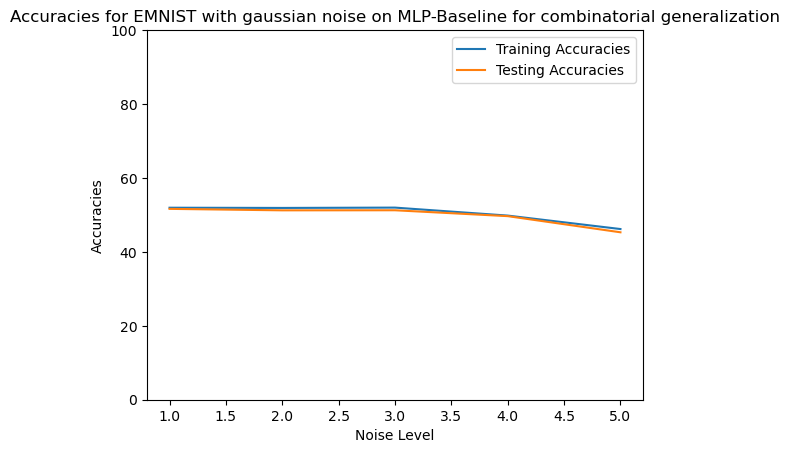

In [236]:
training_acc = [51.95, 51.89, 51.98, 49.82, 46.18]
testing_acc = [51.64, 51.24, 51.26, 49.67, 45.30]
xs = [1,2,3,4,5]

plt.plot(xs, training_acc, label='Training Accuracies')
plt.plot(xs, testing_acc, label='Testing Accuracies')

plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.ylim(0,100)
plt.title('Accuracies for EMNIST with gaussian noise on MLP-Baseline for combinatorial generalization')
plt.legend()
plt.show()

### Speckle Noise

#### Noise level visualization

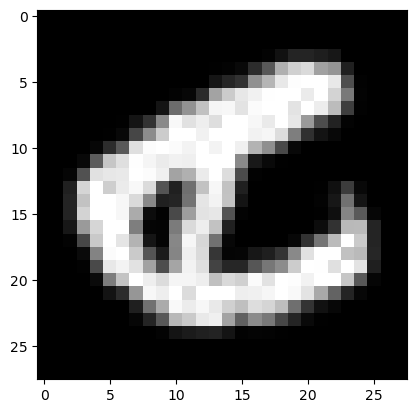

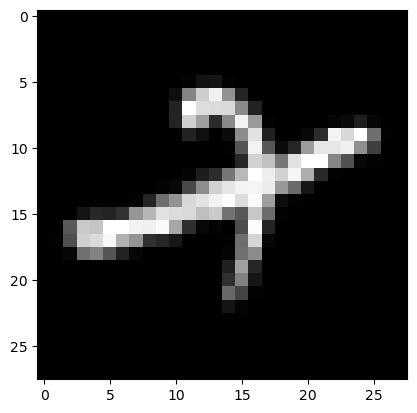

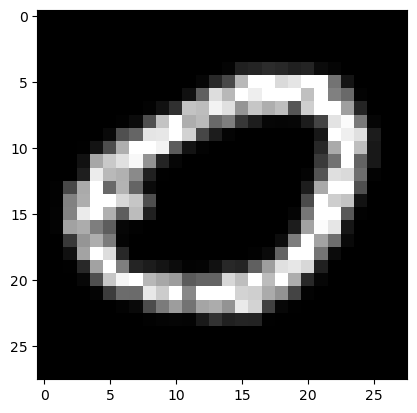

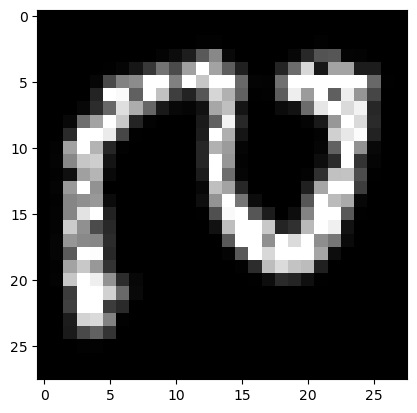

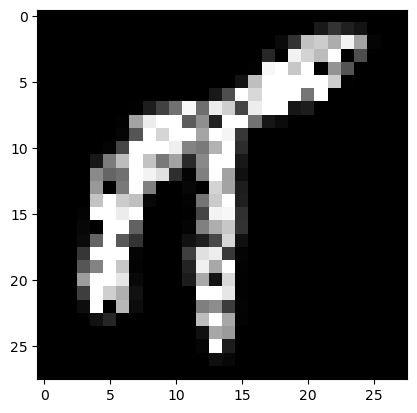

In [204]:
for idx in range(5):
    for data in emnist_test_dataloader_speckle[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

#### Memory pattern based

In [201]:
for idx in range(5):
    MLPBaseline_EMNIST_Gaussian = MLPBaseline_Experiment(256, 15, 0.005, Learning.FullyOrthogonal, 0.01, emnist_train_dataloader_speckle[idx], 47)
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_train_dataloader_speckle[idx]))
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_test_dataloader_speckle[idx]))

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5500088652482269, {25: (1639, 2400), 21: (860, 2400), 46: (1134, 2400), 13: (1488, 2400), 23: (1514, 2400), 37: (1569, 2400), 31: (1754, 2400), 19: (1306, 2400), 14: (1182, 2400), 17: (1300, 2400), 26: (1226, 2400), 16: (1637, 2400), 40: (972, 2400), 38: (1521, 2400), 43: (1085, 2400), 7: (1748, 2400), 34: (1064, 2400), 6: (1707, 2400), 11: (1203, 2400), 44: (998, 2400), 5: (974, 2400), 33: (1437, 2400), 10: (1541, 2400), 9: (1074, 2400), 27: (1335, 2400), 15: (945, 2400), 36: (1359, 2400), 22: (1923, 2400), 24: (1175, 2400), 8: (1063, 2400), 28: (1589, 2400), 29: (1453, 2400), 42: (1373, 2400), 20: (995, 2400), 4: (838, 2400), 12: (1123, 2400), 32: (1447, 2400), 18: (479, 2400), 2: (1412, 2400), 3: (1749, 2400), 35: (1830, 2400), 0: (886, 2400), 39: (1617, 2400), 1: (1479, 2400), 30: (1328, 2400), 45: (1854, 2400), 41: (856, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5437765957446808, {14: (205, 400), 36: (212, 400), 24: (202, 400), 9: (176, 400), 8: (167, 400), 17: (219, 400), 46: (194, 400), 38: (245, 400), 19: (219, 400), 34: (172, 400), 2: (246, 400), 4: (138, 400), 30: (210, 400), 35: (308, 400), 28: (267, 400), 1: (244, 400), 21: (152, 400), 40: (146, 400), 37: (248, 400), 43: (164, 400), 13: (240, 400), 20: (176, 400), 7: (291, 400), 32: (264, 400), 33: (226, 400), 18: (75, 400), 44: (147, 400), 12: (198, 400), 22: (313, 400), 5: (147, 400), 11: (215, 400), 27: (197, 400), 23: (256, 400), 15: (154, 400), 29: (224, 400), 41: (137, 400), 25: (272, 400), 3: (297, 400), 42: (220, 400), 39: (273, 400), 31: (284, 400), 6: (282, 400), 10: (252, 400), 45: (300, 400), 0: (165, 400), 26: (210, 400), 16: (274, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5543882978723405, {33: (1267, 2400), 0: (1627, 2400), 22: (1959, 2400), 37: (1466, 2400), 4: (1049, 2400), 14: (1415, 2400), 3: (1153, 2400), 30: (1566, 2400), 13: (1015, 2400), 42: (1305, 2400), 32: (1791, 2400), 12: (1424, 2400), 23: (1510, 2400), 29: (1567, 2400), 1: (1903, 2400), 40: (1369, 2400), 24: (1182, 2400), 26: (1145, 2400), 44: (944, 2400), 45: (1899, 2400), 15: (707, 2400), 20: (1525, 2400), 27: (1454, 2400), 25: (1119, 2400), 39: (1490, 2400), 34: (1107, 2400), 2: (1414, 2400), 35: (1815, 2400), 10: (1313, 2400), 6: (1613, 2400), 38: (1779, 2400), 41: (952, 2400), 46: (1039, 2400), 8: (1018, 2400), 17: (1407, 2400), 16: (1406, 2400), 43: (1507, 2400), 9: (933, 2400), 11: (1308, 2400), 31: (1755, 2400), 36: (1136, 2400), 21: (391, 2400), 19: (798, 2400), 28: (1658, 2400), 5: (1077, 2400), 18: (626, 2400), 7: (1632, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5490957446808511, {14: (241, 400), 20: (268, 400), 31: (290, 400), 41: (142, 400), 7: (276, 400), 46: (180, 400), 30: (258, 400), 15: (102, 400), 12: (254, 400), 5: (175, 400), 3: (203, 400), 33: (189, 400), 25: (174, 400), 10: (216, 400), 43: (236, 400), 23: (247, 400), 0: (272, 400), 27: (221, 400), 38: (302, 400), 42: (228, 400), 32: (315, 400), 4: (161, 400), 36: (177, 400), 17: (243, 400), 19: (111, 400), 21: (81, 400), 13: (185, 400), 9: (151, 400), 24: (205, 400), 34: (191, 400), 6: (258, 400), 29: (237, 400), 11: (208, 400), 44: (145, 400), 26: (199, 400), 28: (269, 400), 45: (316, 400), 35: (311, 400), 8: (159, 400), 39: (242, 400), 40: (218, 400), 16: (241, 400), 1: (305, 400), 37: (246, 400), 22: (320, 400), 2: (241, 400), 18: (114, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5298936170212766, {24: (974, 2400), 40: (301, 2400), 41: (807, 2400), 20: (1163, 2400), 18: (749, 2400), 5: (1352, 2400), 13: (1162, 2400), 14: (839, 2400), 9: (898, 2400), 7: (1057, 2400), 34: (671, 2400), 3: (890, 2400), 44: (1056, 2400), 27: (1389, 2400), 2: (1247, 2400), 0: (901, 2400), 17: (1410, 2400), 28: (1467, 2400), 45: (1801, 2400), 15: (1563, 2400), 25: (1179, 2400), 35: (1787, 2400), 16: (1341, 2400), 42: (1346, 2400), 6: (1489, 2400), 36: (1182, 2400), 29: (1760, 2400), 10: (1385, 2400), 21: (579, 2400), 4: (1241, 2400), 46: (1019, 2400), 12: (1748, 2400), 11: (1698, 2400), 39: (1296, 2400), 38: (1841, 2400), 1: (1599, 2400), 33: (1447, 2400), 31: (1448, 2400), 26: (1342, 2400), 23: (1447, 2400), 22: (2014, 2400), 37: (1276, 2400), 32: (1847, 2400), 43: (1333, 2400), 8: (1218, 2400), 19: (844, 2400), 30: (1369, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5237234042553192, {11: (282, 400), 19: (138, 400), 9: (155, 400), 5: (227, 400), 33: (232, 400), 0: (168, 400), 46: (172, 400), 38: (314, 400), 39: (215, 400), 16: (227, 400), 12: (276, 400), 10: (224, 400), 3: (167, 400), 28: (237, 400), 1: (247, 400), 32: (323, 400), 45: (282, 400), 35: (297, 400), 37: (215, 400), 2: (209, 400), 4: (212, 400), 27: (201, 400), 15: (263, 400), 8: (184, 400), 26: (244, 400), 20: (193, 400), 42: (241, 400), 22: (325, 400), 7: (167, 400), 13: (191, 400), 34: (113, 400), 36: (186, 400), 29: (267, 400), 25: (194, 400), 40: (41, 400), 41: (137, 400), 14: (133, 400), 30: (213, 400), 6: (248, 400), 21: (106, 400), 23: (241, 400), 44: (164, 400), 43: (221, 400), 31: (229, 400), 17: (230, 400), 24: (171, 400), 18: (124, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.54927304964539, {6: (1744, 2400), 41: (1012, 2400), 7: (1705, 2400), 18: (418, 2400), 37: (1526, 2400), 21: (289, 2400), 27: (1416, 2400), 25: (1387, 2400), 4: (1280, 2400), 14: (980, 2400), 0: (1114, 2400), 19: (991, 2400), 39: (1260, 2400), 30: (1193, 2400), 11: (1195, 2400), 2: (1247, 2400), 43: (1271, 2400), 26: (1472, 2400), 35: (1862, 2400), 40: (1331, 2400), 16: (1305, 2400), 32: (1820, 2400), 22: (2007, 2400), 1: (1915, 2400), 15: (671, 2400), 38: (1833, 2400), 5: (1064, 2400), 46: (976, 2400), 20: (1285, 2400), 44: (883, 2400), 36: (1109, 2400), 31: (1483, 2400), 28: (1522, 2400), 34: (856, 2400), 9: (1025, 2400), 13: (1115, 2400), 29: (1803, 2400), 3: (1707, 2400), 45: (1831, 2400), 33: (1401, 2400), 12: (1522, 2400), 10: (1593, 2400), 24: (1582, 2400), 42: (1136, 2400), 23: (1599, 2400), 17: (1088, 2400), 8: (1134, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5415425531914894, {41: (155, 400), 10: (269, 400), 29: (290, 400), 39: (206, 400), 23: (255, 400), 38: (314, 400), 4: (215, 400), 20: (212, 400), 14: (170, 400), 28: (242, 400), 5: (185, 400), 32: (317, 400), 34: (139, 400), 6: (286, 400), 19: (161, 400), 11: (207, 400), 1: (312, 400), 40: (212, 400), 31: (223, 400), 18: (69, 400), 27: (200, 400), 33: (207, 400), 30: (188, 400), 0: (201, 400), 43: (200, 400), 17: (174, 400), 15: (125, 400), 36: (179, 400), 37: (254, 400), 2: (208, 400), 24: (276, 400), 9: (165, 400), 35: (317, 400), 7: (290, 400), 46: (161, 400), 12: (249, 400), 13: (186, 400), 8: (181, 400), 16: (221, 400), 44: (133, 400), 3: (302, 400), 26: (248, 400), 22: (325, 400), 42: (187, 400), 21: (49, 400), 45: (295, 400), 25: (221, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5366223404255319, {19: (493, 2400), 32: (1967, 2400), 37: (997, 2400), 34: (903, 2400), 33: (1326, 2400), 44: (916, 2400), 23: (1373, 2400), 28: (1699, 2400), 22: (1926, 2400), 40: (1039, 2400), 1: (409, 2400), 7: (1698, 2400), 26: (1443, 2400), 45: (1651, 2400), 5: (877, 2400), 27: (1153, 2400), 42: (1694, 2400), 10: (1188, 2400), 41: (1032, 2400), 38: (1937, 2400), 18: (1168, 2400), 13: (1389, 2400), 24: (888, 2400), 43: (1578, 2400), 30: (1152, 2400), 39: (1140, 2400), 4: (871, 2400), 12: (1826, 2400), 20: (1208, 2400), 25: (1376, 2400), 46: (1004, 2400), 31: (1792, 2400), 35: (1805, 2400), 11: (1392, 2400), 36: (1253, 2400), 17: (1482, 2400), 9: (1009, 2400), 6: (1679, 2400), 2: (1309, 2400), 8: (1147, 2400), 3: (1252, 2400), 16: (1340, 2400), 0: (814, 2400), 21: (958, 2400), 15: (1150, 2400), 29: (1568, 2400), 14: (1260, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5307978723404255, {28: (282, 400), 29: (254, 400), 8: (201, 400), 30: (181, 400), 25: (209, 400), 18: (186, 400), 41: (179, 400), 2: (218, 400), 14: (210, 400), 11: (247, 400), 16: (223, 400), 31: (286, 400), 9: (159, 400), 0: (136, 400), 3: (218, 400), 46: (177, 400), 1: (66, 400), 26: (242, 400), 33: (207, 400), 36: (205, 400), 32: (345, 400), 27: (154, 400), 22: (312, 400), 40: (167, 400), 23: (213, 400), 4: (151, 400), 44: (130, 400), 20: (197, 400), 39: (190, 400), 19: (73, 400), 10: (191, 400), 45: (280, 400), 37: (167, 400), 21: (175, 400), 43: (255, 400), 5: (139, 400), 7: (272, 400), 13: (229, 400), 17: (249, 400), 38: (334, 400), 24: (156, 400), 42: (276, 400), 12: (308, 400), 6: (280, 400), 15: (205, 400), 34: (138, 400), 35: (307, 400)})


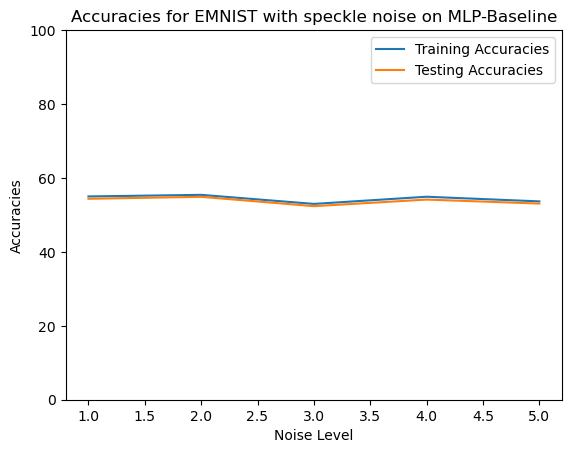

In [210]:
training_acc = [55, 55.43, 52.98, 54.92, 53.66]
testing_acc = [54.37, 54.90, 52.37, 54.15, 53.07]
xs = [1,2,3,4,5]

plt.plot(xs, training_acc, label='Training Accuracies')
plt.plot(xs, testing_acc, label='Testing Accuracies')

plt.xlabel('Noise Level')
plt.ylabel('Accuracies')
plt.ylim(0,100)
plt.title('Accuracies for EMNIST with speckle noise on MLP-Baseline')
plt.legend()
plt.show()

#### Combinatorial Generalization

In [237]:
for idx in range(5):
    MLPBaseline_EMNIST_Gaussian = MLPBaseline_Experiment(64, 0.75, 0.005, Learning.FullyOrthogonal, 0.1, emnist_train_dataloader_speckle[idx], 47)
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_train_dataloader_speckle[idx]))
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_test_dataloader_speckle[idx]))

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5233776595744681, {31: (1562, 2400), 37: (1385, 2400), 22: (2045, 2400), 24: (1148, 2400), 13: (1350, 2400), 34: (1046, 2400), 9: (850, 2400), 33: (1615, 2400), 30: (1145, 2400), 45: (1897, 2400), 39: (1699, 2400), 29: (1079, 2400), 17: (912, 2400), 43: (1785, 2400), 2: (1195, 2400), 20: (994, 2400), 5: (918, 2400), 27: (1516, 2400), 23: (1251, 2400), 1: (900, 2400), 26: (1324, 2400), 7: (1983, 2400), 42: (1341, 2400), 38: (1706, 2400), 10: (1604, 2400), 4: (1473, 2400), 21: (160, 2400), 3: (1894, 2400), 25: (963, 2400), 35: (1197, 2400), 16: (1623, 2400), 46: (979, 2400), 36: (1154, 2400), 8: (1301, 2400), 0: (788, 2400), 15: (539, 2400), 18: (1227, 2400), 12: (990, 2400), 28: (860, 2400), 19: (803, 2400), 14: (1393, 2400), 44: (483, 2400), 32: (2060, 2400), 40: (1317, 2400), 41: (729, 2400), 6: (1451, 2400), 11: (1403, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5217553191489361, {25: (161, 400), 12: (165, 400), 15: (102, 400), 27: (237, 400), 1: (148, 400), 38: (294, 400), 8: (214, 400), 26: (228, 400), 33: (270, 400), 0: (153, 400), 31: (242, 400), 35: (209, 400), 3: (332, 400), 45: (310, 400), 20: (166, 400), 6: (243, 400), 4: (237, 400), 2: (205, 400), 16: (270, 400), 37: (224, 400), 22: (334, 400), 5: (147, 400), 36: (175, 400), 29: (177, 400), 39: (290, 400), 43: (290, 400), 34: (172, 400), 21: (24, 400), 23: (199, 400), 24: (219, 400), 46: (158, 400), 30: (182, 400), 10: (269, 400), 32: (357, 400), 17: (157, 400), 28: (139, 400), 13: (227, 400), 19: (129, 400), 7: (335, 400), 41: (117, 400), 44: (75, 400), 42: (232, 400), 11: (239, 400), 18: (175, 400), 14: (242, 400), 40: (211, 400), 9: (128, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5242109929078014, {9: (1164, 2400), 34: (1109, 2400), 3: (1665, 2400), 14: (1470, 2400), 38: (1679, 2400), 40: (1235, 2400), 8: (1271, 2400), 29: (1443, 2400), 15: (387, 2400), 35: (1172, 2400), 11: (957, 2400), 46: (894, 2400), 1: (637, 2400), 26: (1359, 2400), 7: (1669, 2400), 36: (1084, 2400), 12: (1111, 2400), 18: (1588, 2400), 43: (1784, 2400), 4: (1453, 2400), 10: (1149, 2400), 27: (1113, 2400), 2: (1360, 2400), 42: (1596, 2400), 31: (1614, 2400), 17: (1121, 2400), 21: (49, 2400), 30: (958, 2400), 19: (686, 2400), 32: (1964, 2400), 25: (1392, 2400), 0: (615, 2400), 24: (1656, 2400), 16: (1566, 2400), 39: (1681, 2400), 5: (774, 2400), 33: (1433, 2400), 6: (1551, 2400), 45: (1848, 2400), 13: (1499, 2400), 20: (1189, 2400), 28: (1511, 2400), 41: (408, 2400), 22: (2049, 2400), 37: (1417, 2400), 23: (1385, 2400), 44: (416, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5190425531914894, {45: (294, 400), 28: (240, 400), 20: (210, 400), 33: (231, 400), 13: (242, 400), 38: (292, 400), 46: (151, 400), 12: (183, 400), 43: (287, 400), 23: (242, 400), 25: (228, 400), 44: (62, 400), 10: (203, 400), 17: (192, 400), 39: (287, 400), 22: (327, 400), 19: (101, 400), 42: (266, 400), 21: (8, 400), 6: (259, 400), 34: (172, 400), 3: (295, 400), 37: (227, 400), 24: (276, 400), 29: (235, 400), 14: (257, 400), 18: (247, 400), 31: (261, 400), 11: (162, 400), 41: (66, 400), 15: (71, 400), 0: (113, 400), 9: (187, 400), 30: (152, 400), 1: (113, 400), 26: (240, 400), 8: (211, 400), 2: (231, 400), 7: (285, 400), 35: (199, 400), 36: (171, 400), 16: (256, 400), 5: (112, 400), 27: (159, 400), 4: (230, 400), 32: (338, 400), 40: (187, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.509991134751773, {46: (1093, 2400), 18: (1241, 2400), 37: (1586, 2400), 44: (900, 2400), 38: (1713, 2400), 40: (1069, 2400), 19: (683, 2400), 1: (889, 2400), 11: (1046, 2400), 25: (1511, 2400), 27: (1216, 2400), 42: (1049, 2400), 28: (1542, 2400), 14: (1538, 2400), 17: (1440, 2400), 9: (979, 2400), 26: (1088, 2400), 21: (62, 2400), 41: (694, 2400), 35: (1386, 2400), 4: (1224, 2400), 33: (1412, 2400), 10: (1471, 2400), 5: (938, 2400), 0: (1547, 2400), 8: (1140, 2400), 12: (743, 2400), 32: (1776, 2400), 45: (1085, 2400), 23: (1466, 2400), 16: (1702, 2400), 15: (400, 2400), 3: (1748, 2400), 7: (1519, 2400), 39: (1439, 2400), 43: (1821, 2400), 6: (1508, 2400), 36: (1334, 2400), 13: (1384, 2400), 24: (435, 2400), 30: (697, 2400), 29: (1425, 2400), 34: (817, 2400), 20: (1210, 2400), 22: (1944, 2400), 31: (1491, 2400), 2: (1126, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5017021276595744, {3: (313, 400), 11: (178, 400), 5: (154, 400), 0: (260, 400), 8: (185, 400), 14: (262, 400), 18: (181, 400), 33: (232, 400), 20: (206, 400), 7: (255, 400), 28: (246, 400), 41: (126, 400), 32: (305, 400), 42: (185, 400), 19: (98, 400), 13: (227, 400), 39: (242, 400), 23: (249, 400), 26: (189, 400), 25: (253, 400), 35: (238, 400), 45: (184, 400), 1: (147, 400), 27: (164, 400), 34: (128, 400), 2: (195, 400), 4: (191, 400), 6: (243, 400), 16: (277, 400), 21: (5, 400), 24: (90, 400), 44: (139, 400), 46: (177, 400), 36: (219, 400), 12: (129, 400), 22: (311, 400), 31: (224, 400), 15: (66, 400), 9: (137, 400), 38: (288, 400), 37: (258, 400), 40: (164, 400), 17: (243, 400), 10: (239, 400), 29: (217, 400), 43: (307, 400), 30: (106, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5341400709219858, {40: (1011, 2400), 23: (1404, 2400), 2: (1075, 2400), 8: (1288, 2400), 1: (935, 2400), 14: (1608, 2400), 43: (1582, 2400), 21: (397, 2400), 31: (1610, 2400), 28: (1447, 2400), 5: (1021, 2400), 10: (1611, 2400), 44: (231, 2400), 7: (1729, 2400), 33: (1282, 2400), 39: (1469, 2400), 36: (1040, 2400), 24: (1009, 2400), 26: (1249, 2400), 32: (1768, 2400), 4: (1394, 2400), 22: (2169, 2400), 46: (1016, 2400), 18: (990, 2400), 0: (1277, 2400), 37: (1075, 2400), 38: (1547, 2400), 9: (1026, 2400), 3: (1754, 2400), 6: (1380, 2400), 42: (1464, 2400), 45: (1861, 2400), 20: (814, 2400), 27: (1512, 2400), 16: (1723, 2400), 13: (1489, 2400), 19: (707, 2400), 34: (1009, 2400), 12: (1475, 2400), 15: (710, 2400), 29: (1135, 2400), 35: (1220, 2400), 25: (1540, 2400), 41: (1040, 2400), 11: (1626, 2400), 17: (1324, 2400), 30: (1208, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5274468085106383, {20: (144, 400), 2: (174, 400), 32: (313, 400), 41: (177, 400), 34: (151, 400), 9: (165, 400), 21: (70, 400), 16: (279, 400), 28: (236, 400), 43: (254, 400), 26: (224, 400), 37: (171, 400), 36: (158, 400), 39: (246, 400), 6: (231, 400), 11: (280, 400), 46: (164, 400), 44: (42, 400), 1: (151, 400), 3: (312, 400), 14: (276, 400), 17: (216, 400), 13: (244, 400), 12: (248, 400), 0: (228, 400), 15: (128, 400), 19: (111, 400), 8: (211, 400), 29: (179, 400), 30: (200, 400), 40: (155, 400), 5: (163, 400), 10: (256, 400), 22: (355, 400), 27: (225, 400), 38: (257, 400), 31: (255, 400), 18: (148, 400), 7: (282, 400), 35: (204, 400), 24: (184, 400), 45: (298, 400), 4: (214, 400), 42: (252, 400), 23: (223, 400), 25: (257, 400), 33: (205, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5371808510638297, {40: (1182, 2400), 14: (1536, 2400), 36: (1118, 2400), 23: (1414, 2400), 44: (877, 2400), 3: (1913, 2400), 34: (1117, 2400), 25: (1561, 2400), 24: (1322, 2400), 32: (1893, 2400), 5: (1149, 2400), 31: (1634, 2400), 26: (1061, 2400), 13: (1647, 2400), 22: (1982, 2400), 7: (1812, 2400), 8: (1413, 2400), 17: (1017, 2400), 45: (1948, 2400), 2: (1331, 2400), 35: (1350, 2400), 9: (1174, 2400), 18: (1147, 2400), 42: (1424, 2400), 19: (765, 2400), 37: (1449, 2400), 15: (356, 2400), 20: (928, 2400), 38: (1855, 2400), 4: (1165, 2400), 1: (898, 2400), 28: (1593, 2400), 46: (902, 2400), 43: (1628, 2400), 41: (425, 2400), 0: (783, 2400), 16: (1565, 2400), 30: (881, 2400), 11: (1459, 2400), 21: (167, 2400), 29: (1127, 2400), 27: (1389, 2400), 10: (1220, 2400), 6: (1633, 2400), 33: (1487, 2400), 39: (1637, 2400), 12: (1260, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5312765957446809, {45: (313, 400), 6: (275, 400), 13: (270, 400), 39: (270, 400), 3: (335, 400), 44: (137, 400), 17: (160, 400), 30: (141, 400), 35: (237, 400), 32: (331, 400), 4: (186, 400), 10: (192, 400), 40: (191, 400), 46: (150, 400), 38: (311, 400), 18: (180, 400), 34: (174, 400), 11: (248, 400), 27: (207, 400), 15: (57, 400), 26: (185, 400), 22: (318, 400), 33: (245, 400), 37: (227, 400), 28: (258, 400), 1: (156, 400), 31: (254, 400), 5: (191, 400), 41: (72, 400), 24: (230, 400), 16: (248, 400), 29: (167, 400), 14: (266, 400), 25: (259, 400), 21: (21, 400), 42: (242, 400), 8: (226, 400), 23: (247, 400), 36: (168, 400), 0: (135, 400), 7: (304, 400), 20: (155, 400), 2: (233, 400), 12: (222, 400), 19: (133, 400), 9: (189, 400), 43: (272, 400)})


### Occlusion Noise

#### Visualization of noise levels

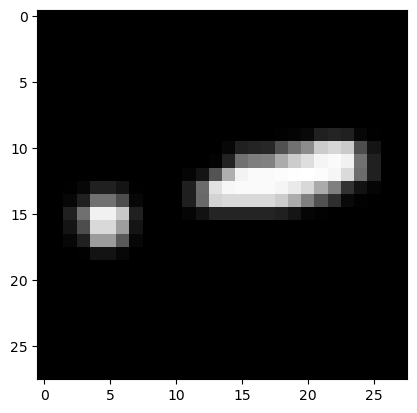

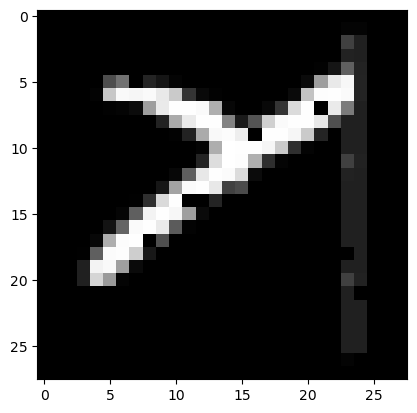

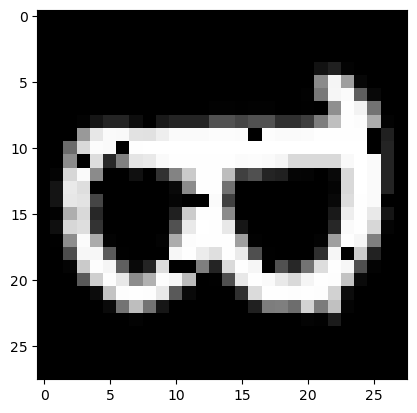

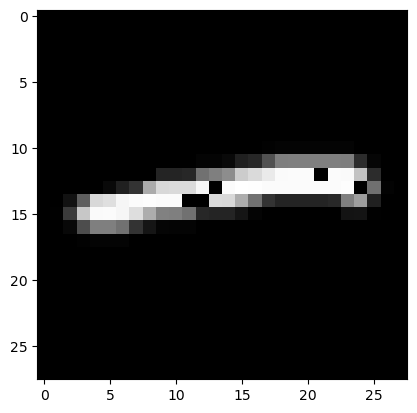

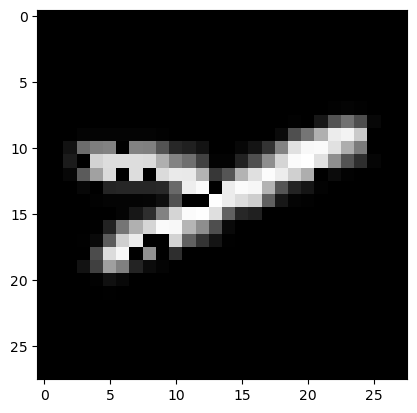

In [243]:
for idx in range(5):
    for data in emnist_test_dataloader_occlusion[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.5437854609929078, {45: (1753, 2400), 36: (1350, 2400), 43: (1286, 2400), 15: (378, 2400), 4: (1242, 2400), 42: (799, 2400), 26: (1281, 2400), 32: (1862, 2400), 20: (1114, 2400), 1: (1982, 2400), 46: (908, 2400), 13: (944, 2400), 24: (1648, 2400), 12: (1453, 2400), 5: (1303, 2400), 17: (1454, 2400), 3: (1240, 2400), 40: (1244, 2400), 14: (810, 2400), 44: (1150, 2400), 19: (952, 2400), 29: (1460, 2400), 25: (1799, 2400), 35: (1879, 2400), 28: (1682, 2400), 23: (1574, 2400), 22: (2002, 2400), 34: (840, 2400), 9: (673, 2400), 30: (950, 2400), 38: (1561, 2400), 39: (1241, 2400), 37: (1701, 2400), 31: (1602, 2400), 16: (1594, 2400), 7: (1955, 2400), 2: (1298, 2400), 8: (1155, 2400), 10: (1547, 2400), 6: (1690, 2400), 27: (1355, 2400), 33: (1543, 2400), 11: (1494, 2400), 18: (814, 2400), 41: (720, 2400), 0: (933, 2400), 21: (124, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.5388829787234043, {2: (226, 400), 16: (270, 400), 44: (185, 400), 23: (259, 400), 5: (215, 400), 0: (163, 400), 37: (281, 400), 32: (326, 400), 20: (180, 400), 13: (165, 400), 15: (54, 400), 41: (104, 400), 26: (229, 400), 10: (230, 400), 4: (201, 400), 27: (219, 400), 31: (260, 400), 40: (205, 400), 11: (255, 400), 6: (278, 400), 36: (206, 400), 18: (146, 400), 1: (320, 400), 22: (321, 400), 29: (229, 400), 7: (330, 400), 9: (107, 400), 24: (288, 400), 28: (278, 400), 34: (135, 400), 42: (137, 400), 8: (171, 400), 25: (300, 400), 21: (25, 400), 45: (277, 400), 3: (225, 400), 33: (257, 400), 35: (323, 400), 38: (277, 400), 43: (209, 400), 30: (146, 400), 17: (237, 400), 14: (136, 400), 46: (145, 400), 12: (248, 400), 19: (144, 400), 39: (209, 400)})


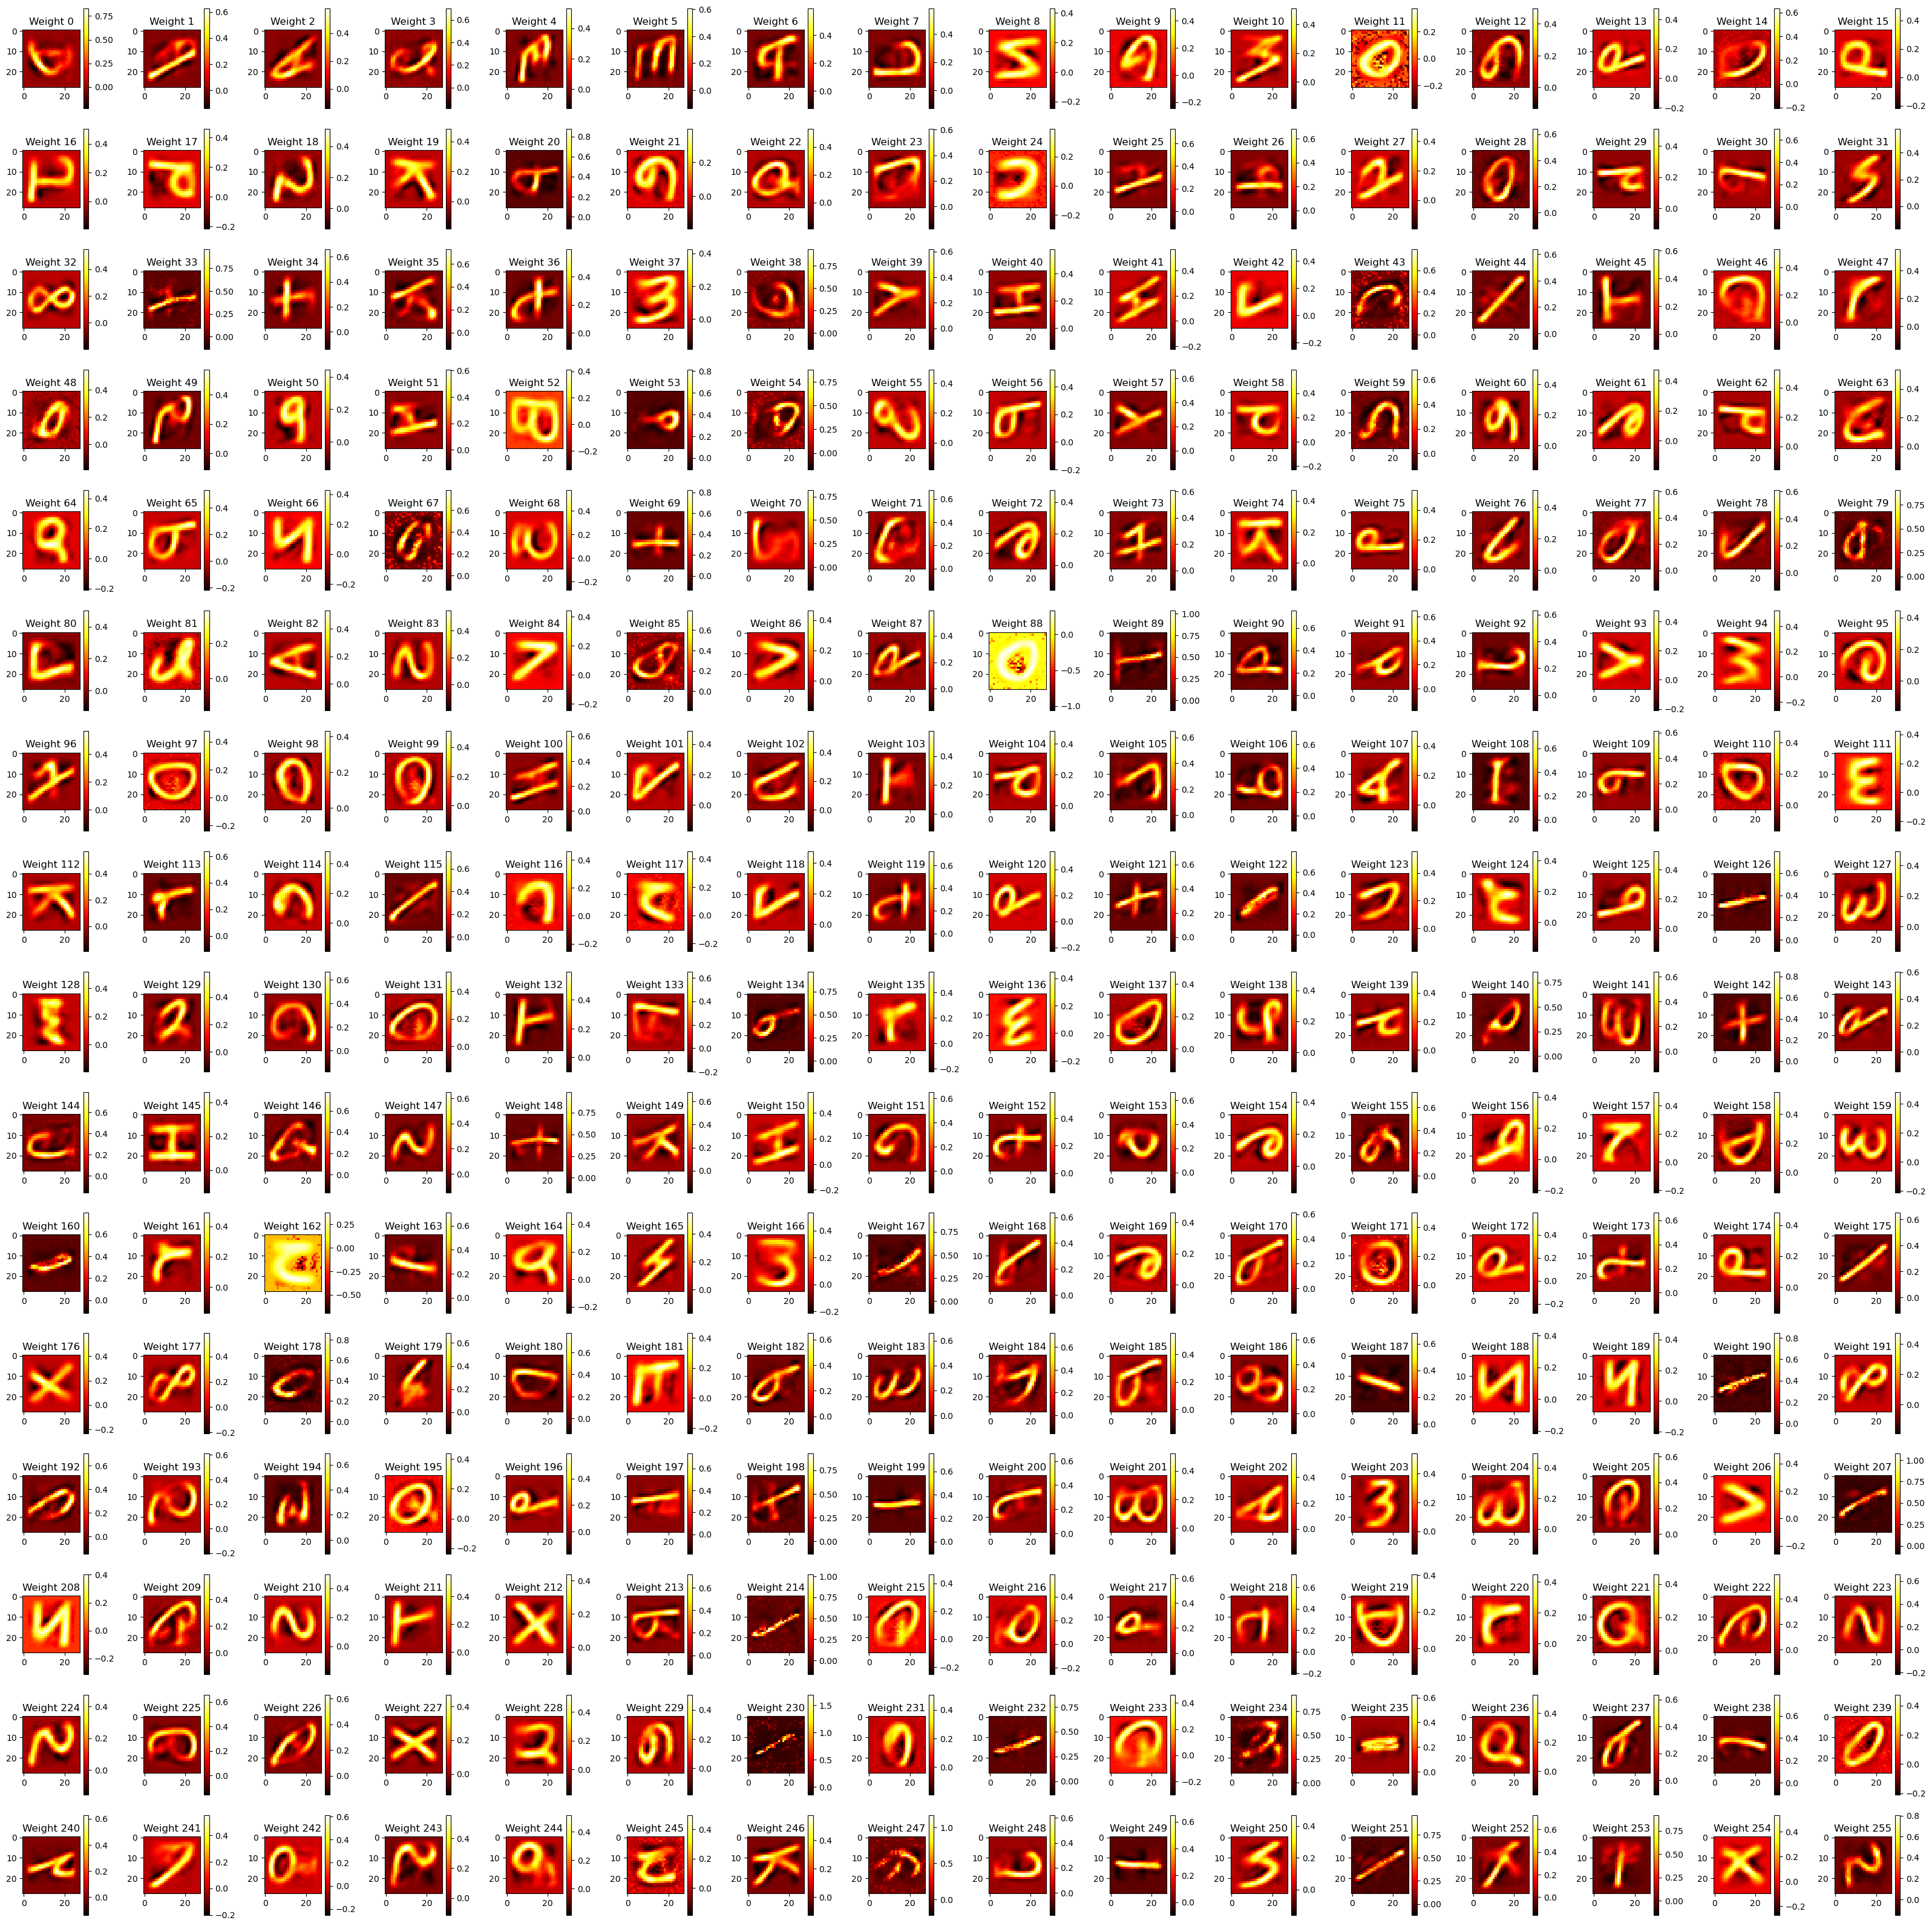

In [214]:
MLPBaseline_EMNIST_Gaussian = MLPBaseline_Experiment(256, 15, 0.005, Learning.FullyOrthogonal, 0.01, emnist_train_loader, 47)
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_train_loader))
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_test_loader))
MLPBaseline_EMNIST_Gaussian.layers['Hebbian1'].visualize_weights()

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.02127659574468085, {30: (0, 2400), 2: (0, 2400), 21: (0, 2400), 14: (0, 2400), 32: (0, 2400), 8: (0, 2400), 11: (0, 2400), 10: (0, 2400), 12: (0, 2400), 43: (0, 2400), 29: (0, 2400), 36: (0, 2400), 35: (0, 2400), 1: (0, 2400), 16: (0, 2400), 6: (0, 2400), 37: (0, 2400), 44: (0, 2400), 18: (0, 2400), 31: (0, 2400), 40: (0, 2400), 3: (0, 2400), 38: (0, 2400), 17: (0, 2400), 0: (2400, 2400), 26: (0, 2400), 4: (0, 2400), 24: (0, 2400), 23: (0, 2400), 25: (0, 2400), 34: (0, 2400), 5: (0, 2400), 19: (0, 2400), 15: (0, 2400), 13: (0, 2400), 41: (0, 2400), 20: (0, 2400), 7: (0, 2400), 22: (0, 2400), 46: (0, 2400), 42: (0, 2400), 27: (0, 2400), 39: (0, 2400), 9: (0, 2400), 28: (0, 2400), 33: (0, 2400), 45: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {36: (0, 400), 18: (0, 400), 40: (0, 400), 0: (400, 400), 14: (0, 400), 20: (0, 400), 24: (0, 400), 45: (0, 400), 46: (0, 400), 34: (0, 400), 27: (0, 400), 41: (0, 400), 32: (0, 400), 11: (0, 400), 38: (0, 400), 39: (0, 400), 43: (0, 400), 2: (0, 400), 7: (0, 400), 8: (0, 400), 13: (0, 400), 17: (0, 400), 26: (0, 400), 19: (0, 400), 21: (0, 400), 42: (0, 400), 22: (0, 400), 5: (0, 400), 10: (0, 400), 3: (0, 400), 25: (0, 400), 35: (0, 400), 44: (0, 400), 12: (0, 400), 29: (0, 400), 30: (0, 400), 31: (0, 400), 6: (0, 400), 1: (0, 400), 16: (0, 400), 15: (0, 400), 28: (0, 400), 37: (0, 400), 9: (0, 400), 23: (0, 400), 33: (0, 400), 4: (0, 400)})


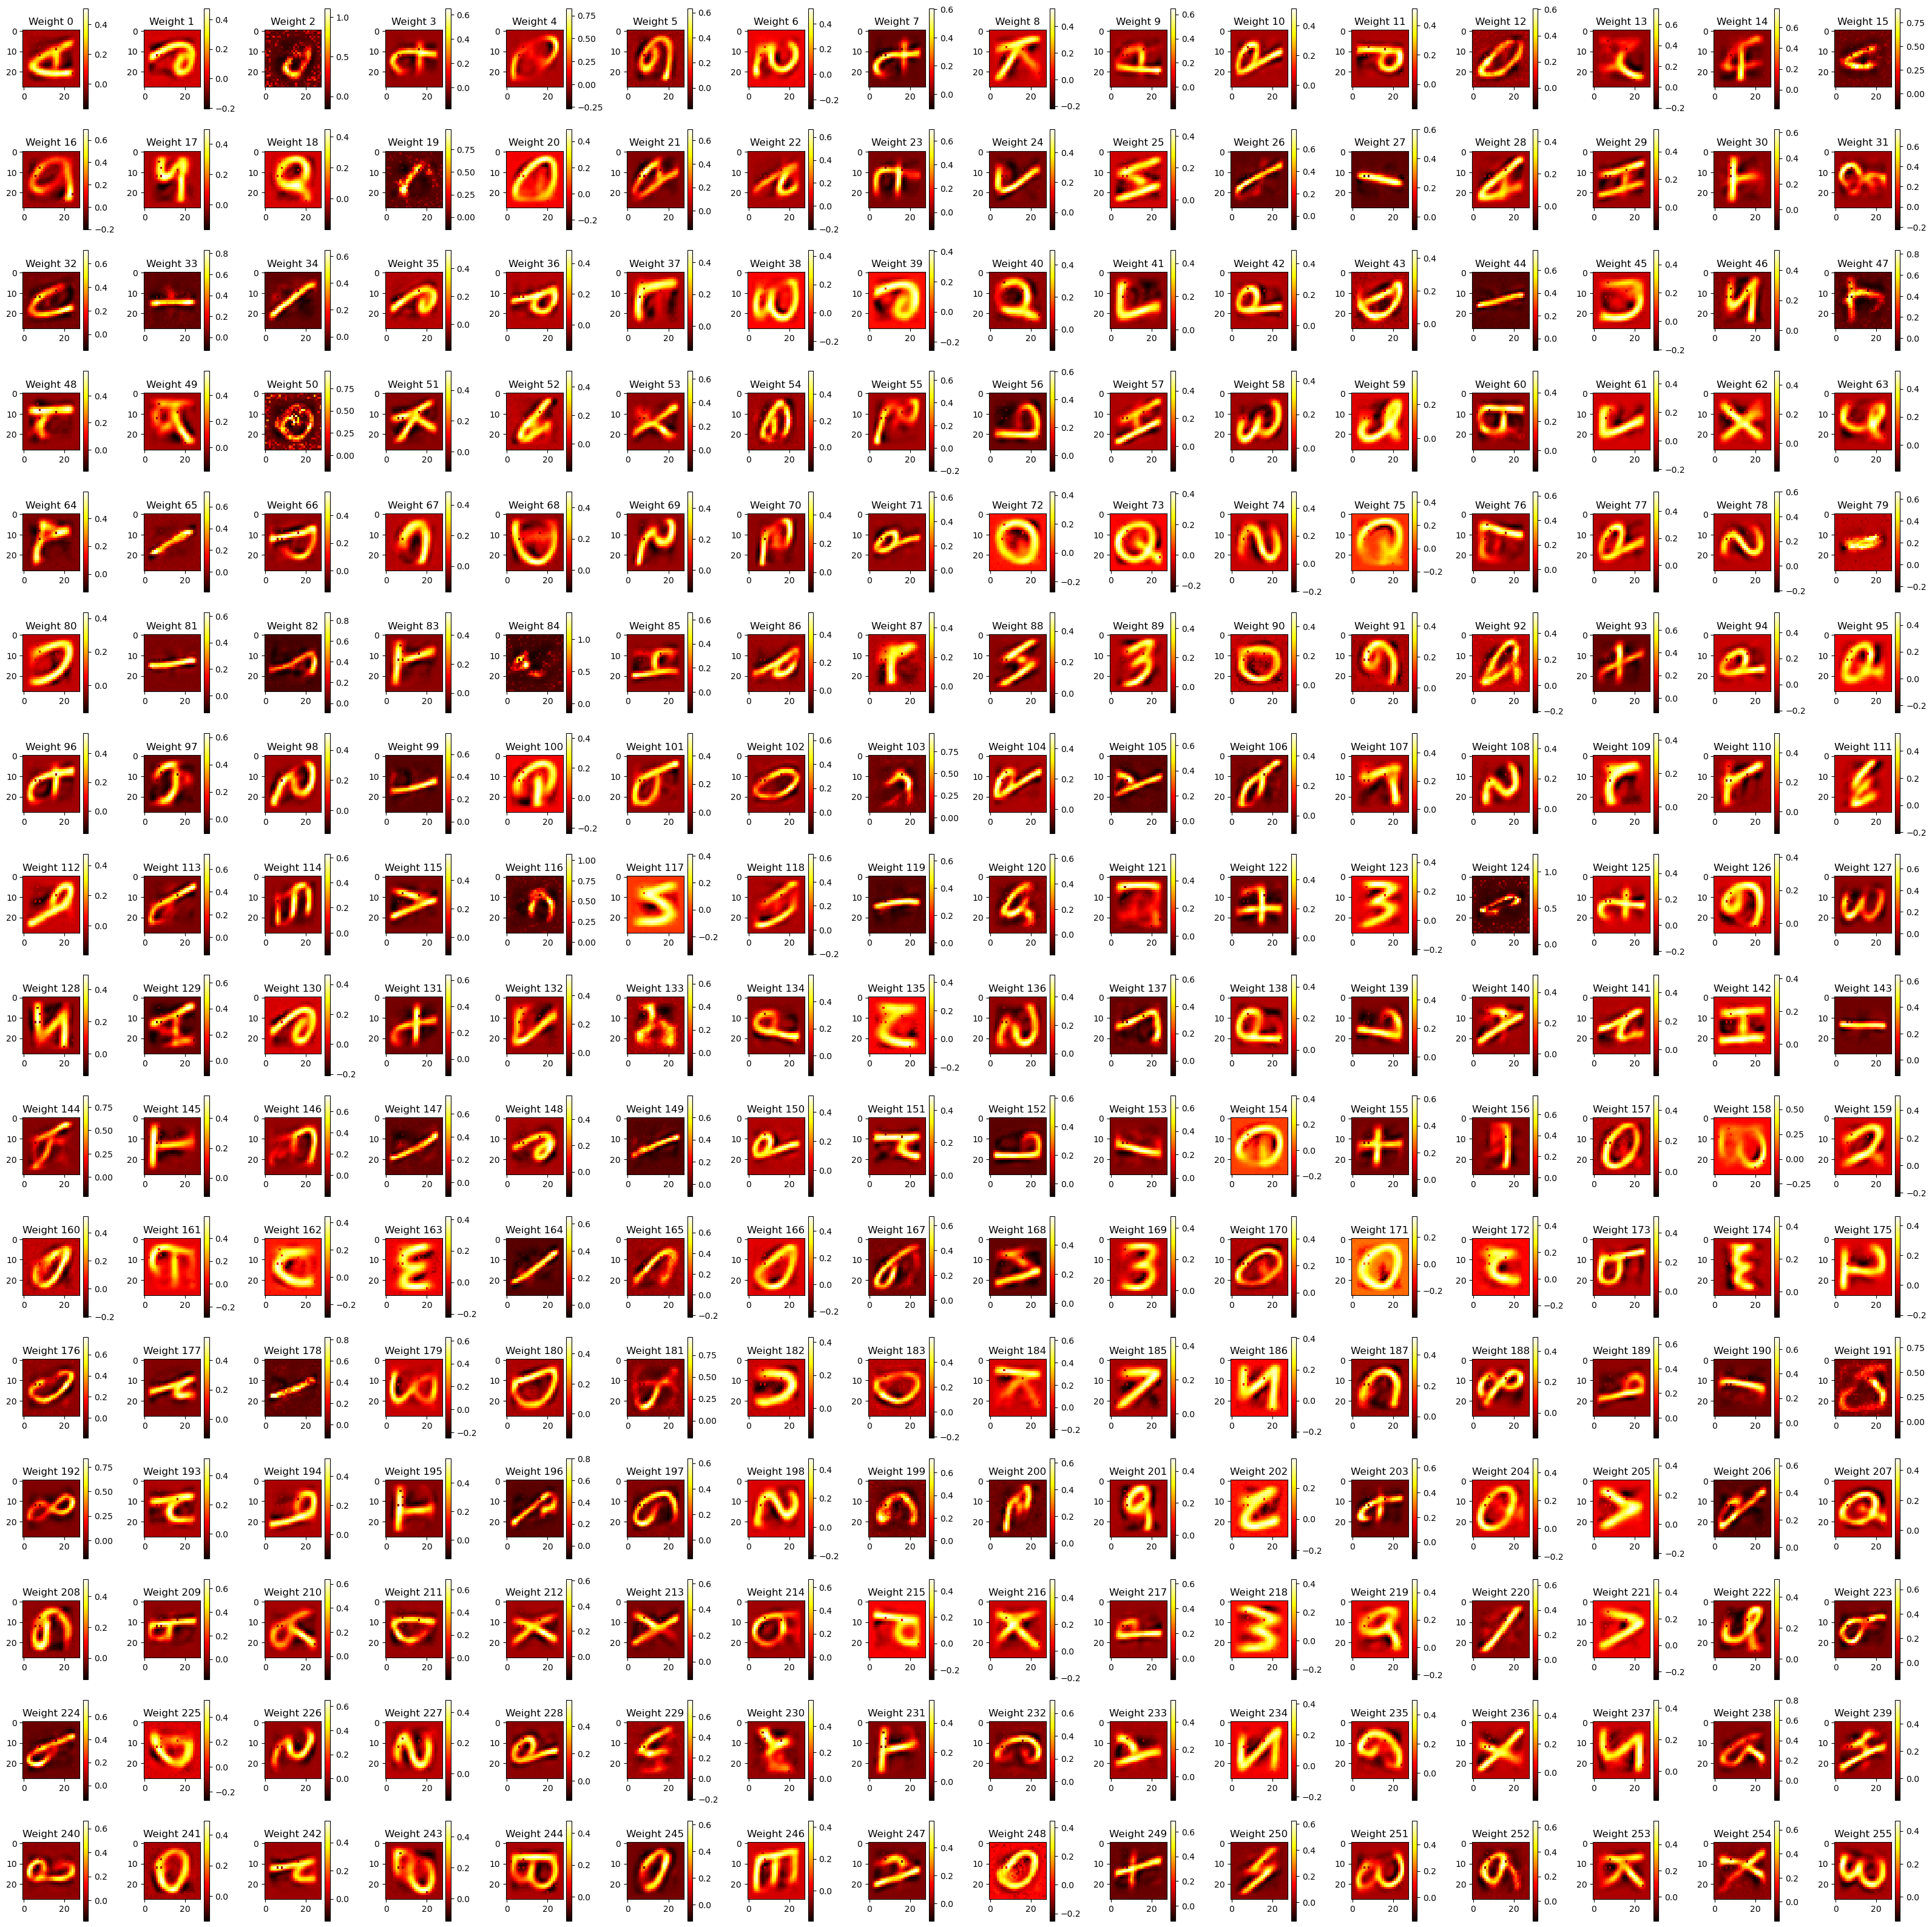

In [244]:
MLPBaseline_EMNIST_Gaussian = MLPBaseline_Experiment(256, 15, 0.005, Learning.FullyOrthogonal, 0.01, emnist_train_dataloader_occlusion[0], 47)
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_train_dataloader_occlusion[0]))
print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_test_dataloader_occlusion[0]))
MLPBaseline_EMNIST_Gaussian.layers['Hebbian1'].visualize_weights()

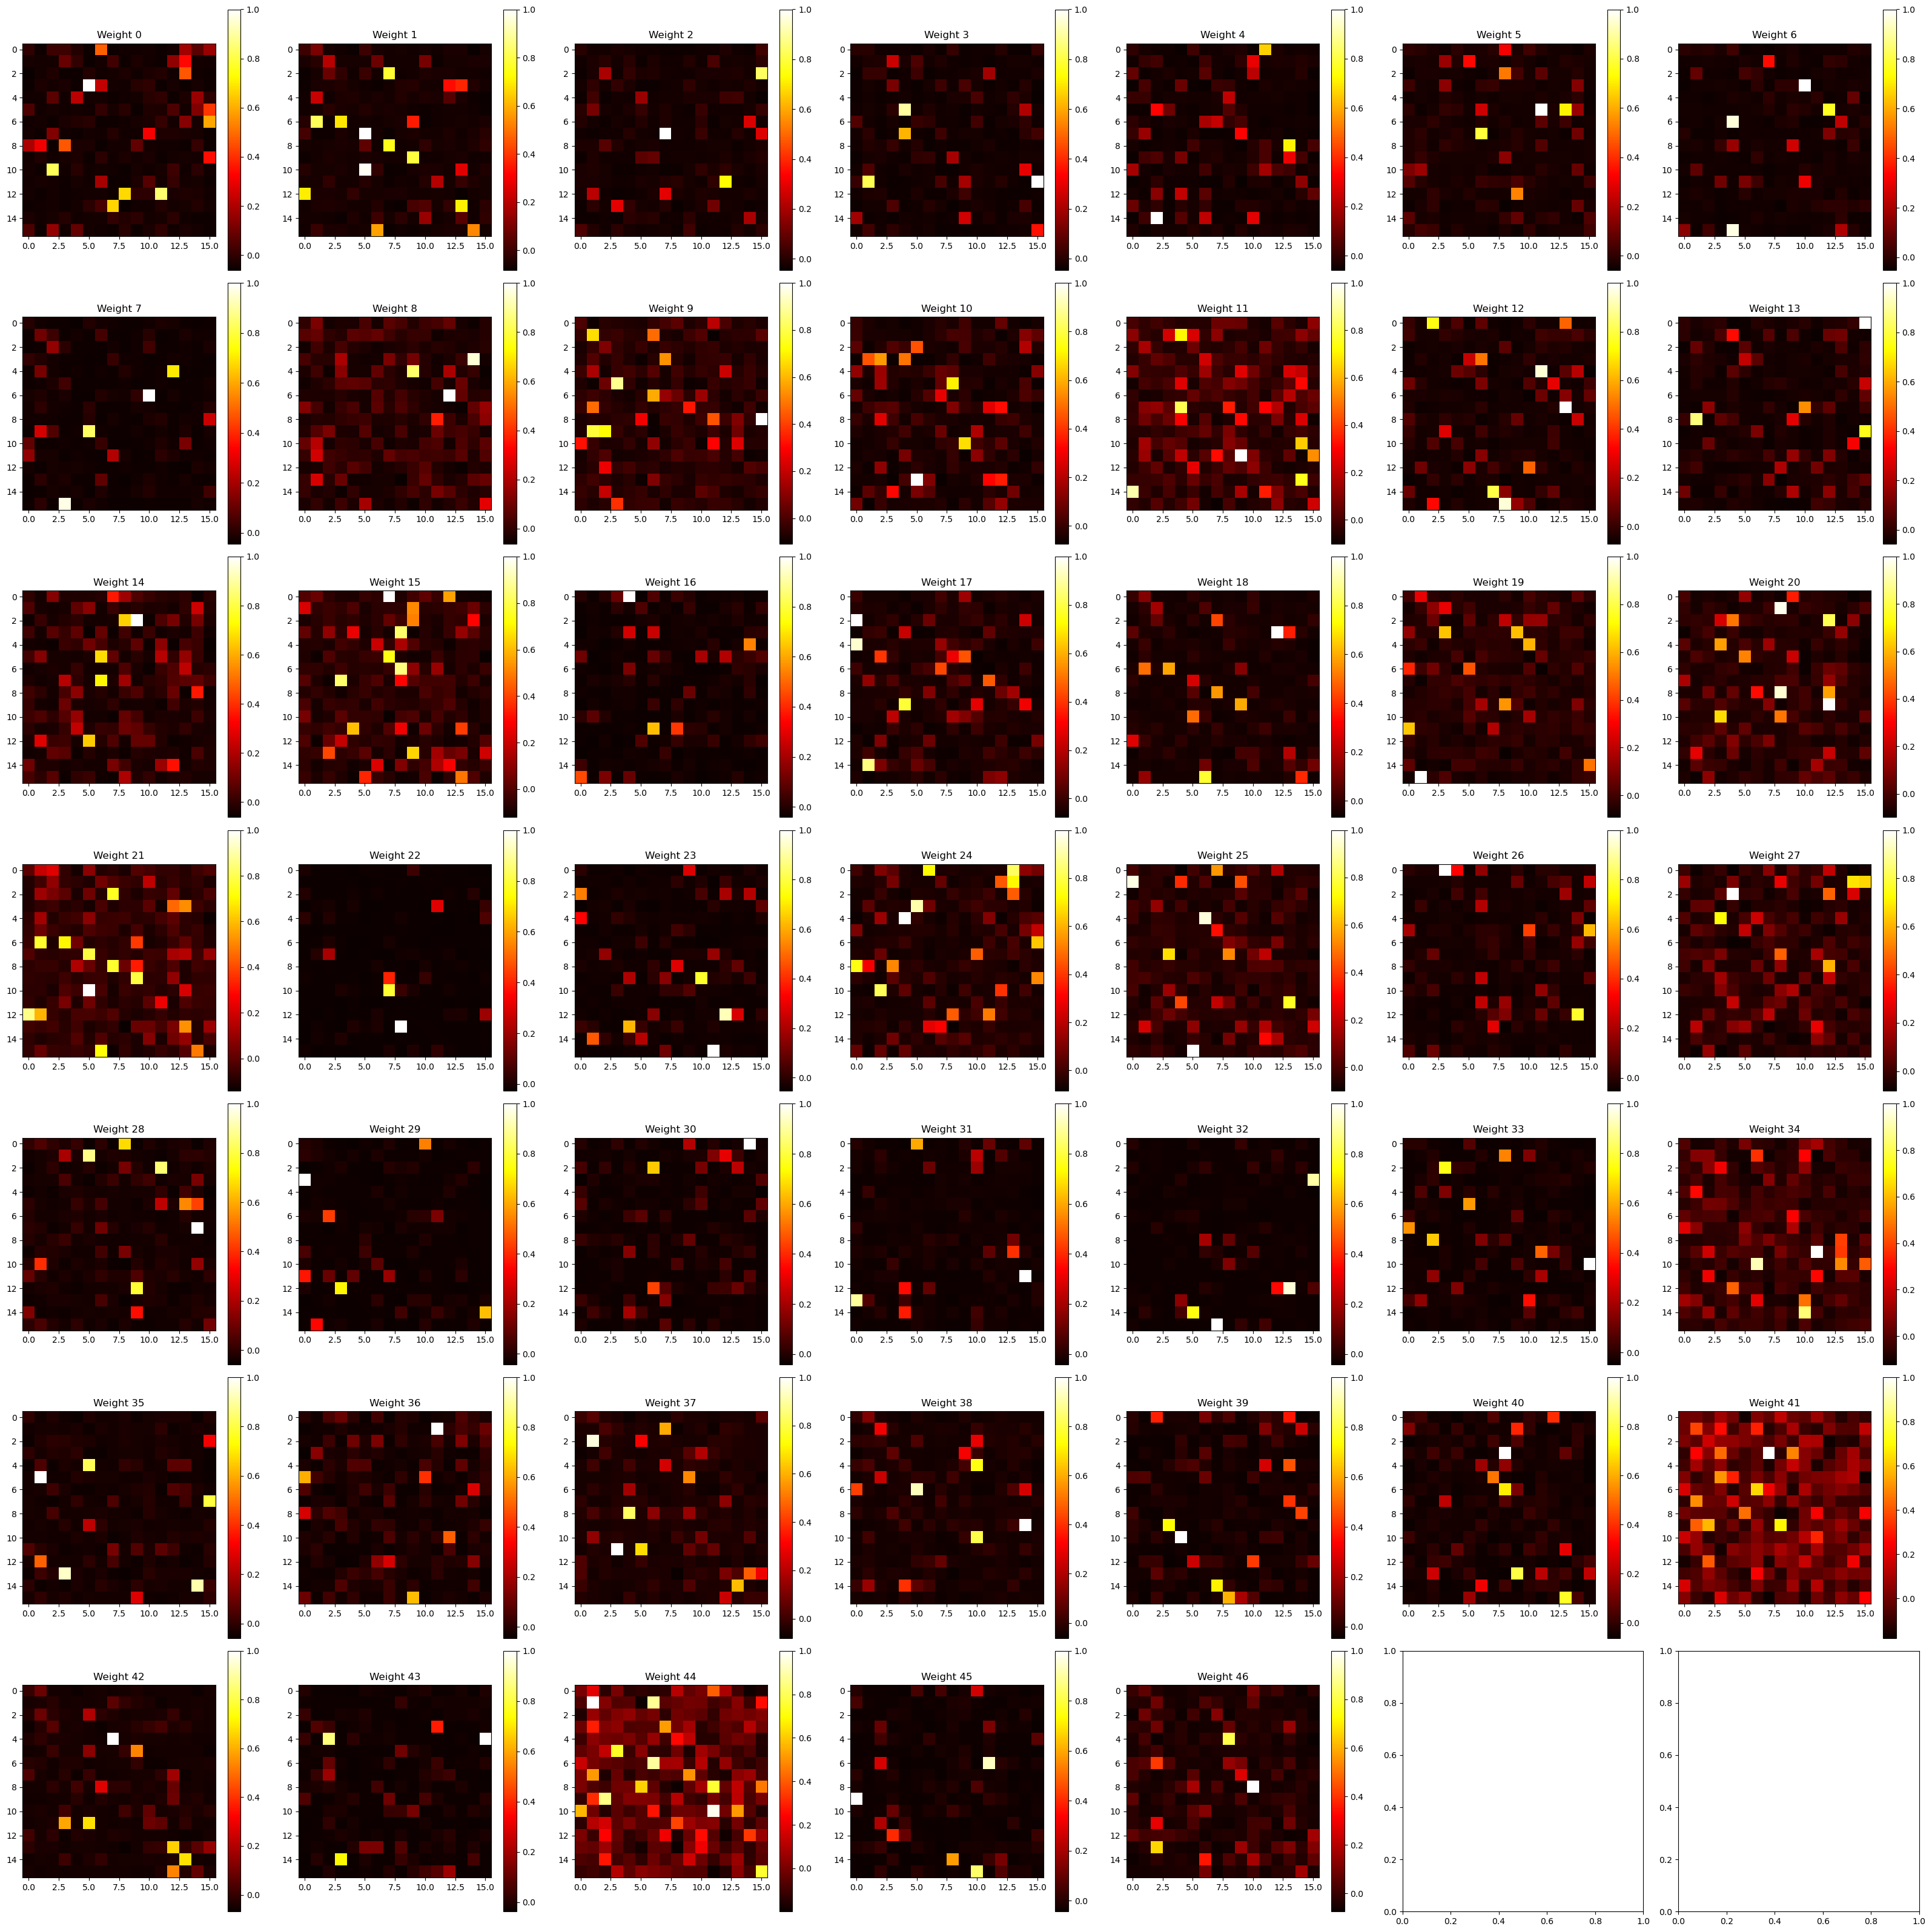

In [216]:
MLPBaseline_EMNIST_Gaussian.layers['Class'].visualize_weights()

In [238]:
for idx in range(5):
    MLPBaseline_EMNIST_Gaussian = MLPBaseline_Experiment(64, 0.75, 0.005, Learning.FullyOrthogonal, 0.1, emnist_train_dataloader_occlusion[idx], 47)
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_train_dataloader_occlusion[idx]))
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_test_dataloader_occlusion[idx]))

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.02127659574468085, {8: (0, 2400), 29: (0, 2400), 31: (0, 2400), 7: (0, 2400), 41: (0, 2400), 43: (0, 2400), 15: (0, 2400), 37: (0, 2400), 4: (0, 2400), 20: (0, 2400), 0: (2400, 2400), 2: (0, 2400), 38: (0, 2400), 33: (0, 2400), 14: (0, 2400), 34: (0, 2400), 36: (0, 2400), 21: (0, 2400), 40: (0, 2400), 19: (0, 2400), 28: (0, 2400), 32: (0, 2400), 3: (0, 2400), 46: (0, 2400), 18: (0, 2400), 30: (0, 2400), 9: (0, 2400), 24: (0, 2400), 27: (0, 2400), 26: (0, 2400), 6: (0, 2400), 1: (0, 2400), 44: (0, 2400), 35: (0, 2400), 42: (0, 2400), 16: (0, 2400), 39: (0, 2400), 23: (0, 2400), 11: (0, 2400), 12: (0, 2400), 25: (0, 2400), 10: (0, 2400), 17: (0, 2400), 45: (0, 2400), 13: (0, 2400), 5: (0, 2400), 22: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {38: (0, 400), 33: (0, 400), 31: (0, 400), 27: (0, 400), 35: (0, 400), 10: (0, 400), 7: (0, 400), 14: (0, 400), 18: (0, 400), 36: (0, 400), 29: (0, 400), 34: (0, 400), 6: (0, 400), 4: (0, 400), 0: (400, 400), 23: (0, 400), 41: (0, 400), 9: (0, 400), 17: (0, 400), 16: (0, 400), 32: (0, 400), 21: (0, 400), 25: (0, 400), 12: (0, 400), 20: (0, 400), 13: (0, 400), 30: (0, 400), 11: (0, 400), 19: (0, 400), 45: (0, 400), 22: (0, 400), 28: (0, 400), 39: (0, 400), 15: (0, 400), 5: (0, 400), 46: (0, 400), 2: (0, 400), 37: (0, 400), 26: (0, 400), 43: (0, 400), 8: (0, 400), 44: (0, 400), 3: (0, 400), 40: (0, 400), 24: (0, 400), 42: (0, 400), 1: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.02127659574468085, {24: (0, 2400), 0: (2400, 2400), 7: (0, 2400), 39: (0, 2400), 17: (0, 2400), 8: (0, 2400), 4: (0, 2400), 14: (0, 2400), 29: (0, 2400), 6: (0, 2400), 11: (0, 2400), 1: (0, 2400), 15: (0, 2400), 36: (0, 2400), 31: (0, 2400), 43: (0, 2400), 13: (0, 2400), 26: (0, 2400), 33: (0, 2400), 32: (0, 2400), 41: (0, 2400), 23: (0, 2400), 18: (0, 2400), 9: (0, 2400), 28: (0, 2400), 16: (0, 2400), 25: (0, 2400), 34: (0, 2400), 12: (0, 2400), 22: (0, 2400), 44: (0, 2400), 19: (0, 2400), 38: (0, 2400), 21: (0, 2400), 35: (0, 2400), 20: (0, 2400), 30: (0, 2400), 37: (0, 2400), 46: (0, 2400), 5: (0, 2400), 10: (0, 2400), 2: (0, 2400), 42: (0, 2400), 3: (0, 2400), 45: (0, 2400), 40: (0, 2400), 27: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {16: (0, 400), 28: (0, 400), 13: (0, 400), 2: (0, 400), 4: (0, 400), 12: (0, 400), 21: (0, 400), 11: (0, 400), 44: (0, 400), 6: (0, 400), 0: (400, 400), 38: (0, 400), 40: (0, 400), 22: (0, 400), 20: (0, 400), 18: (0, 400), 9: (0, 400), 5: (0, 400), 39: (0, 400), 23: (0, 400), 19: (0, 400), 14: (0, 400), 34: (0, 400), 37: (0, 400), 3: (0, 400), 45: (0, 400), 7: (0, 400), 1: (0, 400), 42: (0, 400), 41: (0, 400), 26: (0, 400), 36: (0, 400), 29: (0, 400), 27: (0, 400), 33: (0, 400), 17: (0, 400), 15: (0, 400), 35: (0, 400), 43: (0, 400), 31: (0, 400), 46: (0, 400), 25: (0, 400), 30: (0, 400), 10: (0, 400), 8: (0, 400), 24: (0, 400), 32: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.02127659574468085, {28: (0, 2400), 5: (0, 2400), 13: (0, 2400), 24: (0, 2400), 26: (0, 2400), 34: (0, 2400), 37: (0, 2400), 19: (0, 2400), 42: (0, 2400), 45: (0, 2400), 4: (0, 2400), 20: (0, 2400), 12: (0, 2400), 23: (0, 2400), 41: (0, 2400), 30: (0, 2400), 22: (0, 2400), 21: (0, 2400), 15: (0, 2400), 7: (0, 2400), 16: (0, 2400), 0: (2400, 2400), 33: (0, 2400), 35: (0, 2400), 44: (0, 2400), 25: (0, 2400), 9: (0, 2400), 38: (0, 2400), 32: (0, 2400), 3: (0, 2400), 17: (0, 2400), 2: (0, 2400), 29: (0, 2400), 43: (0, 2400), 11: (0, 2400), 27: (0, 2400), 46: (0, 2400), 39: (0, 2400), 8: (0, 2400), 14: (0, 2400), 6: (0, 2400), 10: (0, 2400), 18: (0, 2400), 36: (0, 2400), 40: (0, 2400), 1: (0, 2400), 31: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {15: (0, 400), 17: (0, 400), 7: (0, 400), 0: (400, 400), 5: (0, 400), 18: (0, 400), 28: (0, 400), 22: (0, 400), 31: (0, 400), 27: (0, 400), 37: (0, 400), 45: (0, 400), 16: (0, 400), 21: (0, 400), 39: (0, 400), 4: (0, 400), 6: (0, 400), 46: (0, 400), 23: (0, 400), 12: (0, 400), 43: (0, 400), 24: (0, 400), 44: (0, 400), 42: (0, 400), 30: (0, 400), 35: (0, 400), 14: (0, 400), 8: (0, 400), 1: (0, 400), 25: (0, 400), 33: (0, 400), 34: (0, 400), 10: (0, 400), 41: (0, 400), 32: (0, 400), 19: (0, 400), 3: (0, 400), 38: (0, 400), 2: (0, 400), 29: (0, 400), 36: (0, 400), 20: (0, 400), 11: (0, 400), 40: (0, 400), 9: (0, 400), 26: (0, 400), 13: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.02127659574468085, {0: (2400, 2400), 24: (0, 2400), 16: (0, 2400), 5: (0, 2400), 38: (0, 2400), 45: (0, 2400), 2: (0, 2400), 6: (0, 2400), 9: (0, 2400), 15: (0, 2400), 27: (0, 2400), 18: (0, 2400), 12: (0, 2400), 26: (0, 2400), 33: (0, 2400), 21: (0, 2400), 32: (0, 2400), 1: (0, 2400), 42: (0, 2400), 22: (0, 2400), 28: (0, 2400), 46: (0, 2400), 7: (0, 2400), 44: (0, 2400), 36: (0, 2400), 35: (0, 2400), 34: (0, 2400), 20: (0, 2400), 29: (0, 2400), 3: (0, 2400), 39: (0, 2400), 30: (0, 2400), 4: (0, 2400), 37: (0, 2400), 25: (0, 2400), 43: (0, 2400), 8: (0, 2400), 14: (0, 2400), 13: (0, 2400), 17: (0, 2400), 41: (0, 2400), 23: (0, 2400), 10: (0, 2400), 19: (0, 2400), 31: (0, 2400), 11: (0, 2400), 40: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {9: (0, 400), 38: (0, 400), 32: (0, 400), 5: (0, 400), 4: (0, 400), 43: (0, 400), 1: (0, 400), 8: (0, 400), 42: (0, 400), 12: (0, 400), 0: (400, 400), 36: (0, 400), 40: (0, 400), 2: (0, 400), 18: (0, 400), 41: (0, 400), 37: (0, 400), 16: (0, 400), 6: (0, 400), 39: (0, 400), 17: (0, 400), 21: (0, 400), 35: (0, 400), 31: (0, 400), 22: (0, 400), 26: (0, 400), 28: (0, 400), 10: (0, 400), 3: (0, 400), 33: (0, 400), 15: (0, 400), 24: (0, 400), 30: (0, 400), 13: (0, 400), 44: (0, 400), 11: (0, 400), 20: (0, 400), 19: (0, 400), 46: (0, 400), 23: (0, 400), 29: (0, 400), 7: (0, 400), 34: (0, 400), 25: (0, 400), 14: (0, 400), 45: (0, 400), 27: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

KeyboardInterrupt: 

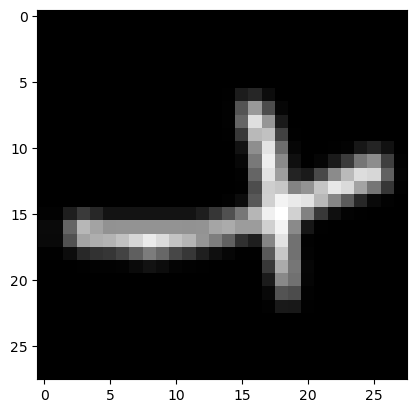

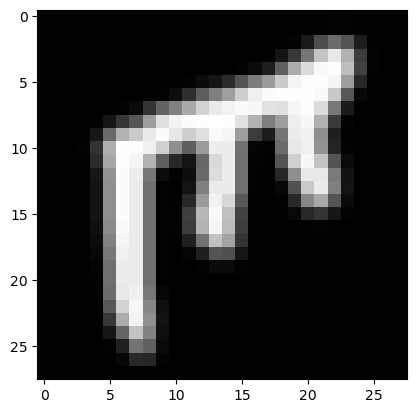

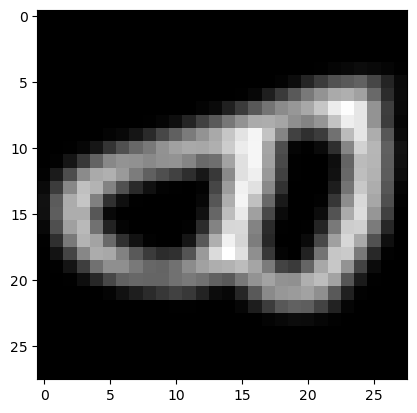

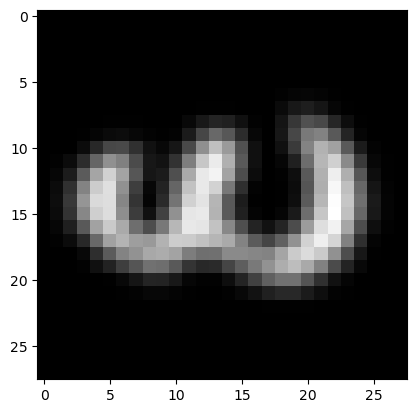

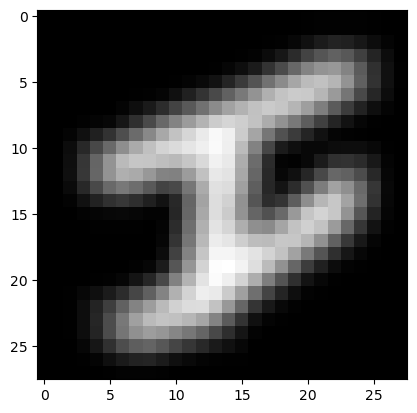

In [246]:
for idx in range(5):
    for data in emnist_test_dataloader_averageblur[idx]:
        inputs, label = data
        plt.imshow(denormalize_grayscale_image(inputs), cmap='gray')
        plt.show()
        break

In [245]:
for idx in range(5):
    MLPBaseline_EMNIST_Gaussian = MLPBaseline_Experiment(256, 15, 0.005, Learning.FullyOrthogonal, 0.01, emnist_train_dataloader_averageblur[idx], 47)
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_train_dataloader_averageblur[idx]))
    print(MLPBaseline_test_accuracy(MLPBaseline_EMNIST_Gaussian, emnist_test_dataloader_averageblur[idx]))

  0%|          | 0/112800 [00:00<?, ?it/s]

/Users/zhaoyizhe/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

  0%|          | 0/112800 [00:00<?, ?it/s]

(0.02127659574468085, {0: (2400, 2400), 35: (0, 2400), 10: (0, 2400), 17: (0, 2400), 45: (0, 2400), 41: (0, 2400), 21: (0, 2400), 29: (0, 2400), 27: (0, 2400), 30: (0, 2400), 37: (0, 2400), 20: (0, 2400), 18: (0, 2400), 19: (0, 2400), 40: (0, 2400), 42: (0, 2400), 6: (0, 2400), 38: (0, 2400), 15: (0, 2400), 33: (0, 2400), 14: (0, 2400), 3: (0, 2400), 9: (0, 2400), 23: (0, 2400), 22: (0, 2400), 7: (0, 2400), 1: (0, 2400), 36: (0, 2400), 26: (0, 2400), 12: (0, 2400), 25: (0, 2400), 31: (0, 2400), 16: (0, 2400), 8: (0, 2400), 2: (0, 2400), 11: (0, 2400), 39: (0, 2400), 32: (0, 2400), 13: (0, 2400), 24: (0, 2400), 4: (0, 2400), 43: (0, 2400), 28: (0, 2400), 34: (0, 2400), 44: (0, 2400), 5: (0, 2400), 46: (0, 2400)})


  0%|          | 0/18800 [00:00<?, ?it/s]

(0.02127659574468085, {3: (0, 400), 34: (0, 400), 43: (0, 400), 2: (0, 400), 1: (0, 400), 6: (0, 400), 5: (0, 400), 40: (0, 400), 15: (0, 400), 33: (0, 400), 17: (0, 400), 23: (0, 400), 29: (0, 400), 12: (0, 400), 20: (0, 400), 41: (0, 400), 27: (0, 400), 36: (0, 400), 4: (0, 400), 11: (0, 400), 30: (0, 400), 26: (0, 400), 45: (0, 400), 0: (400, 400), 35: (0, 400), 39: (0, 400), 13: (0, 400), 9: (0, 400), 7: (0, 400), 21: (0, 400), 16: (0, 400), 31: (0, 400), 19: (0, 400), 24: (0, 400), 22: (0, 400), 46: (0, 400), 32: (0, 400), 28: (0, 400), 37: (0, 400), 44: (0, 400), 38: (0, 400), 25: (0, 400), 42: (0, 400), 10: (0, 400), 18: (0, 400), 14: (0, 400), 8: (0, 400)})


  0%|          | 0/112800 [00:00<?, ?it/s]

KeyboardInterrupt: 